In [ ]:
#imnport packages
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt # for plotting
import os
import torchvision.models
torch.manual_seed(1) # set the random seed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def get_accuracy(model, dataset , batch_size):
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0
    for imgs, labels in iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)):
      #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        output = model(imgs) # We don't need to run F.softmax
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    loss = criterion(output,labels)
    return correct / total, loss

In [ ]:
#helper function
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
drive_path_primary_model = '/content/drive/My Drive/APS360_Project/PrimarymodelCheckpoint/'

def train(model, train_path, valid_path, batch_size = 32, learning_rate = 1e-4, num_epochs = 10, weight_decay=0):
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

    train_dataset = torchvision.datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))
    valid_dataset = torchvision.datasets.DatasetFolder(valid_path, loader=torch.load, extensions=('.tensor'))
    epochs, train_acc, train_losses, valid_acc,valid_losses =[], [], [], [],[]
    #num of iters
    n = 0 

    for epoch in range(num_epochs):
      for imgs, labels in iter(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True)):
                  
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        out = model(imgs)             # forward pass
        loss = criterion(out, labels) # compute the total loss
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()         # a clean up step for PyTorch
        
        
      epochs.append(n)
      train_accuracy, train_loss = get_accuracy(model,train_dataset, batch_size)
      valid_accuracy, valid_loss = get_accuracy(model,valid_dataset, batch_size)
      train_acc.append(train_accuracy)
      train_losses.append(train_loss)
      valid_acc.append(valid_accuracy)
      valid_losses.append(valid_loss)
      if n % 2 == 0:
        print("iteration %d; train loss %f; valid loss %f; Train Acc %f; Val Acc %f" % (n+1, train_losses[-1], valid_losses[-1], train_acc[-1], valid_acc[-1]))
        model_path = drive_path_primary_model + get_model_name(model.name, batch_size, learning_rate, epoch) + str(weight_decay)
        torch.save(model.state_dict(), model_path)
      n += 1
   
    plt.title("Train vs Validation loss")
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()            
    return valid_acc

In [ ]:
torch.manual_seed(1) # set the random seed

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = 'CNN5'
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)#kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 5)
        #((224-4)/2-4)/2 
        self.fc1 = nn.Linear(10 * 53 * 53, 32) #in_channels, out_chanels, kernel_size
        self.fc2 = nn.Linear(32, 4)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def tryOverfitt(model, train_path, valid_path, batch_size = 32, learning_rate = 1e-4, num_epochs = 10):
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_dataset = torchvision.datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))
    valid_dataset = torchvision.datasets.DatasetFolder(valid_path, loader=torch.load, extensions=('.tensor'))
    iterations, train_acc, train_losses, valid_acc,valid_losses =[], [], [], [],[]
    #num of iters
    n = 0 

    for epoch in range(num_epochs):
      for imgs, labels in iter(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True)):
                  
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        out = model(imgs)             # forward pass
        loss = criterion(out, labels) # compute the total loss
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()         # a clean up step for PyTorch
        
        
      iterations.append(n)
      train_accuracy, train_loss = get_accuracy(model,train_dataset, batch_size)
      valid_accuracy, valid_loss = get_accuracy(model,valid_dataset, batch_size)
      train_acc.append(train_accuracy)
      train_losses.append(train_loss)
      valid_acc.append(valid_accuracy)
      valid_losses.append(valid_loss)
      n += 1
      print("iteration %d; train loss %f; Train Acc %f;" % (
          n+1, train_losses[-1],train_acc[-1]))
      
      # if epoch % 10 == 0:
      # print("Epoch: ", epoch, "train acc: ", float(train_acc[-1]))
      # print("iteration %d; train loss %f; valid loss %f; Train Acc %f; Val Acc %f" % (
      #         n+1, train_losses[-1], valid_losses[-1], train_acc[-1], valid_acc[-1]))


   
    plt.title("Train vs Validation loss")
    plt.plot(iterations, train_losses, label="Train")
    plt.plot(iterations, valid_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(iterations, train_acc, label="Train")
    plt.plot(iterations, valid_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()            
    return train_acc

In [ ]:
smalldata_path = '/content/drive/My Drive/APS360_Project/smallDataset'
train_path = '/content/drive/My Drive/APS360_Project/Train_new'
valid_path = '/content/drive/My Drive/APS360_Project/Validation_new'

# ***Primary Model using basic data***

CUDA is available!  Training on GPU ...
iteration 2; train loss 2.625413; Train Acc 0.250000;
iteration 3; train loss 1.693430; Train Acc 0.250000;
iteration 4; train loss 1.213514; Train Acc 0.750000;
iteration 5; train loss 0.828168; Train Acc 0.500000;
iteration 6; train loss 1.128974; Train Acc 0.500000;
iteration 7; train loss 0.138092; Train Acc 1.000000;
iteration 8; train loss 0.507891; Train Acc 0.750000;
iteration 9; train loss 0.020034; Train Acc 1.000000;
iteration 10; train loss 0.091214; Train Acc 1.000000;
iteration 11; train loss 0.109232; Train Acc 1.000000;
iteration 12; train loss 0.010078; Train Acc 1.000000;
iteration 13; train loss 0.001251; Train Acc 1.000000;
iteration 14; train loss 0.000480; Train Acc 1.000000;
iteration 15; train loss 0.005994; Train Acc 1.000000;
iteration 16; train loss 0.002201; Train Acc 1.000000;


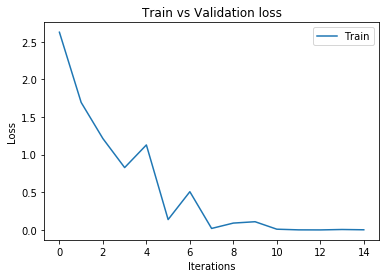

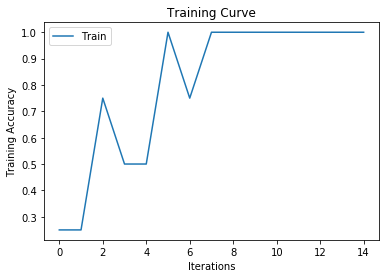

In [ ]:
use_cuda = True
hi = CNNClassifier()
if use_cuda and torch.cuda.is_available():
  hi.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...') 
  
acc = tryOverfitt(hi, smalldata_path, batch_size = 4, learning_rate=0.005,num_epochs=15)

CUDA is available!  Training on GPU ...
iteration 2; train loss 1.231463; valid loss 1.329058; Train Acc 0.387910; Val Acc 0.356992
iteration 3; train loss 1.161467; valid loss 1.618320; Train Acc 0.419808; Val Acc 0.385593
iteration 4; train loss 1.405141; valid loss 1.054659; Train Acc 0.461744; Val Acc 0.430085
iteration 5; train loss 1.162042; valid loss 1.197085; Train Acc 0.556547; Val Acc 0.418432
iteration 6; train loss 0.456987; valid loss 1.056568; Train Acc 0.634843; Val Acc 0.439619
iteration 7; train loss 0.285625; valid loss 1.926925; Train Acc 0.758421; Val Acc 0.456568
iteration 8; train loss 0.546793; valid loss 1.548745; Train Acc 0.818425; Val Acc 0.440678
iteration 9; train loss 1.262012; valid loss 1.486349; Train Acc 0.845862; Val Acc 0.429025
iteration 10; train loss 0.755982; valid loss 0.878570; Train Acc 0.897390; Val Acc 0.442797
iteration 11; train loss 0.071101; valid loss 2.198380; Train Acc 0.953602; Val Acc 0.411017
iteration 12; train loss 0.017997; val

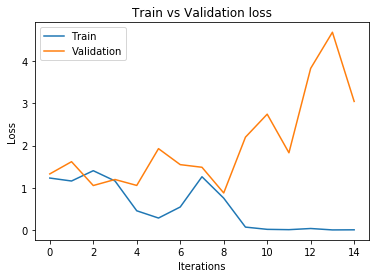

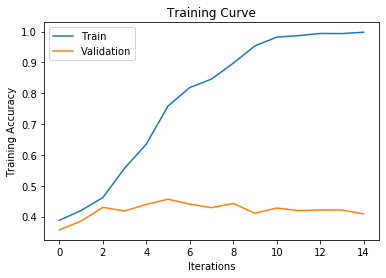

In [ ]:
use_cuda = True
model = CNNClassifier()
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...') 
  
acc = train(model, train_path, valid_path, batch_size = 32, learning_rate=0.001,num_epochs=15)

CUDA is available!  Training on GPU ...
iteration 2; train loss 1.429867; valid loss 1.335888; Train Acc 0.395048; Val Acc 0.385593
iteration 3; train loss 1.257367; valid loss 1.388726; Train Acc 0.404417; Val Acc 0.397246
iteration 4; train loss 0.808656; valid loss 1.208988; Train Acc 0.484051; Val Acc 0.431144
iteration 5; train loss 0.992293; valid loss 1.190160; Train Acc 0.513942; Val Acc 0.447034
iteration 6; train loss 0.950215; valid loss 1.230327; Train Acc 0.599152; Val Acc 0.457627
iteration 7; train loss 1.027861; valid loss 1.326988; Train Acc 0.631720; Val Acc 0.457627
iteration 8; train loss 0.809370; valid loss 1.370819; Train Acc 0.682356; Val Acc 0.460805
iteration 9; train loss 0.870266; valid loss 1.392480; Train Acc 0.623020; Val Acc 0.404661
iteration 10; train loss 1.177175; valid loss 1.425988; Train Acc 0.771805; Val Acc 0.418432
iteration 11; train loss 0.359327; valid loss 1.646603; Train Acc 0.788088; Val Acc 0.443856
iteration 12; train loss 0.139872; val

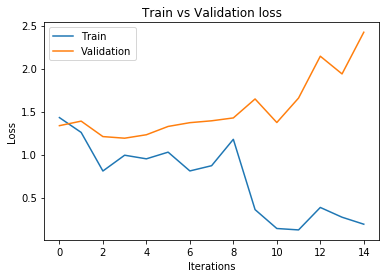

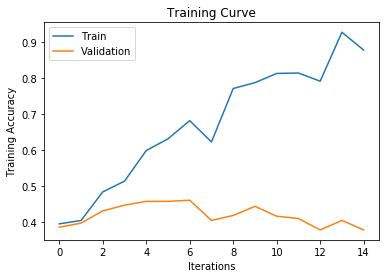

In [ ]:
use_cuda = True
model1 = CNNClassifier()
if use_cuda and torch.cuda.is_available():
  model1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...') 
  
acc = train(model1, train_path, valid_path, batch_size = 64, learning_rate=0.001,num_epochs=15)

CUDA is available!  Training on GPU ...
iteration 2; train loss 1.290712; valid loss 1.381208; Train Acc 0.374526; Val Acc 0.346398
iteration 3; train loss 1.245177; valid loss 1.291691; Train Acc 0.404194; Val Acc 0.381356
iteration 4; train loss 0.901524; valid loss 1.132253; Train Acc 0.467544; Val Acc 0.426907
iteration 5; train loss 0.937489; valid loss 1.108480; Train Acc 0.478251; Val Acc 0.424788
iteration 6; train loss 0.792405; valid loss 1.185682; Train Acc 0.524426; Val Acc 0.447034
iteration 7; train loss 0.981933; valid loss 1.302333; Train Acc 0.586215; Val Acc 0.467161
iteration 8; train loss 1.142986; valid loss 1.372138; Train Acc 0.614544; Val Acc 0.468220
iteration 9; train loss 0.882614; valid loss 1.394892; Train Acc 0.601829; Val Acc 0.444915
iteration 10; train loss 0.848769; valid loss 0.896958; Train Acc 0.666741; Val Acc 0.468220
iteration 11; train loss 0.426903; valid loss 1.372285; Train Acc 0.709569; Val Acc 0.466102
iteration 12; train loss 0.380878; val

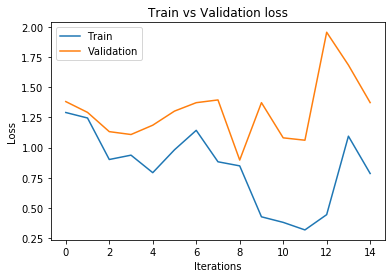

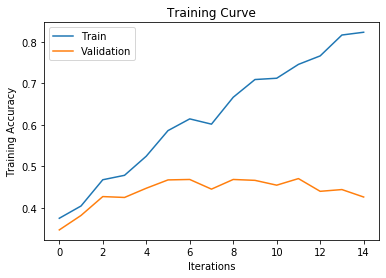

In [ ]:
use_cuda = True
model2 = CNNClassifier()
if use_cuda and torch.cuda.is_available():
  model2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...') 
  
acc = train(model2, train_path, valid_path, batch_size = 32, learning_rate=0.0005,num_epochs=15)

CUDA is available!  Training on GPU ...
iteration 2; train loss 1.299962; valid loss 1.424769; Train Acc 0.355591; Val Acc 0.331568
iteration 3; train loss 1.253640; valid loss 1.271269; Train Acc 0.413355; Val Acc 0.364407
iteration 4; train loss 1.256550; valid loss 1.256471; Train Acc 0.456015; Val Acc 0.412076
iteration 5; train loss 1.318842; valid loss 1.428233; Train Acc 0.463169; Val Acc 0.403602
iteration 6; train loss 1.080405; valid loss 1.415420; Train Acc 0.516693; Val Acc 0.438559
iteration 7; train loss 1.237993; valid loss 1.413828; Train Acc 0.532591; Val Acc 0.445975
iteration 8; train loss 1.097075; valid loss 0.962499; Train Acc 0.587705; Val Acc 0.451271
iteration 9; train loss 0.881247; valid loss 1.196838; Train Acc 0.625331; Val Acc 0.466102
iteration 10; train loss 0.870109; valid loss 0.960455; Train Acc 0.629836; Val Acc 0.454449
iteration 11; train loss 0.713685; valid loss 1.259314; Train Acc 0.670906; Val Acc 0.449153
iteration 12; train loss 0.724362; val

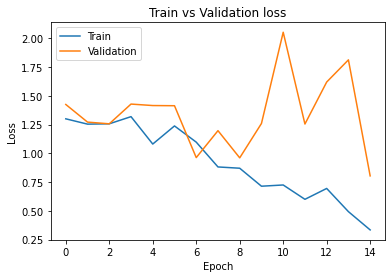

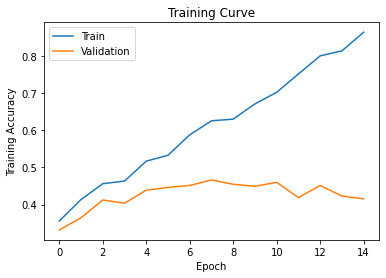

In [ ]:
use_cuda = True
model5 = CNNClassifier()
if use_cuda and torch.cuda.is_available():
  model5.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...') 
  
acc = train(model5, train_path, valid_path, batch_size = 32, learning_rate=0.0005,num_epochs=15)

CUDA is available!  Training on GPU ...
iteration 2; train loss 1.321900; valid loss 1.429474; Train Acc 0.361365; Val Acc 0.353814
iteration 3; train loss 1.255090; valid loss 1.274860; Train Acc 0.408209; Val Acc 0.399364
iteration 4; train loss 1.083267; valid loss 1.308800; Train Acc 0.412447; Val Acc 0.407839
iteration 5; train loss 0.983827; valid loss 1.286754; Train Acc 0.399509; Val Acc 0.385593
iteration 6; train loss 0.974657; valid loss 1.345879; Train Acc 0.396386; Val Acc 0.397246
iteration 7; train loss 1.269588; valid loss 1.250697; Train Acc 0.448807; Val Acc 0.419492
iteration 8; train loss 1.369631; valid loss 1.251905; Train Acc 0.437653; Val Acc 0.396186
iteration 9; train loss 0.883181; valid loss 1.230042; Train Acc 0.445684; Val Acc 0.407839
iteration 10; train loss 1.160543; valid loss 1.017953; Train Acc 0.471782; Val Acc 0.420551
iteration 11; train loss 1.018804; valid loss 1.354925; Train Acc 0.477805; Val Acc 0.423729
iteration 12; train loss 0.886004; val

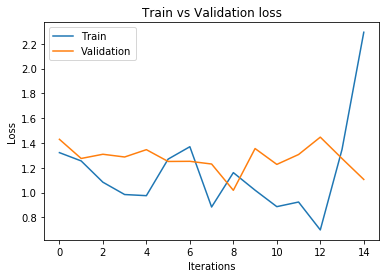

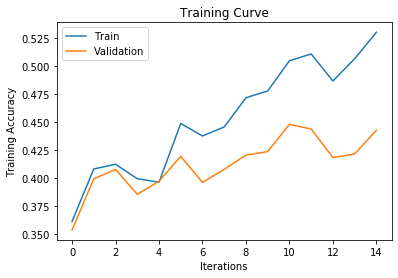

In [ ]:
use_cuda = True
model3 = CNNClassifier()
if use_cuda and torch.cuda.is_available():
  model3.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...') 
  
acc = train(model3, train_path, valid_path, batch_size = 32, learning_rate=0.0001,num_epochs=15)

CUDA is available!  Training on GPU ...
iteration 2; train loss 1.125436; valid loss 1.400667; Train Acc 0.390587; Val Acc 0.337924
iteration 3; train loss 1.186037; valid loss 1.445164; Train Acc 0.428954; Val Acc 0.373941
iteration 4; train loss 0.813454; valid loss 1.151821; Train Acc 0.542494; Val Acc 0.452331
iteration 5; train loss 0.969224; valid loss 1.097326; Train Acc 0.521303; Val Acc 0.408898
iteration 6; train loss 0.638490; valid loss 1.129367; Train Acc 0.647557; Val Acc 0.433263
iteration 7; train loss 0.599545; valid loss 1.866077; Train Acc 0.749052; Val Acc 0.462924
iteration 8; train loss 0.418239; valid loss 1.764922; Train Acc 0.799242; Val Acc 0.445975
iteration 9; train loss 0.904047; valid loss 1.699141; Train Acc 0.810395; Val Acc 0.425847
iteration 10; train loss 0.633925; valid loss 1.187751; Train Acc 0.871515; Val Acc 0.431144
iteration 11; train loss 0.215672; valid loss 2.014847; Train Acc 0.931742; Val Acc 0.421610
iteration 12; train loss 0.032027; val

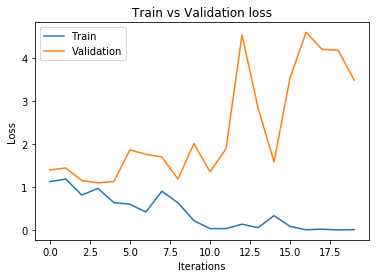

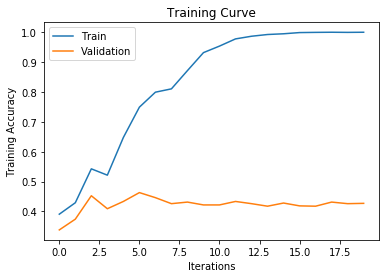

In [ ]:
use_cuda = True
model4 = CNNClassifier()
if use_cuda and torch.cuda.is_available():
  model4.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...') 
  
acc = train(model4, train_path, valid_path, batch_size = 32, learning_rate=0.001,num_epochs=20)

# ***AlexNet***

In [ ]:
train_alex_path = '/content/drive/My Drive/APS360_Project/ModelTuning/Train_alex_new'
valid_alex_path = '/content/drive/My Drive/APS360_Project/ModelTuning/Valid_alex_new'


In [ ]:
smalldata_path = '/content/drive/My Drive/APS360_Project/smallDataset'
train_path = '/content/drive/My Drive/APS360_Project/Train_new'
valid_path = '/content/drive/My Drive/APS360_Project/Validation_new'

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)
train_dataset = torchvision.datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle = True)
valid_dataset = torchvision.datasets.DatasetFolder(valid_path, loader=torch.load, extensions=('.tensor'))
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle = True)
# valid_dataset_check = torchvision.datasets.DatasetFolder(valid_path_check, loader=torch.load, extensions=('.tensor'))
# valid_loader_check = torch.utils.data.DataLoader(valid_dataset_check, batch_size=32, shuffle = True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


FileNotFoundError: ignored

In [ ]:
test_tensor = "/content/drive/My Drive/APS360_Project/ModelTuning/Test_tensor"
test_dataset = torchvision.datasets.DatasetFolder(test_tensor, loader=torch.load, extensions=('.tensor'))


In [ ]:
len(test_dataset)

1400

In [ ]:
valid_loader.dataset

Dataset DatasetFolder
    Number of datapoints: 944
    Root location: /content/drive/My Drive/APS360_Project/Validation_new

In [ ]:
train_dataiter = iter(train_loader)
train_images, labels = train_dataiter.next()
train_features = alexnet.features(train_images)
train_features.shape

val_dataiter = iter(valid_loader)
val_images, labels = val_dataiter.next()
val_features = alexnet.features(val_images)
val_features.shape

# test_dataiter = iter(test_loader)
# test_images, labelstrain = dataiter.next()
# test_features = alexnet.features(test_images)
# test_features.shape

torch.Size([32, 256, 6, 6])

In [ ]:
import os
import torchvision.models
test_alex_path = "/content/drive/My Drive/APS360_Project/ModelTuning/Test_alex"
# Prepare Dataloader (requires code from 1.)
batch_size = 1 # save 1 file at a time, hence batch_size = 1
num_workers = 1

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                       num_workers=num_workers, shuffle=True)
classes =  ['Protrait_Expressionism', 'Protrait_Impressionism', 'Protrait_Realism', 'Protrait_Romanticism']
# save features to folder as tensors
n = 0
for img, label in test_loader:
  train_features = alexnet.features(img)
  features_tensor = torch.from_numpy(train_features.detach().numpy())

  folder_name = test_alex_path + '/' + str(classes[label]) 
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1




In [ ]:
test_alex = "/content/drive/My Drive/APS360_Project/ModelTuning/Test_alex"
test_alex_dataset = torchvision.datasets.DatasetFolder(test_tensor, loader=torch.load, extensions=('.tensor'))
print(len(test_alex_dataset))

1400


In [ ]:
import os
import torchvision.models

# Prepare Dataloader (requires code from 1.)
batch_size = 1 # save 1 file at a time, hence batch_size = 1
num_workers = 1
train_loader1 = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader1 = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
                                       num_workers=num_workers, shuffle=True)
val_loader1_check = torch.utils.data.DataLoader(valid_dataset_check, batch_size=batch_size, 
                                       num_workers=num_workers, shuffle=True)
classes =  ['Protrait_Expressionism', 'Protrait_Impressionism', 'Protrait_Realism', 'Protrait_Romanticism']
save features to folder as tensors
n = 0
for img, label in train_loader1:
  train_features = alexnet.features(img)
  features_tensor = torch.from_numpy(train_features.detach().numpy())

  folder_name = train_alex_path + '/' + str(classes[label]) 
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

n = 0
for img, label in val_loader1:
  val_features = alexnet.features(img)
  features_tensor = torch.from_numpy(val_features.detach().numpy())

  folder_name = valid_alex_path + '/' + str(classes[label]) 
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1



In [ ]:
train_alex_dataset = torchvision.datasets.DatasetFolder(train_alex_path, loader=torch.load, extensions=('.tensor'))
train_feature_loader = torch.utils.data.DataLoader(train_alex_dataset, batch_size=32, shuffle = True)
valid_alex_dataset = torchvision.datasets.DatasetFolder(valid_alex_path, loader=torch.load, extensions=('.tensor'))
val_feature_loader  = torch.utils.data.DataLoader(valid_alex_dataset, batch_size=32, shuffle = True)


In [ ]:
torch.manual_seed(1) # set the random seed

class CNNClassifier_alex(nn.Module):
    def __init__(self):
        super(CNNClassifier_alex, self).__init__()
        self.name = 'CNNAlex_newiter'
        self.conv1 = nn.Conv2d(256, 120, 5, padding = 2) #in_channels, out_chanels, kernel_size
        #((224-4)/2-4)/2 
        self.fc1 = nn.Linear(120*6*6, 100) #in_channels, out_chanels, kernel_size
        self.fc2 = nn.Linear(100, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1,120*6*6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

CUDA is available!  Training on GPU ...
Training Started...
0 0.8853464132434089 0.8720538720538721
1 0.8877988963825874 0.8585858585858586
2 0.9619865113427345 0.9180695847362514
3 0.9828326180257511 0.9326599326599326
4 0.9987737584304108 0.9472502805836139
5 0.9993868792152054 0.9438832772166106
6 0.996934396076027 0.9292929292929293


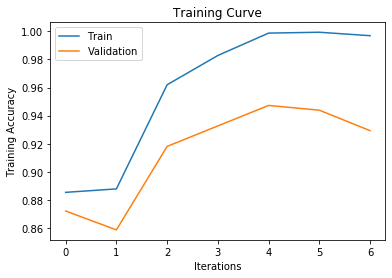

([0.8853464132434089,
  0.8877988963825874,
  0.9619865113427345,
  0.9828326180257511,
  0.9987737584304108,
  0.9993868792152054,
  0.996934396076027],
 [0.8720538720538721,
  0.8585858585858586,
  0.9180695847362514,
  0.9326599326599326,
  0.9472502805836139,
  0.9438832772166106,
  0.9292929292929293])

In [ ]:
use_cuda = True

alex = CNNClassifier_alex()

if use_cuda and torch.cuda.is_available():
  alex.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(alex, train_feature_loader, val_feature_loader, num_epochs=7)

CUDA is available!  Training on GPU ...
iteration 2; train loss 0.866925; valid loss 1.010336; Train Acc 0.604927; Val Acc 0.573710
iteration 3; train loss 0.795756; valid loss 0.611065; Train Acc 0.676095; Val Acc 0.602302
iteration 4; train loss 0.934180; valid loss 0.458332; Train Acc 0.735401; Val Acc 0.649090
iteration 5; train loss 0.517913; valid loss 0.620476; Train Acc 0.810675; Val Acc 0.664686
iteration 6; train loss 0.534863; valid loss 1.131996; Train Acc 0.868613; Val Acc 0.691422
iteration 7; train loss 0.274213; valid loss 0.745611; Train Acc 0.883212; Val Acc 0.700334
iteration 8; train loss 0.277963; valid loss 1.109114; Train Acc 0.858577; Val Acc 0.689566
iteration 9; train loss 0.395430; valid loss 1.480803; Train Acc 0.952555; Val Acc 0.714445
iteration 10; train loss 0.325171; valid loss 0.333729; Train Acc 0.963960; Val Acc 0.725214
iteration 11; train loss 0.088176; valid loss 2.432338; Train Acc 0.985858; Val Acc 0.729298


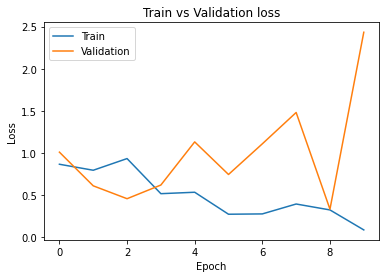

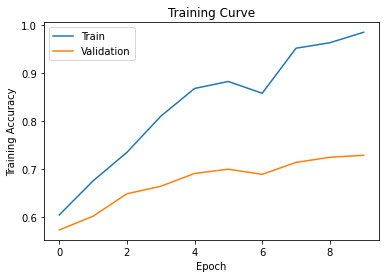

[0.6049270072992701,
 0.676094890510949,
 0.7354014598540146,
 0.8106751824817519,
 0.8686131386861314,
 0.8832116788321168,
 0.8585766423357665,
 0.9525547445255474,
 0.9639598540145985,
 0.9858576642335767]

In [ ]:
use_cuda = True

alex1 = CNNClassifier_alex()

if use_cuda and torch.cuda.is_available():
  alex1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(alex1, train_alex_path, valid_alex_path, num_epochs = 10 )

CUDA is available!  Training on GPU ...
iteration 2; train loss 0.784070; valid loss 1.135688; Train Acc 0.626391; Val Acc 0.579449
iteration 3; train loss 0.743031; valid loss 0.806363; Train Acc 0.677795; Val Acc 0.604873
iteration 4; train loss 0.783051; valid loss 1.407048; Train Acc 0.725225; Val Acc 0.594280
iteration 5; train loss 0.550690; valid loss 1.376775; Train Acc 0.762321; Val Acc 0.619703
iteration 6; train loss 0.315634; valid loss 0.707744; Train Acc 0.812136; Val Acc 0.600636
iteration 7; train loss 0.469662; valid loss 0.517117; Train Acc 0.887917; Val Acc 0.626059
iteration 8; train loss 0.295655; valid loss 0.629834; Train Acc 0.916269; Val Acc 0.623941
iteration 9; train loss 0.280846; valid loss 0.867730; Train Acc 0.953630; Val Acc 0.623941
iteration 10; train loss 0.240419; valid loss 1.316292; Train Acc 0.969793; Val Acc 0.609110
iteration 11; train loss 0.096585; valid loss 1.217115; Train Acc 0.981982; Val Acc 0.608051
iteration 12; train loss 0.096029; val

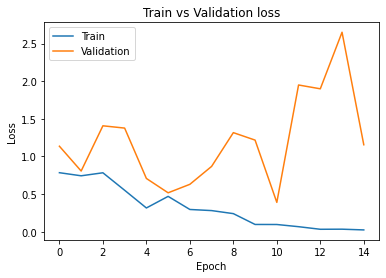

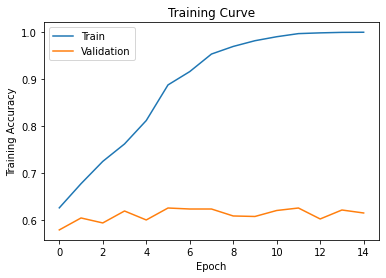

[0.6263910969793323,
 0.6777954425013248,
 0.7252252252252253,
 0.7623211446740858,
 0.8121356650768415,
 0.8879173290937997,
 0.9162692103868575,
 0.9536301006889242,
 0.9697933227344993,
 0.9819819819819819,
 0.9904610492845787,
 0.9970853206147324,
 0.9986751457339693,
 0.9997350291467939,
 1.0]

In [ ]:
use_cuda = True

alex10 = CNNClassifier_alex()

if use_cuda and torch.cuda.is_available():
  alex10.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(alex10, train_alex_path, valid_alex_path, num_epochs = 15 )

CUDA is available!  Training on GPU ...
iteration 2; train loss 0.982349; valid loss 0.807659; Train Acc 0.635665; Val Acc 0.604873
iteration 3; train loss 0.751038; valid loss 0.984299; Train Acc 0.682830; Val Acc 0.587924
iteration 4; train loss 0.878464; valid loss 0.966182; Train Acc 0.645999; Val Acc 0.525424
iteration 5; train loss 0.472029; valid loss 1.212623; Train Acc 0.772390; Val Acc 0.626059
iteration 6; train loss 0.492548; valid loss 0.801288; Train Acc 0.829359; Val Acc 0.617585
iteration 7; train loss 0.343123; valid loss 1.109079; Train Acc 0.877848; Val Acc 0.594280
iteration 8; train loss 0.184917; valid loss 0.494147; Train Acc 0.924483; Val Acc 0.623941
iteration 9; train loss 0.348756; valid loss 1.065592; Train Acc 0.943296; Val Acc 0.620763
iteration 10; train loss 0.215814; valid loss 0.685333; Train Acc 0.962109; Val Acc 0.616525
iteration 11; train loss 0.121474; valid loss 0.914143; Train Acc 0.984102; Val Acc 0.622881


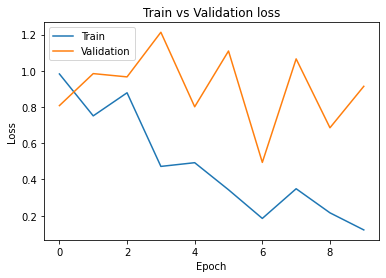

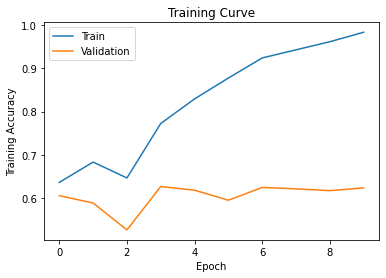

[0.6356650768415474,
 0.6828298887122417,
 0.6459989401165872,
 0.7723900370959195,
 0.8293587705352411,
 0.8778484366719661,
 0.924483306836248,
 0.9432962374138845,
 0.9621091679915209,
 0.9841017488076311]

In [ ]:
use_cuda = True

alex12 = CNNClassifier_alex()

if use_cuda and torch.cuda.is_available():
  alex12.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(alex12, train_alex_path, valid_alex_path, num_epochs=10)

CUDA is available!  Training on GPU ...
iteration 2; train loss 0.989800; valid loss 0.908338; Train Acc 0.605193; Val Acc 0.556144
iteration 3; train loss 0.782413; valid loss 0.872647; Train Acc 0.667462; Val Acc 0.556144
iteration 4; train loss 0.737130; valid loss 1.056205; Train Acc 0.746158; Val Acc 0.566737
iteration 5; train loss 0.386519; valid loss 0.927301; Train Acc 0.829359; Val Acc 0.622881
iteration 6; train loss 0.312609; valid loss 0.936045; Train Acc 0.914944; Val Acc 0.630297
iteration 7; train loss 0.151495; valid loss 1.405811; Train Acc 0.958400; Val Acc 0.599576
iteration 8; train loss 0.065158; valid loss 1.022056; Train Acc 0.987811; Val Acc 0.635593
iteration 9; train loss 0.094157; valid loss 1.415568; Train Acc 0.994966; Val Acc 0.617585
iteration 10; train loss 0.022660; valid loss 0.627330; Train Acc 0.998410; Val Acc 0.641949
iteration 11; train loss 0.010088; valid loss 0.889910; Train Acc 0.999735; Val Acc 0.616525


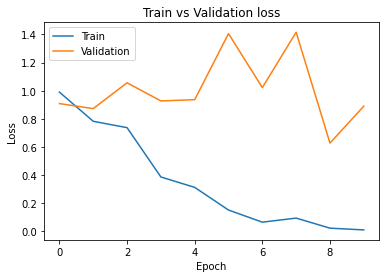

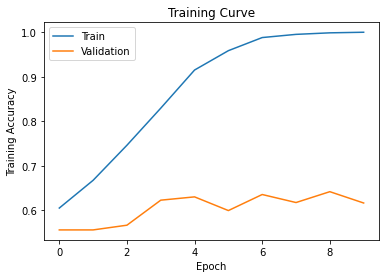

[0.6051934287228405,
 0.6674615792262851,
 0.7461579226285109,
 0.8293587705352411,
 0.9149443561208267,
 0.9583995760466348,
 0.9878113407525172,
 0.9949655537890832,
 0.9984101748807631,
 0.9997350291467939]

In [ ]:
use_cuda = True

alex20 = CNNClassifier_alex()

if use_cuda and torch.cuda.is_available():
  alex20.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(alex20, train_alex_path, valid_alex_path, num_epochs=10, learning_rate=0.0005,batch_size=64)

CUDA is available!  Training on GPU ...
iteration 2; train loss 1.027455; valid loss 0.982632; Train Acc 0.584526; Val Acc 0.554025
iteration 3; train loss 0.737892; valid loss 0.876181; Train Acc 0.644674; Val Acc 0.568856
iteration 4; train loss 0.883790; valid loss 0.976849; Train Acc 0.726285; Val Acc 0.593220
iteration 5; train loss 0.472432; valid loss 0.811937; Train Acc 0.784579; Val Acc 0.599576
iteration 6; train loss 0.426656; valid loss 0.863158; Train Acc 0.878378; Val Acc 0.625000
iteration 7; train loss 0.270709; valid loss 1.224324; Train Acc 0.866985; Val Acc 0.587924
iteration 8; train loss 0.190109; valid loss 0.802831; Train Acc 0.958400; Val Acc 0.610169
iteration 9; train loss 0.127088; valid loss 1.100902; Train Acc 0.967409; Val Acc 0.625000
iteration 10; train loss 0.073551; valid loss 0.649450; Train Acc 0.992846; Val Acc 0.610169
iteration 11; train loss 0.035918; valid loss 0.564972; Train Acc 0.998675; Val Acc 0.629237


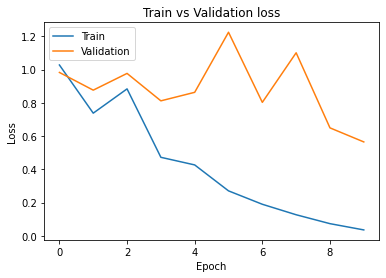

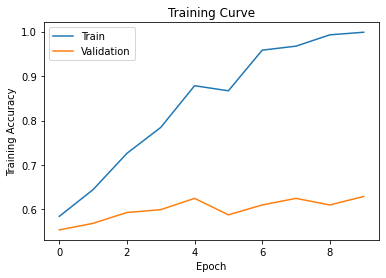

[0.584525702172761,
 0.6446740858505564,
 0.7262851086380498,
 0.7845786963434023,
 0.8783783783783784,
 0.8669846316905141,
 0.9583995760466348,
 0.9674085850556439,
 0.9928457869634341,
 0.9986751457339693]

In [ ]:
use_cuda = True

alex21 = CNNClassifier_alex()

if use_cuda and torch.cuda.is_available():
  alex21.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(alex21, train_alex_path, valid_alex_path, num_epochs=10, learning_rate=0.0005,batch_size=128)

CUDA is available!  Training on GPU ...
iteration 2; train loss 1.008743; valid loss 0.742039; Train Acc 0.610758; Val Acc 0.562500
iteration 3; train loss 0.768857; valid loss 0.975028; Train Acc 0.655803; Val Acc 0.577331
iteration 4; train loss 0.813690; valid loss 1.108998; Train Acc 0.696078; Val Acc 0.563559
iteration 5; train loss 0.415761; valid loss 1.049805; Train Acc 0.775570; Val Acc 0.609110
iteration 6; train loss 0.503512; valid loss 0.863430; Train Acc 0.808161; Val Acc 0.592161
iteration 7; train loss 0.464314; valid loss 1.394548; Train Acc 0.867250; Val Acc 0.580508
iteration 8; train loss 0.264319; valid loss 0.842917; Train Acc 0.924748; Val Acc 0.592161
iteration 9; train loss 0.332675; valid loss 0.952969; Train Acc 0.959459; Val Acc 0.587924
iteration 10; train loss 0.205667; valid loss 0.944292; Train Acc 0.963699; Val Acc 0.581568
iteration 11; train loss 0.216286; valid loss 1.198924; Train Acc 0.967939; Val Acc 0.583686


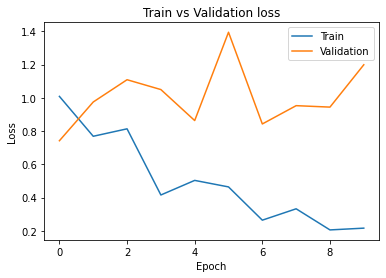

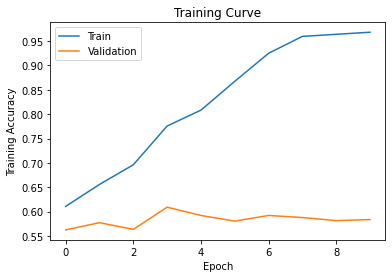

[0.6107578166401696,
 0.6558028616852146,
 0.696078431372549,
 0.7755696873343932,
 0.8081611022787494,
 0.8672496025437202,
 0.9247482776894541,
 0.9594594594594594,
 0.9636989931107578,
 0.9679385267620562]

In [ ]:
use_cuda = True

alex22 = CNNClassifier_alex()

if use_cuda and torch.cuda.is_available():
  alex22.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(alex22, train_alex_path, valid_alex_path, num_epochs=10, learning_rate=0.001,batch_size=32)

In [ ]:
torch.manual_seed(1) # set the random seed

class CNNClassifier_alex_withdropout(nn.Module):
    def __init__(self):
        super(CNNClassifier_alex_withdropout, self).__init__()
        self.name = 'Alex_dropout'
        self.conv1 = nn.Conv2d(256, 120, 5, padding = 2) #in_channels, out_chanels, kernel_size
        #((224-4)/2-4)/2 
        self.dropout2d = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(120*6*6, 500) #in_channels, out_chanels, kernel_size
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 4)
        self.dropout1 = nn.Dropout(0.4) 
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.4)

    def forward(self, x):
        x = F.relu(self.conv1(self.dropout2d(x)))
        x = x.view(-1,120*6*6)
        x = F.relu(self.fc1( self.dropout1(x)))
        x = F.relu(self.fc2(self.dropout2(x)))
        x = self.fc3(self.dropout3(x))
        return x

In [ ]:
train_alex_path = '/content/drive/My Drive/APS360_Project/Train_alex_new'
valid_alex_path = '/content/drive/My Drive/APS360_Project/Valid_alex_new'

CUDA is available!  Training on GPU ...
hiii torch.Size([256, 256, 6, 6])
torch.Size([256, 120, 6, 6])
hiii torch.Size([256, 256, 6, 6])
torch.Size([256, 120, 6, 6])
hiii torch.Size([256, 256, 6, 6])
torch.Size([256, 120, 6, 6])
hiii torch.Size([256, 256, 6, 6])
torch.Size([256, 120, 6, 6])
hiii torch.Size([256, 256, 6, 6])
torch.Size([256, 120, 6, 6])
hiii torch.Size([256, 256, 6, 6])
torch.Size([256, 120, 6, 6])
hiii torch.Size([256, 256, 6, 6])
torch.Size([256, 120, 6, 6])
hiii torch.Size([256, 256, 6, 6])
torch.Size([256, 120, 6, 6])
hiii torch.Size([256, 256, 6, 6])
torch.Size([256, 120, 6, 6])
hiii torch.Size([256, 256, 6, 6])
torch.Size([256, 120, 6, 6])
hiii torch.Size([256, 256, 6, 6])
torch.Size([256, 120, 6, 6])
hiii torch.Size([256, 256, 6, 6])
torch.Size([256, 120, 6, 6])
hiii torch.Size([256, 256, 6, 6])
torch.Size([256, 120, 6, 6])
hiii torch.Size([256, 256, 6, 6])
torch.Size([256, 120, 6, 6])
hiii torch.Size([190, 256, 6, 6])
torch.Size([190, 120, 6, 6])
hiii torch.Size

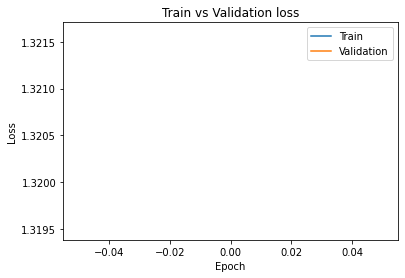

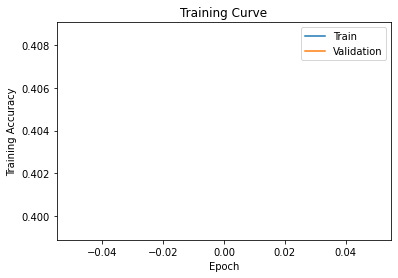

[0.399364406779661]

In [ ]:
use_cuda = True
alex_net = CNNClassifier_alex_withdropout()
if use_cuda and torch.cuda.is_available():
  alex_net.cuda()        
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...') 
train(alex_net, train_alex_path, valid_alex_path, batch_size = 256 , learning_rate= 0.0001 ,num_epochs = 1, weight_decay=0.0001)

Now training weight_decay:  0.001  lr:  0.01  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.389175; valid loss 1.381381; Train Acc 0.249073; Val Acc 0.263771
iteration 3; train loss 1.384915; valid loss 1.384806; Train Acc 0.253842; Val Acc 0.234110
iteration 5; train loss 1.390095; valid loss 1.379789; Train Acc 0.263116; Val Acc 0.234110
iteration 7; train loss 1.392575; valid loss 1.378528; Train Acc 0.250397; Val Acc 0.248941
iteration 9; train loss 1.384309; valid loss 1.404682; Train Acc 0.250397; Val Acc 0.248941
iteration 11; train loss 1.389986; valid loss 1.389740; Train Acc 0.253842; Val Acc 0.234110
iteration 13; train loss 1.391874; valid loss 1.384048; Train Acc 0.250662; Val Acc 0.247881
iteration 15; train loss 1.393427; valid loss 1.388725; Train Acc 0.250397; Val Acc 0.248941
iteration 17; train loss 1.399148; valid loss 1.399596; Train Acc 0.247748; Val Acc 0.245763
iteration 19; train loss 1.389071; valid loss 1.389152; Train Acc 

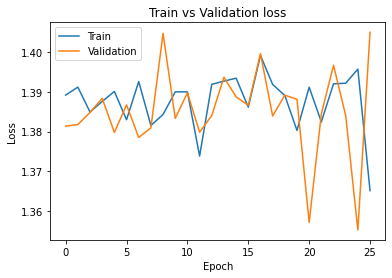

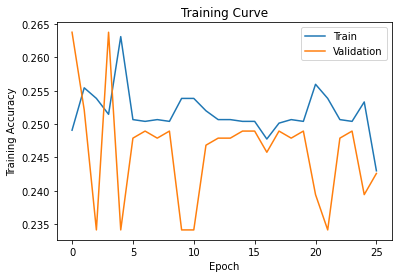

Now training weight_decay:  0.001  lr:  0.01  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.442821; valid loss 1.391812; Train Acc 0.280869; Val Acc 0.251059
iteration 3; train loss 1.334674; valid loss 1.488222; Train Acc 0.276100; Val Acc 0.261653
iteration 5; train loss 1.385862; valid loss 1.365959; Train Acc 0.256757; Val Acc 0.257415
iteration 7; train loss 1.391553; valid loss 1.370188; Train Acc 0.258877; Val Acc 0.254237
iteration 9; train loss 1.378553; valid loss 1.384077; Train Acc 0.278484; Val Acc 0.276483
iteration 11; train loss 1.385946; valid loss 1.297470; Train Acc 0.293853; Val Acc 0.324153
iteration 13; train loss 1.392613; valid loss 1.382874; Train Acc 0.250397; Val Acc 0.248941
iteration 15; train loss 1.391935; valid loss 1.385545; Train Acc 0.250662; Val Acc 0.247881
iteration 17; train loss 1.387454; valid loss 1.386960; Train Acc 0.253842; Val Acc 0.234110
iteration 19; train loss 1.386227; valid loss 1.382003; Train Acc 

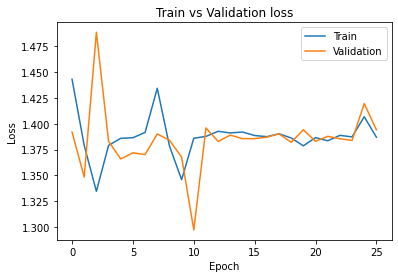

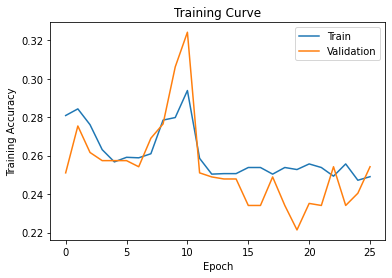

Now training weight_decay:  0.001  lr:  0.01  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.393478; valid loss 1.390972; Train Acc 0.259936; Val Acc 0.239407
iteration 3; train loss 1.386545; valid loss 1.389855; Train Acc 0.252517; Val Acc 0.250000
iteration 5; train loss 1.407789; valid loss 1.257799; Train Acc 0.347907; Val Acc 0.332627
iteration 7; train loss 1.322964; valid loss 1.299704; Train Acc 0.335718; Val Acc 0.343220
iteration 9; train loss 1.264914; valid loss 1.307198; Train Acc 0.326709; Val Acc 0.347458
iteration 11; train loss 1.374424; valid loss 1.414730; Train Acc 0.288023; Val Acc 0.280720
iteration 13; train loss 1.234622; valid loss 1.386014; Train Acc 0.369104; Val Acc 0.314619
iteration 15; train loss 1.277679; valid loss 1.258895; Train Acc 0.394277; Val Acc 0.384534
iteration 17; train loss 1.214338; valid loss 1.349351; Train Acc 0.383943; Val Acc 0.369703
iteration 19; train loss 1.258756; valid loss 1.559273; Train Acc

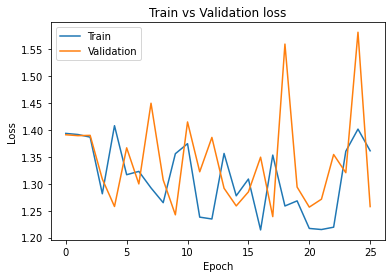

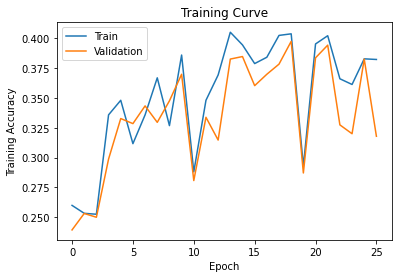

Now training weight_decay:  0.001  lr:  0.01  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.396414; valid loss 1.401118; Train Acc 0.252252; Val Acc 0.240466
iteration 3; train loss 1.262596; valid loss 1.402769; Train Acc 0.336513; Val Acc 0.337924
iteration 5; train loss 1.252376; valid loss 1.247382; Train Acc 0.396131; Val Acc 0.385593
iteration 7; train loss 1.129337; valid loss 1.253919; Train Acc 0.389772; Val Acc 0.367585
iteration 9; train loss 1.288243; valid loss 1.219051; Train Acc 0.409115; Val Acc 0.411017
iteration 11; train loss 1.410606; valid loss 1.225527; Train Acc 0.402756; Val Acc 0.398305
iteration 13; train loss 1.259391; valid loss 1.216341; Train Acc 0.434552; Val Acc 0.404661
iteration 15; train loss 1.203156; valid loss 1.239318; Train Acc 0.397986; Val Acc 0.403602
iteration 17; train loss 1.190011; valid loss 1.257364; Train Acc 0.438792; Val Acc 0.401483
iteration 19; train loss 1.236529; valid loss 1.267228; Train Acc

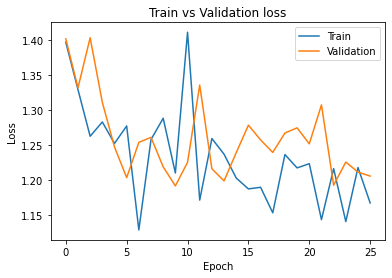

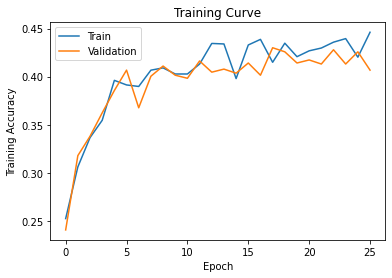

Now training weight_decay:  0.001  lr:  0.005  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.309347; valid loss 1.372839; Train Acc 0.330949; Val Acc 0.334746
iteration 3; train loss 1.243729; valid loss 1.297316; Train Acc 0.353736; Val Acc 0.341102
iteration 5; train loss 1.386479; valid loss 1.332132; Train Acc 0.357711; Val Acc 0.375000
iteration 7; train loss 1.383974; valid loss 1.284883; Train Acc 0.337573; Val Acc 0.331568
iteration 9; train loss 1.245377; valid loss 1.284153; Train Acc 0.367250; Val Acc 0.319915
iteration 11; train loss 1.453923; valid loss 1.257176; Train Acc 0.357976; Val Acc 0.342161
iteration 13; train loss 1.273114; valid loss 1.268254; Train Acc 0.342077; Val Acc 0.310381
iteration 15; train loss 1.222063; valid loss 1.203804; Train Acc 0.391627; Val Acc 0.386653
iteration 17; train loss 1.317974; valid loss 1.159101; Train Acc 0.367250; Val Acc 0.356992
iteration 19; train loss 1.363158; valid loss 1.312116; Train Acc

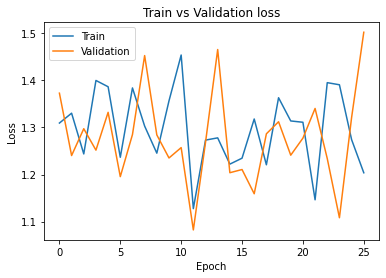

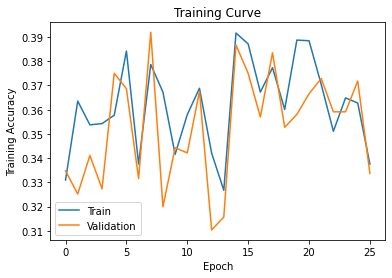

Now training weight_decay:  0.001  lr:  0.005  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.412063; valid loss 1.369143; Train Acc 0.295178; Val Acc 0.262712
iteration 3; train loss 1.291462; valid loss 1.445966; Train Acc 0.411500; Val Acc 0.381356
iteration 5; train loss 1.251467; valid loss 1.299027; Train Acc 0.450980; Val Acc 0.387712
iteration 7; train loss 1.052012; valid loss 1.136497; Train Acc 0.454955; Val Acc 0.416314
iteration 9; train loss 1.486270; valid loss 1.623473; Train Acc 0.350026; Val Acc 0.308263
iteration 11; train loss 1.213471; valid loss 1.351723; Train Acc 0.477477; Val Acc 0.436441
iteration 13; train loss 1.065621; valid loss 1.240608; Train Acc 0.447536; Val Acc 0.415254
iteration 15; train loss 1.070148; valid loss 1.182418; Train Acc 0.485957; Val Acc 0.434322
iteration 17; train loss 1.095330; valid loss 1.382234; Train Acc 0.488606; Val Acc 0.458686
iteration 19; train loss 1.237239; valid loss 1.268183; Train Acc

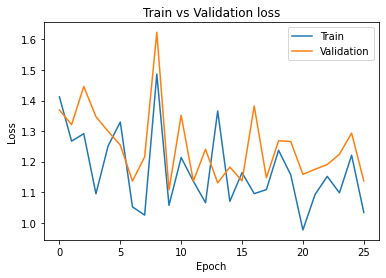

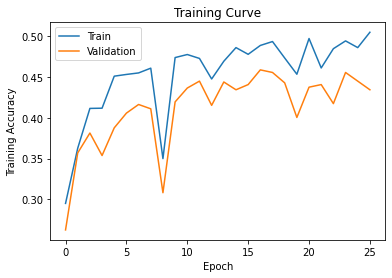

Now training weight_decay:  0.001  lr:  0.005  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.275863; valid loss 1.237286; Train Acc 0.433492; Val Acc 0.429025
iteration 3; train loss 1.261111; valid loss 1.184977; Train Acc 0.457605; Val Acc 0.442797
iteration 5; train loss 1.112029; valid loss 1.140010; Train Acc 0.520668; Val Acc 0.478814
iteration 7; train loss 1.076857; valid loss 1.000483; Train Acc 0.519343; Val Acc 0.466102
iteration 9; train loss 1.094930; valid loss 1.142447; Train Acc 0.512454; Val Acc 0.473517
iteration 11; train loss 1.157745; valid loss 1.027519; Train Acc 0.521198; Val Acc 0.483051
iteration 13; train loss 1.627739; valid loss 1.369160; Train Acc 0.405670; Val Acc 0.347458
iteration 15; train loss 1.082120; valid loss 1.184077; Train Acc 0.526497; Val Acc 0.465042
iteration 17; train loss 1.194909; valid loss 1.087432; Train Acc 0.518018; Val Acc 0.492585
iteration 19; train loss 1.086002; valid loss 1.324881; Train Ac

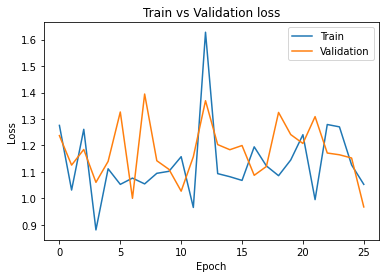

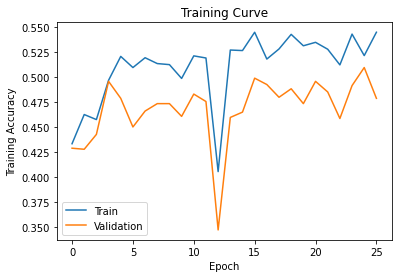

Now training weight_decay:  0.001  lr:  0.005  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.345559; valid loss 1.344752; Train Acc 0.352941; Val Acc 0.320975
iteration 3; train loss 1.266565; valid loss 1.200194; Train Acc 0.411765; Val Acc 0.437500
iteration 5; train loss 1.163719; valid loss 1.169815; Train Acc 0.453895; Val Acc 0.445975
iteration 7; train loss 1.099389; valid loss 1.198519; Train Acc 0.486751; Val Acc 0.440678
iteration 9; train loss 1.095714; valid loss 1.063510; Train Acc 0.501590; Val Acc 0.477754
iteration 11; train loss 1.176864; valid loss 1.146890; Train Acc 0.515368; Val Acc 0.480932
iteration 13; train loss 1.043163; valid loss 1.105009; Train Acc 0.524377; Val Acc 0.475636
iteration 15; train loss 1.120763; valid loss 1.173593; Train Acc 0.540541; Val Acc 0.501059
iteration 17; train loss 1.050855; valid loss 1.127098; Train Acc 0.525967; Val Acc 0.487288
iteration 19; train loss 1.103909; valid loss 1.122530; Train Ac

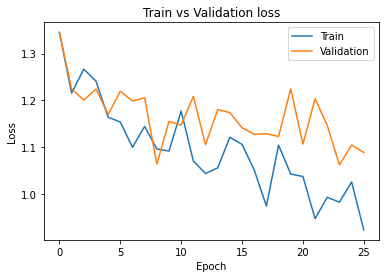

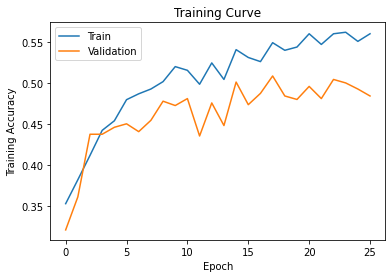

Now training weight_decay:  0.001  lr:  0.001  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.191649; valid loss 1.016408; Train Acc 0.493376; Val Acc 0.472458
iteration 3; train loss 1.108661; valid loss 1.231674; Train Acc 0.530737; Val Acc 0.475636
iteration 5; train loss 1.246734; valid loss 0.965752; Train Acc 0.545575; Val Acc 0.522246
iteration 7; train loss 1.024735; valid loss 0.829465; Train Acc 0.578696; Val Acc 0.501059
iteration 9; train loss 0.879302; valid loss 1.093979; Train Acc 0.586380; Val Acc 0.502119
iteration 11; train loss 0.834688; valid loss 0.855354; Train Acc 0.596184; Val Acc 0.528602
iteration 13; train loss 1.070259; valid loss 0.976009; Train Acc 0.596184; Val Acc 0.529661
iteration 15; train loss 0.891804; valid loss 1.021465; Train Acc 0.616587; Val Acc 0.528602
iteration 17; train loss 0.851936; valid loss 0.862031; Train Acc 0.619767; Val Acc 0.541314
iteration 19; train loss 0.857838; valid loss 1.478604; Train Acc

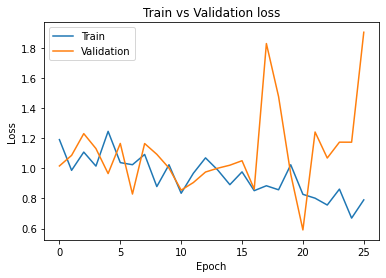

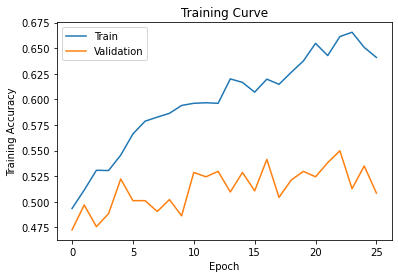

Now training weight_decay:  0.001  lr:  0.001  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.199544; valid loss 1.098536; Train Acc 0.505564; Val Acc 0.493644
iteration 3; train loss 1.084076; valid loss 1.121423; Train Acc 0.536831; Val Acc 0.496822
iteration 5; train loss 1.021949; valid loss 1.209677; Train Acc 0.569157; Val Acc 0.518008
iteration 7; train loss 0.905846; valid loss 0.923813; Train Acc 0.605723; Val Acc 0.501059
iteration 9; train loss 0.858713; valid loss 1.003840; Train Acc 0.606253; Val Acc 0.529661
iteration 11; train loss 0.951705; valid loss 1.077320; Train Acc 0.626391; Val Acc 0.557203
iteration 13; train loss 0.638737; valid loss 1.010276; Train Acc 0.663487; Val Acc 0.534958
iteration 15; train loss 0.839769; valid loss 1.067136; Train Acc 0.669316; Val Acc 0.539195
iteration 17; train loss 0.767956; valid loss 1.042310; Train Acc 0.674086; Val Acc 0.541314
iteration 19; train loss 0.896294; valid loss 1.156924; Train Acc

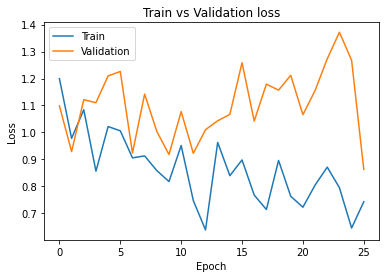

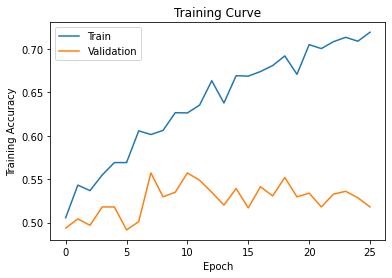

Now training weight_decay:  0.001  lr:  0.001  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.254400; valid loss 1.194103; Train Acc 0.496820; Val Acc 0.493644
iteration 3; train loss 1.290501; valid loss 1.318476; Train Acc 0.505829; Val Acc 0.478814
iteration 5; train loss 1.013089; valid loss 0.991789; Train Acc 0.574722; Val Acc 0.514831
iteration 7; train loss 0.890008; valid loss 0.932700; Train Acc 0.611023; Val Acc 0.507415
iteration 9; train loss 0.838537; valid loss 0.764946; Train Acc 0.622946; Val Acc 0.525424
iteration 11; train loss 0.757487; valid loss 1.139414; Train Acc 0.643879; Val Acc 0.546610
iteration 13; train loss 0.830431; valid loss 1.128785; Train Acc 0.668521; Val Acc 0.531780
iteration 15; train loss 0.796943; valid loss 1.031244; Train Acc 0.666667; Val Acc 0.536017
iteration 17; train loss 0.843901; valid loss 1.295919; Train Acc 0.696343; Val Acc 0.538136
iteration 19; train loss 0.736138; valid loss 1.242231; Train Ac

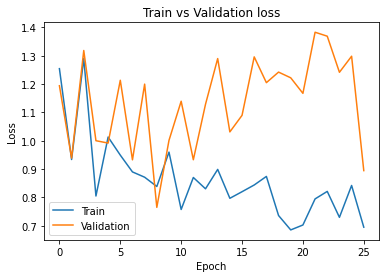

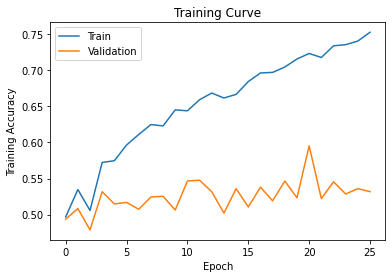

Now training weight_decay:  0.001  lr:  0.001  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.257740; valid loss 1.268801; Train Acc 0.424218; Val Acc 0.394068
iteration 3; train loss 1.141504; valid loss 1.130245; Train Acc 0.540806; Val Acc 0.522246
iteration 5; train loss 1.011881; valid loss 1.069669; Train Acc 0.573927; Val Acc 0.536017
iteration 7; train loss 0.888325; valid loss 1.159400; Train Acc 0.602014; Val Acc 0.556144
iteration 9; train loss 0.830697; valid loss 0.997943; Train Acc 0.622417; Val Acc 0.539195
iteration 11; train loss 0.837872; valid loss 1.051349; Train Acc 0.639375; Val Acc 0.538136
iteration 13; train loss 0.738959; valid loss 0.987434; Train Acc 0.661102; Val Acc 0.544492
iteration 15; train loss 0.817480; valid loss 1.118482; Train Acc 0.685745; Val Acc 0.532839
iteration 17; train loss 0.743285; valid loss 1.114365; Train Acc 0.693694; Val Acc 0.556144
iteration 19; train loss 0.746481; valid loss 1.062831; Train Ac

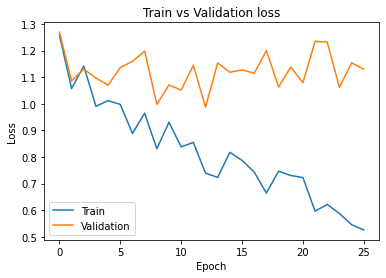

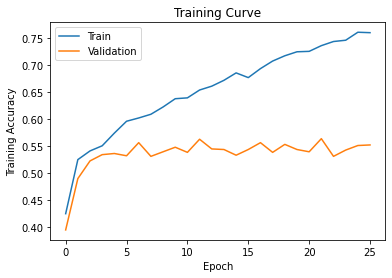

Now training weight_decay:  0.001  lr:  0.0005  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.147158; valid loss 1.089674; Train Acc 0.492581; Val Acc 0.457627
iteration 3; train loss 1.060604; valid loss 1.139637; Train Acc 0.553524; Val Acc 0.489407
iteration 5; train loss 1.117023; valid loss 1.050845; Train Acc 0.569687; Val Acc 0.527542
iteration 7; train loss 0.835311; valid loss 0.856179; Train Acc 0.629836; Val Acc 0.543432
iteration 9; train loss 0.801755; valid loss 0.957048; Train Acc 0.629041; Val Acc 0.505297
iteration 11; train loss 0.770281; valid loss 0.830988; Train Acc 0.648649; Val Acc 0.545551
iteration 13; train loss 0.872061; valid loss 0.982896; Train Acc 0.669316; Val Acc 0.546610
iteration 15; train loss 0.609204; valid loss 0.975463; Train Acc 0.690249; Val Acc 0.541314
iteration 17; train loss 0.638083; valid loss 1.197232; Train Acc 0.710122; Val Acc 0.546610
iteration 19; train loss 0.899223; valid loss 1.456170; Train Ac

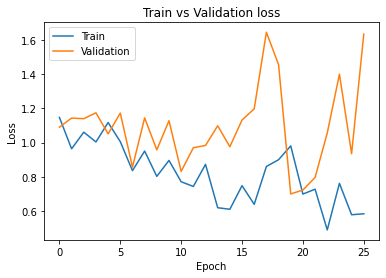

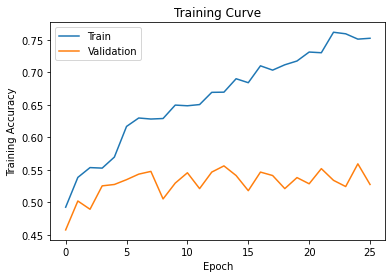

Now training weight_decay:  0.001  lr:  0.0005  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.195405; valid loss 1.152972; Train Acc 0.500530; Val Acc 0.495763
iteration 3; train loss 1.091006; valid loss 1.117749; Train Acc 0.541335; Val Acc 0.489407
iteration 5; train loss 0.952473; valid loss 1.202560; Train Acc 0.578961; Val Acc 0.516949
iteration 7; train loss 0.791529; valid loss 0.838213; Train Acc 0.625331; Val Acc 0.537076
iteration 9; train loss 0.787319; valid loss 0.861963; Train Acc 0.654478; Val Acc 0.552966
iteration 11; train loss 0.815885; valid loss 0.904420; Train Acc 0.668256; Val Acc 0.555085
iteration 13; train loss 0.612111; valid loss 1.113327; Train Acc 0.693164; Val Acc 0.541314
iteration 15; train loss 0.769985; valid loss 1.052480; Train Acc 0.699788; Val Acc 0.542373
iteration 17; train loss 0.766125; valid loss 1.134291; Train Acc 0.717541; Val Acc 0.544492
iteration 19; train loss 0.766164; valid loss 1.428080; Train Ac

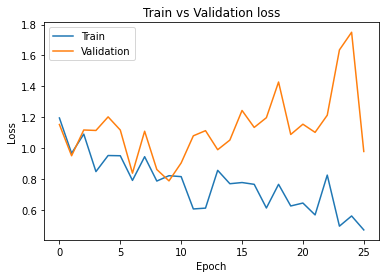

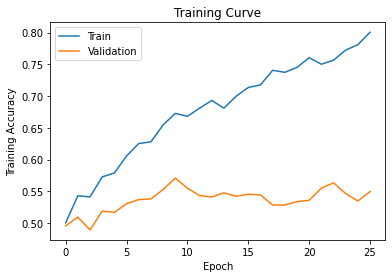

Now training weight_decay:  0.001  lr:  0.0005  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.240552; valid loss 1.190040; Train Acc 0.507949; Val Acc 0.462924
iteration 3; train loss 1.253427; valid loss 1.133193; Train Acc 0.551404; Val Acc 0.520127
iteration 5; train loss 0.959893; valid loss 1.016826; Train Acc 0.582406; Val Acc 0.528602
iteration 7; train loss 0.859881; valid loss 0.869279; Train Acc 0.619767; Val Acc 0.543432
iteration 9; train loss 0.836235; valid loss 0.833587; Train Acc 0.650768; Val Acc 0.537076
iteration 11; train loss 0.756950; valid loss 1.065445; Train Acc 0.672231; Val Acc 0.536017
iteration 13; train loss 0.620028; valid loss 1.194089; Train Acc 0.700318; Val Acc 0.547669
iteration 15; train loss 0.751378; valid loss 1.064507; Train Acc 0.700848; Val Acc 0.544492
iteration 17; train loss 0.773672; valid loss 1.189316; Train Acc 0.745363; Val Acc 0.547669
iteration 19; train loss 0.704322; valid loss 1.316793; Train A

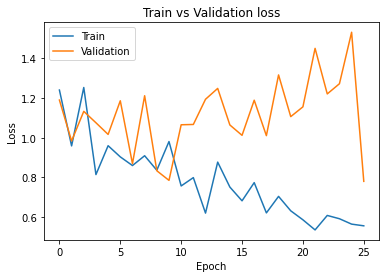

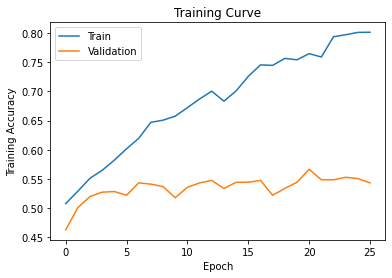

Now training weight_decay:  0.001  lr:  0.0005  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.197000; valid loss 1.186610; Train Acc 0.451775; Val Acc 0.426907
iteration 3; train loss 1.164138; valid loss 1.112832; Train Acc 0.542660; Val Acc 0.524364
iteration 5; train loss 0.975232; valid loss 1.063421; Train Acc 0.581876; Val Acc 0.540254
iteration 7; train loss 0.886622; valid loss 1.130193; Train Acc 0.589560; Val Acc 0.522246
iteration 9; train loss 0.847442; valid loss 0.950780; Train Acc 0.634605; Val Acc 0.543432
iteration 11; train loss 0.835793; valid loss 1.096924; Train Acc 0.663752; Val Acc 0.548729
iteration 13; train loss 0.693633; valid loss 1.010833; Train Acc 0.698993; Val Acc 0.531780
iteration 15; train loss 0.730619; valid loss 1.074049; Train Acc 0.719926; Val Acc 0.542373
iteration 17; train loss 0.670596; valid loss 1.107400; Train Acc 0.741388; Val Acc 0.548729
iteration 19; train loss 0.677701; valid loss 0.954835; Train A

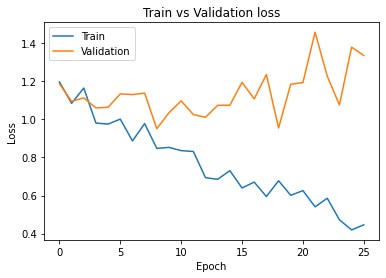

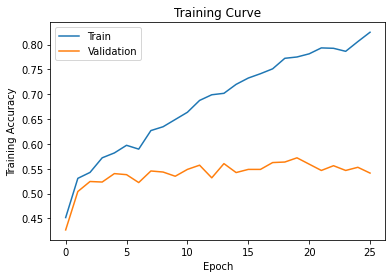

Now training weight_decay:  0.0001  lr:  0.01  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.388435; valid loss 1.374665; Train Acc 0.256757; Val Acc 0.240466
iteration 3; train loss 1.387867; valid loss 1.370459; Train Acc 0.246423; Val Acc 0.254237
iteration 5; train loss 1.384313; valid loss 1.387176; Train Acc 0.245363; Val Acc 0.252119
iteration 7; train loss 1.399301; valid loss 1.386197; Train Acc 0.250927; Val Acc 0.246822
iteration 9; train loss 1.384747; valid loss 1.406434; Train Acc 0.250397; Val Acc 0.248941
iteration 11; train loss 1.390323; valid loss 1.389134; Train Acc 0.253842; Val Acc 0.234110
iteration 13; train loss 1.382814; valid loss 1.394595; Train Acc 0.253842; Val Acc 0.234110
iteration 15; train loss 1.394720; valid loss 1.424136; Train Acc 0.250397; Val Acc 0.256356
iteration 17; train loss 1.392682; valid loss 1.390054; Train Acc 0.253842; Val Acc 0.234110
iteration 19; train loss 1.431461; valid loss 1.395777; Train Acc

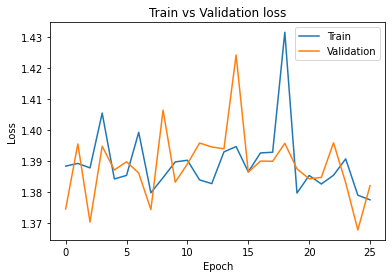

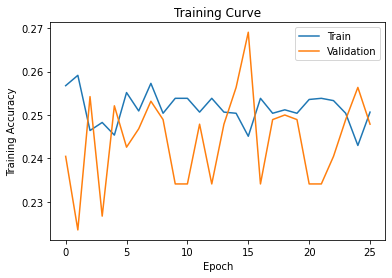

Now training weight_decay:  0.0001  lr:  0.01  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.396233; valid loss 1.388866; Train Acc 0.248808; Val Acc 0.244703
iteration 3; train loss 1.385356; valid loss 1.386705; Train Acc 0.254107; Val Acc 0.243644
iteration 5; train loss 1.386535; valid loss 1.383850; Train Acc 0.259671; Val Acc 0.247881
iteration 7; train loss 1.388046; valid loss 1.387918; Train Acc 0.241388; Val Acc 0.248941
iteration 9; train loss 1.387809; valid loss 1.388102; Train Acc 0.250397; Val Acc 0.248941
iteration 11; train loss 1.385630; valid loss 1.390782; Train Acc 0.253842; Val Acc 0.234110
iteration 13; train loss 1.383672; valid loss 1.388590; Train Acc 0.253842; Val Acc 0.234110
iteration 15; train loss 1.392049; valid loss 1.385618; Train Acc 0.250662; Val Acc 0.247881
iteration 17; train loss 1.387476; valid loss 1.386974; Train Acc 0.253842; Val Acc 0.234110
iteration 19; train loss 1.386230; valid loss 1.381964; Train Acc

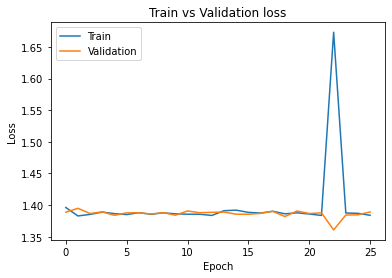

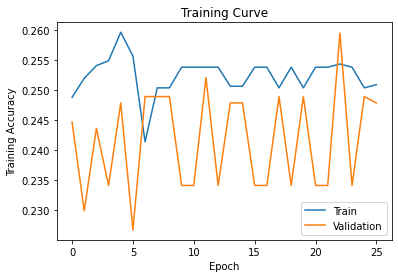

Now training weight_decay:  0.0001  lr:  0.01  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.405911; valid loss 1.384975; Train Acc 0.250927; Val Acc 0.253178
iteration 3; train loss 1.384096; valid loss 1.390182; Train Acc 0.250927; Val Acc 0.223517


KeyboardInterrupt: ignored

In [ ]:
weight_decay_list = [0.001, 0.0001]
lr_list = [0.01, 0.005, 0.001,0.0005]
batch_size_list = [32, 64, 128, 256]
record = {}
for weight_decay in weight_decay_list:
  for lr in lr_list:
    for batch_size in batch_size_list:
      print("Now training weight_decay: ", weight_decay, " lr: ", lr, " batch size: ", batch_size)
      use_cuda = True
      alex_net = CNNClassifier_alex_withdropout()
      if use_cuda and torch.cuda.is_available():
        alex_net.cuda()          
        print('CUDA is available!  Training on GPU ...')
      else:
        print('CUDA is not available.  Training on CPU ...') 
      val_acc = train(alex_net, train_alex_path, valid_alex_path,  batch_size = batch_size , learning_rate= lr ,num_epochs = 26, weight_decay= weight_decay)
      best_val = max(val_acc)
      name = "lr"+str(lr)+"bs"+str(batch_size)+"wd"+str(weight_decay)
      record[name] = best_val
print(record)


In [ ]:
torch.manual_seed(1) # set the random seed

class CNNClassifier_alex_withdropout1(nn.Module):
    def __init__(self):
        super(CNNClassifier_alex_withdropout1, self).__init__()
        self.name = 'Alex_dropout0.2'
        self.conv1 = nn.Conv2d(256, 120, 5, padding = 2) #in_channels, out_chanels, kernel_size
        #((224-4)/2-4)/2 
        self.dropout2d = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear(120*6*6, 500) #in_channels, out_chanels, kernel_size
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 4)
        self.dropout1 = nn.Dropout(0.2) 
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1(self.dropout2d(x)))
        x = x.view(-1,120*6*6)
        x = F.relu(self.fc1( self.dropout1(x)))
        x = F.relu(self.fc2(self.dropout2(x)))
        x = self.fc3(self.dropout3(x))
        return x

Now training weight_decay:  0.001  lr:  0.005  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.391026; valid loss 1.383891; Train Acc 0.249338; Val Acc 0.208686
iteration 3; train loss 1.386237; valid loss 1.385817; Train Acc 0.253842; Val Acc 0.234110
iteration 5; train loss 1.385505; valid loss 1.385985; Train Acc 0.264176; Val Acc 0.270127
iteration 7; train loss 1.388959; valid loss 1.387431; Train Acc 0.249603; Val Acc 0.241525
iteration 9; train loss 1.385198; valid loss 1.395916; Train Acc 0.250397; Val Acc 0.248941
iteration 11; train loss 1.387532; valid loss 1.391777; Train Acc 0.256227; Val Acc 0.252119
iteration 13; train loss 1.383490; valid loss 1.391919; Train Acc 0.259141; Val Acc 0.240466
iteration 15; train loss 1.394438; valid loss 1.398873; Train Acc 0.251457; Val Acc 0.229873
iteration 17; train loss 1.393677; valid loss 1.391466; Train Acc 0.253842; Val Acc 0.234110
iteration 19; train loss 1.388540; valid loss 1.386717; Train Acc

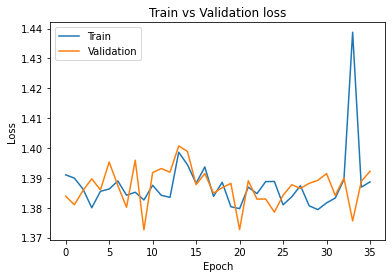

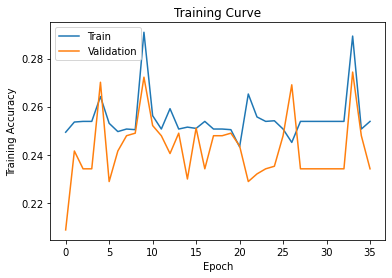

Now training weight_decay:  0.001  lr:  0.005  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.177449; valid loss 1.221151; Train Acc 0.435877; Val Acc 0.423729
iteration 3; train loss 1.194073; valid loss 1.111636; Train Acc 0.478007; Val Acc 0.437500
iteration 5; train loss 1.085170; valid loss 1.167926; Train Acc 0.508479; Val Acc 0.459746
iteration 7; train loss 0.957470; valid loss 0.951215; Train Acc 0.528617; Val Acc 0.491525
iteration 9; train loss 0.902492; valid loss 1.186170; Train Acc 0.535241; Val Acc 0.475636
iteration 11; train loss 1.300057; valid loss 1.255478; Train Acc 0.390832; Val Acc 0.348517
iteration 13; train loss 1.124477; valid loss 1.181271; Train Acc 0.426868; Val Acc 0.377119
iteration 15; train loss 1.034313; valid loss 1.271628; Train Acc 0.477477; Val Acc 0.441737
iteration 17; train loss 1.186119; valid loss 1.148399; Train Acc 0.480922; Val Acc 0.427966
iteration 19; train loss 1.132561; valid loss 1.222567; Train Acc

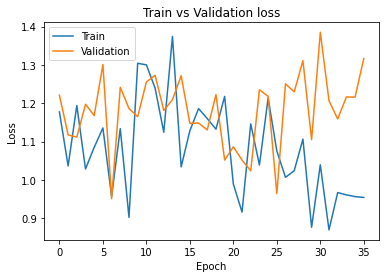

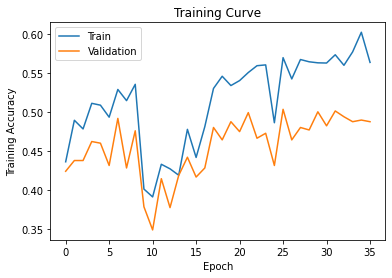

Now training weight_decay:  0.001  lr:  0.005  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.187771; valid loss 1.266583; Train Acc 0.373609; Val Acc 0.365466
iteration 3; train loss 1.189655; valid loss 1.150078; Train Acc 0.463169; Val Acc 0.423729
iteration 5; train loss 1.036861; valid loss 1.067498; Train Acc 0.524907; Val Acc 0.478814
iteration 7; train loss 1.015063; valid loss 1.044431; Train Acc 0.547695; Val Acc 0.479873
iteration 9; train loss 1.003034; valid loss 1.126057; Train Acc 0.554319; Val Acc 0.476695
iteration 11; train loss 4.439179; valid loss 3.630454; Train Acc 0.381028; Val Acc 0.345339
iteration 13; train loss 0.962035; valid loss 1.201505; Train Acc 0.541335; Val Acc 0.485169
iteration 15; train loss 0.912912; valid loss 0.997046; Train Acc 0.569687; Val Acc 0.507415
iteration 17; train loss 1.040843; valid loss 1.153912; Train Acc 0.578696; Val Acc 0.512712
iteration 19; train loss 1.055431; valid loss 1.107894; Train Ac

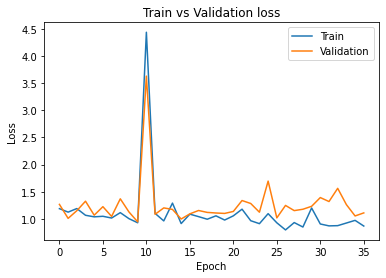

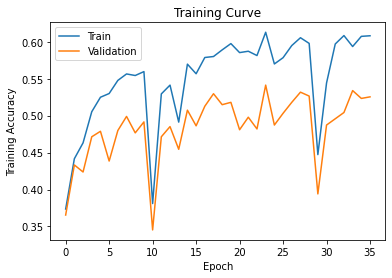

Now training weight_decay:  0.001  lr:  0.005  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.316308; valid loss 1.300230; Train Acc 0.377054; Val Acc 0.355932
iteration 3; train loss 1.202891; valid loss 1.073303; Train Acc 0.476683; Val Acc 0.486229
iteration 5; train loss 1.043298; valid loss 1.005105; Train Acc 0.538951; Val Acc 0.503178
iteration 7; train loss 0.950763; valid loss 1.198666; Train Acc 0.556174; Val Acc 0.500000
iteration 9; train loss 1.022254; valid loss 1.063596; Train Acc 0.563063; Val Acc 0.504237
iteration 11; train loss 0.895174; valid loss 1.216467; Train Acc 0.584791; Val Acc 0.495763
iteration 13; train loss 1.087547; valid loss 1.124818; Train Acc 0.506094; Val Acc 0.453390
iteration 15; train loss 0.875150; valid loss 1.164697; Train Acc 0.601219; Val Acc 0.496822
iteration 17; train loss 0.960928; valid loss 1.176555; Train Acc 0.595919; Val Acc 0.519068
iteration 19; train loss 0.862806; valid loss 1.018092; Train Ac

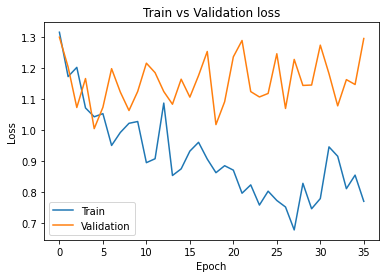

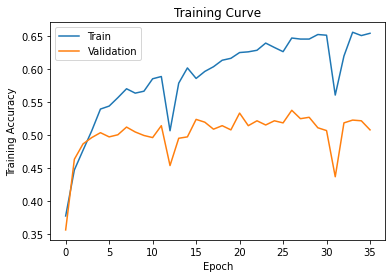

Now training weight_decay:  0.001  lr:  0.001  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.162271; valid loss 1.147759; Train Acc 0.559618; Val Acc 0.532839
iteration 3; train loss 0.997766; valid loss 1.019325; Train Acc 0.582406; Val Acc 0.523305
iteration 5; train loss 0.928609; valid loss 1.216058; Train Acc 0.579226; Val Acc 0.518008
iteration 7; train loss 0.603774; valid loss 0.701576; Train Acc 0.680710; Val Acc 0.563559
iteration 9; train loss 0.489865; valid loss 1.019737; Train Acc 0.710122; Val Acc 0.563559
iteration 11; train loss 0.676806; valid loss 0.882773; Train Acc 0.723370; Val Acc 0.569915
iteration 13; train loss 0.364768; valid loss 1.014398; Train Acc 0.740859; Val Acc 0.552966
iteration 15; train loss 0.523254; valid loss 1.233061; Train Acc 0.763116; Val Acc 0.564619
iteration 17; train loss 0.584506; valid loss 0.878825; Train Acc 0.778219; Val Acc 0.569915
iteration 19; train loss 0.320308; valid loss 1.883961; Train Acc

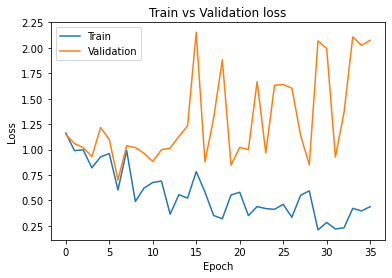

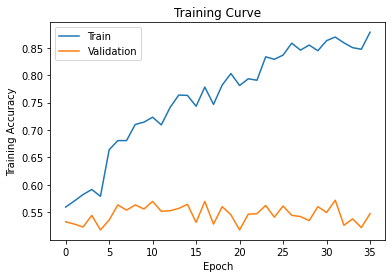

Now training weight_decay:  0.001  lr:  0.001  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.126121; valid loss 0.987624; Train Acc 0.546635; Val Acc 0.523305
iteration 3; train loss 1.077005; valid loss 1.069377; Train Acc 0.625861; Val Acc 0.575212
iteration 5; train loss 0.821384; valid loss 0.965766; Train Acc 0.643614; Val Acc 0.540254
iteration 7; train loss 0.584394; valid loss 0.833708; Train Acc 0.711977; Val Acc 0.590042
iteration 9; train loss 0.586369; valid loss 0.914771; Train Acc 0.766826; Val Acc 0.579449
iteration 11; train loss 0.424008; valid loss 1.128191; Train Acc 0.798092; Val Acc 0.583686
iteration 13; train loss 0.317709; valid loss 1.333796; Train Acc 0.828564; Val Acc 0.587924
iteration 15; train loss 0.343645; valid loss 1.203479; Train Acc 0.873079; Val Acc 0.599576
iteration 17; train loss 0.538620; valid loss 1.273074; Train Acc 0.873079; Val Acc 0.545551
iteration 19; train loss 0.286233; valid loss 1.942711; Train Acc

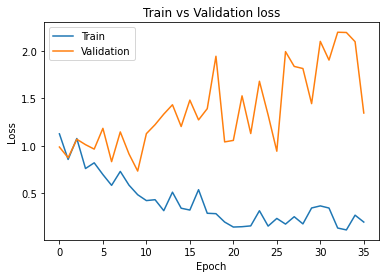

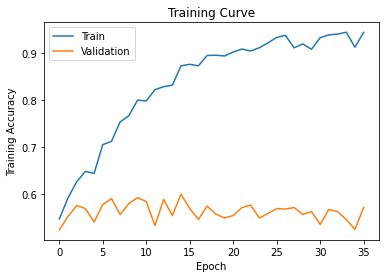

Now training weight_decay:  0.001  lr:  0.001  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.092686; valid loss 1.155530; Train Acc 0.536301; Val Acc 0.508475
iteration 3; train loss 1.049105; valid loss 0.989093; Train Acc 0.615792; Val Acc 0.545551
iteration 5; train loss 0.837754; valid loss 0.941321; Train Acc 0.653153; Val Acc 0.579449
iteration 7; train loss 0.608082; valid loss 0.985691; Train Acc 0.729730; Val Acc 0.564619
iteration 9; train loss 0.483148; valid loss 1.059209; Train Acc 0.779809; Val Acc 0.595339
iteration 11; train loss 0.526679; valid loss 0.973317; Train Acc 0.805776; Val Acc 0.580508
iteration 13; train loss 0.310211; valid loss 1.410372; Train Acc 0.833598; Val Acc 0.573093
iteration 15; train loss 0.329874; valid loss 1.570933; Train Acc 0.885798; Val Acc 0.523305
iteration 17; train loss 0.283589; valid loss 1.669194; Train Acc 0.874934; Val Acc 0.547669
iteration 19; train loss 0.389813; valid loss 2.183008; Train Ac

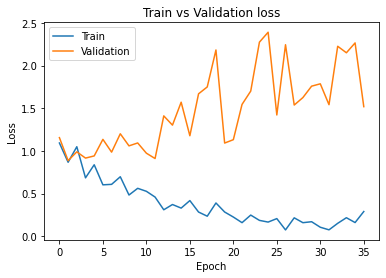

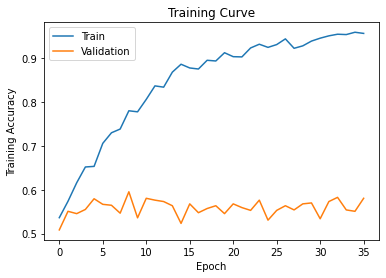

Now training weight_decay:  0.001  lr:  0.001  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.159974; valid loss 1.145631; Train Acc 0.482247; Val Acc 0.456568
iteration 3; train loss 1.080517; valid loss 1.074377; Train Acc 0.566508; Val Acc 0.533898
iteration 5; train loss 0.893151; valid loss 0.986654; Train Acc 0.607048; Val Acc 0.562500
iteration 7; train loss 0.791629; valid loss 1.092059; Train Acc 0.653153; Val Acc 0.564619
iteration 9; train loss 0.728534; valid loss 0.904950; Train Acc 0.695813; Val Acc 0.569915
iteration 11; train loss 0.605978; valid loss 1.141682; Train Acc 0.738739; Val Acc 0.580508
iteration 13; train loss 0.495866; valid loss 1.124902; Train Acc 0.774775; Val Acc 0.550847
iteration 15; train loss 0.500711; valid loss 1.234696; Train Acc 0.799152; Val Acc 0.554025
iteration 17; train loss 0.425310; valid loss 1.398150; Train Acc 0.847377; Val Acc 0.561441
iteration 19; train loss 0.500166; valid loss 1.109906; Train Ac

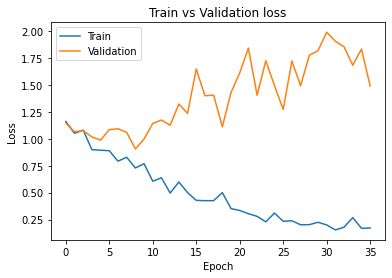

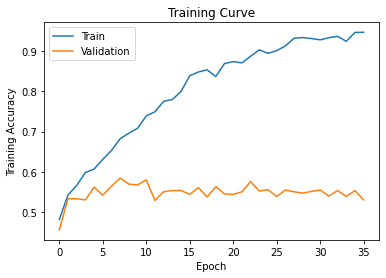

Now training weight_decay:  0.001  lr:  0.0005  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.088054; valid loss 1.061449; Train Acc 0.551669; Val Acc 0.529661
iteration 3; train loss 0.905714; valid loss 1.034798; Train Acc 0.590090; Val Acc 0.525424
iteration 5; train loss 0.819758; valid loss 1.084040; Train Acc 0.669051; Val Acc 0.574153
iteration 7; train loss 0.487535; valid loss 0.975531; Train Acc 0.775040; Val Acc 0.558263
iteration 9; train loss 0.518785; valid loss 0.725719; Train Acc 0.827769; Val Acc 0.601695
iteration 11; train loss 0.457491; valid loss 1.161876; Train Acc 0.869899; Val Acc 0.597458
iteration 13; train loss 0.209828; valid loss 2.277451; Train Acc 0.879703; Val Acc 0.546610
iteration 15; train loss 0.349362; valid loss 1.480373; Train Acc 0.904610; Val Acc 0.582627
iteration 17; train loss 0.100253; valid loss 1.361081; Train Acc 0.923953; Val Acc 0.605932
iteration 19; train loss 0.122027; valid loss 2.062717; Train Ac

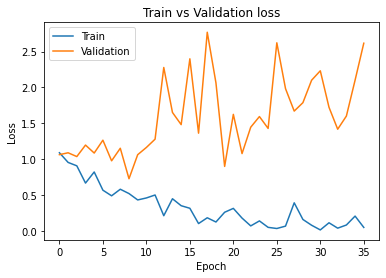

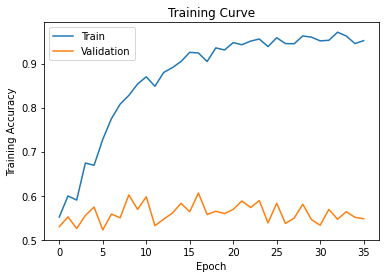

Now training weight_decay:  0.001  lr:  0.0005  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.153786; valid loss 1.011426; Train Acc 0.552199; Val Acc 0.520127
iteration 3; train loss 1.033593; valid loss 1.125140; Train Acc 0.654213; Val Acc 0.577331
iteration 5; train loss 0.642209; valid loss 0.981898; Train Acc 0.712507; Val Acc 0.568856
iteration 7; train loss 0.427522; valid loss 0.821649; Train Acc 0.807896; Val Acc 0.598517
iteration 9; train loss 0.347789; valid loss 0.914774; Train Acc 0.863010; Val Acc 0.580508
iteration 11; train loss 0.298907; valid loss 1.479508; Train Acc 0.860890; Val Acc 0.565678
iteration 13; train loss 0.086903; valid loss 1.421088; Train Acc 0.899311; Val Acc 0.564619
iteration 15; train loss 0.253354; valid loss 1.670451; Train Acc 0.927398; Val Acc 0.570975
iteration 17; train loss 0.220279; valid loss 1.393520; Train Acc 0.945946; Val Acc 0.588983
iteration 19; train loss 0.154024; valid loss 1.727994; Train Ac

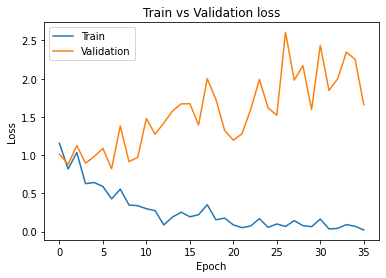

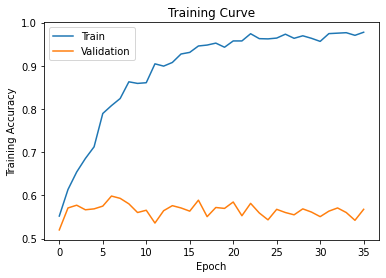

Now training weight_decay:  0.001  lr:  0.0005  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.117773; valid loss 1.095081; Train Acc 0.547960; Val Acc 0.536017
iteration 3; train loss 1.040169; valid loss 1.039090; Train Acc 0.644674; Val Acc 0.568856
iteration 5; train loss 0.797544; valid loss 0.930595; Train Acc 0.674086; Val Acc 0.579449
iteration 7; train loss 0.435945; valid loss 1.016916; Train Acc 0.797827; Val Acc 0.578390
iteration 9; train loss 0.328403; valid loss 0.976253; Train Acc 0.858241; Val Acc 0.598517
iteration 11; train loss 0.239406; valid loss 0.972822; Train Acc 0.888712; Val Acc 0.567797
iteration 13; train loss 0.177784; valid loss 1.206749; Train Acc 0.925278; Val Acc 0.591102
iteration 15; train loss 0.276896; valid loss 1.414243; Train Acc 0.936672; Val Acc 0.536017
iteration 17; train loss 0.106289; valid loss 1.468760; Train Acc 0.959989; Val Acc 0.561441
iteration 19; train loss 0.166876; valid loss 1.991737; Train A

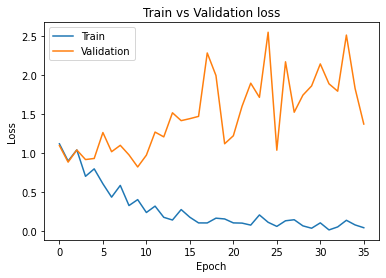

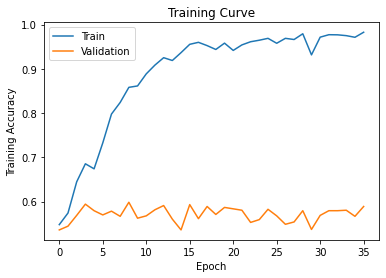

Now training weight_decay:  0.001  lr:  0.0005  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.202238; valid loss 1.209801; Train Acc 0.434552; Val Acc 0.422669
iteration 3; train loss 1.069190; valid loss 1.003188; Train Acc 0.581876; Val Acc 0.548729
iteration 5; train loss 0.905740; valid loss 0.998601; Train Acc 0.616587; Val Acc 0.572034
iteration 7; train loss 0.725670; valid loss 1.019701; Train Acc 0.691574; Val Acc 0.604873
iteration 9; train loss 0.558087; valid loss 0.846604; Train Acc 0.785374; Val Acc 0.617585
iteration 11; train loss 0.456059; valid loss 1.168877; Train Acc 0.844197; Val Acc 0.600636
iteration 13; train loss 0.301879; valid loss 1.115333; Train Acc 0.871224; Val Acc 0.588983
iteration 15; train loss 0.301276; valid loss 1.270169; Train Acc 0.899046; Val Acc 0.566737
iteration 17; train loss 0.179104; valid loss 1.593044; Train Acc 0.938792; Val Acc 0.579449
iteration 19; train loss 0.150488; valid loss 1.484326; Train A

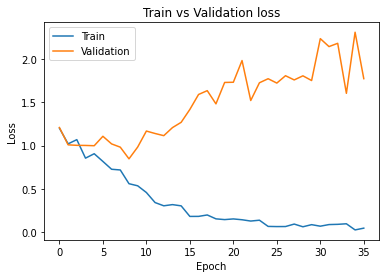

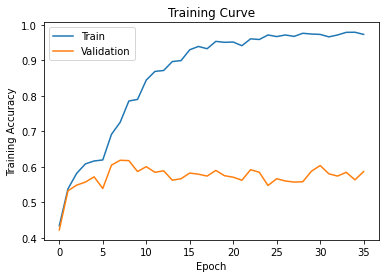

Now training weight_decay:  0.001  lr:  0.0001  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.163888; valid loss 1.113658; Train Acc 0.556174; Val Acc 0.536017
iteration 3; train loss 0.903858; valid loss 1.042887; Train Acc 0.616057; Val Acc 0.548729
iteration 5; train loss 0.682193; valid loss 0.920075; Train Acc 0.688924; Val Acc 0.584746
iteration 7; train loss 0.676555; valid loss 0.812550; Train Acc 0.753842; Val Acc 0.551907
iteration 9; train loss 0.261927; valid loss 0.557278; Train Acc 0.873874; Val Acc 0.593220
iteration 11; train loss 0.435301; valid loss 1.125069; Train Acc 0.895601; Val Acc 0.565678
iteration 13; train loss 0.138685; valid loss 1.775303; Train Acc 0.934817; Val Acc 0.601695
iteration 15; train loss 0.205050; valid loss 1.557249; Train Acc 0.939852; Val Acc 0.582627
iteration 17; train loss 0.131159; valid loss 1.661638; Train Acc 0.961049; Val Acc 0.565678
iteration 19; train loss 0.040886; valid loss 1.657504; Train Ac

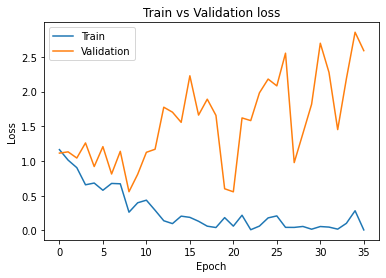

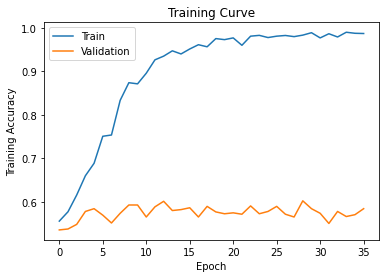

Now training weight_decay:  0.001  lr:  0.0001  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.085931; valid loss 1.005007; Train Acc 0.534711; Val Acc 0.520127
iteration 3; train loss 1.102253; valid loss 1.083537; Train Acc 0.620032; Val Acc 0.567797
iteration 5; train loss 0.831810; valid loss 0.902460; Train Acc 0.656333; Val Acc 0.585805
iteration 7; train loss 0.614371; valid loss 0.718172; Train Acc 0.751192; Val Acc 0.603814
iteration 9; train loss 0.517161; valid loss 0.823215; Train Acc 0.804981; Val Acc 0.593220
iteration 11; train loss 0.391664; valid loss 1.014667; Train Acc 0.837308; Val Acc 0.569915
iteration 13; train loss 0.193796; valid loss 1.020570; Train Acc 0.896661; Val Acc 0.609110
iteration 15; train loss 0.262257; valid loss 1.226150; Train Acc 0.926868; Val Acc 0.586864
iteration 17; train loss 0.227678; valid loss 1.302315; Train Acc 0.946476; Val Acc 0.578390
iteration 19; train loss 0.134497; valid loss 1.498778; Train Ac

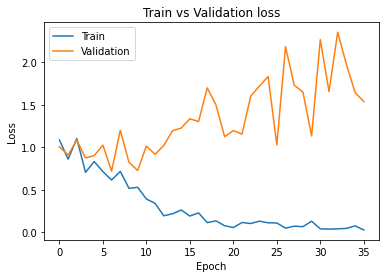

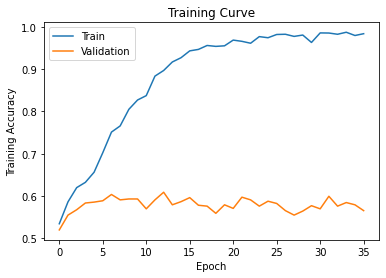

Now training weight_decay:  0.001  lr:  0.0001  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.104866; valid loss 1.064505; Train Acc 0.519343; Val Acc 0.478814
iteration 3; train loss 1.086001; valid loss 1.023517; Train Acc 0.594595; Val Acc 0.565678
iteration 5; train loss 0.912224; valid loss 0.884789; Train Acc 0.639905; Val Acc 0.588983
iteration 7; train loss 0.644927; valid loss 0.849620; Train Acc 0.704028; Val Acc 0.570975
iteration 9; train loss 0.658231; valid loss 0.783819; Train Acc 0.736884; Val Acc 0.580508
iteration 11; train loss 0.564019; valid loss 0.887213; Train Acc 0.774775; Val Acc 0.599576
iteration 13; train loss 0.357333; valid loss 0.962146; Train Acc 0.810546; Val Acc 0.596398
iteration 15; train loss 0.514460; valid loss 1.116993; Train Acc 0.846847; Val Acc 0.578390
iteration 17; train loss 0.341525; valid loss 1.157017; Train Acc 0.885268; Val Acc 0.583686
iteration 19; train loss 0.303338; valid loss 1.127926; Train A

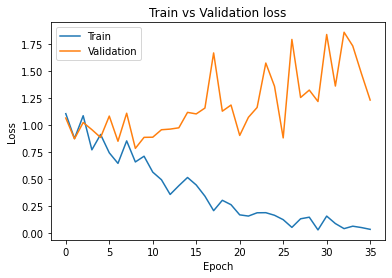

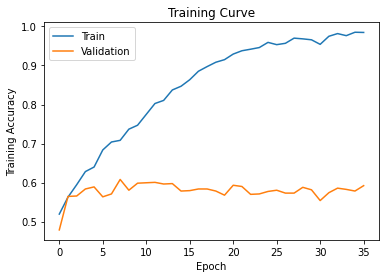

Now training weight_decay:  0.001  lr:  0.0001  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.179048; valid loss 1.182058; Train Acc 0.473238; Val Acc 0.443856
iteration 3; train loss 1.103182; valid loss 1.052026; Train Acc 0.577107; Val Acc 0.546610
iteration 5; train loss 0.940571; valid loss 1.004262; Train Acc 0.591415; Val Acc 0.564619
iteration 7; train loss 0.832631; valid loss 1.039364; Train Acc 0.640964; Val Acc 0.587924
iteration 9; train loss 0.847562; valid loss 0.810003; Train Acc 0.662957; Val Acc 0.584746
iteration 11; train loss 0.725133; valid loss 1.059795; Train Acc 0.689189; Val Acc 0.574153
iteration 13; train loss 0.602588; valid loss 0.929924; Train Acc 0.737414; Val Acc 0.579449
iteration 15; train loss 0.630175; valid loss 0.959883; Train Acc 0.761261; Val Acc 0.600636
iteration 17; train loss 0.596146; valid loss 1.015839; Train Acc 0.790408; Val Acc 0.588983
iteration 19; train loss 0.509159; valid loss 0.877597; Train A

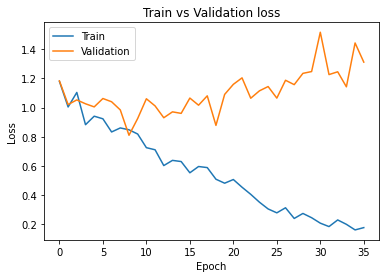

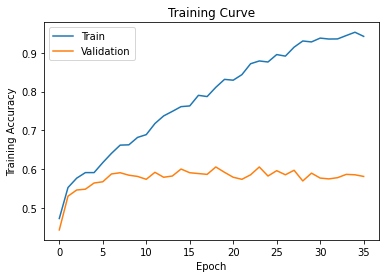

Now training weight_decay:  0.001  lr:  5e-05  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.154227; valid loss 1.095919; Train Acc 0.540276; Val Acc 0.530720
iteration 3; train loss 0.930704; valid loss 0.996626; Train Acc 0.601749; Val Acc 0.566737
iteration 5; train loss 0.824952; valid loss 0.874399; Train Acc 0.641494; Val Acc 0.586864
iteration 7; train loss 0.639823; valid loss 0.704248; Train Acc 0.709592; Val Acc 0.593220
iteration 9; train loss 0.611750; valid loss 0.708774; Train Acc 0.749338; Val Acc 0.597458
iteration 11; train loss 0.584192; valid loss 0.823553; Train Acc 0.788553; Val Acc 0.581568
iteration 13; train loss 0.312210; valid loss 1.239846; Train Acc 0.823529; Val Acc 0.600636
iteration 15; train loss 0.385823; valid loss 1.338451; Train Acc 0.865130; Val Acc 0.598517
iteration 17; train loss 0.526040; valid loss 0.925261; Train Acc 0.890567; Val Acc 0.583686
iteration 19; train loss 0.117187; valid loss 1.628730; Train Acc

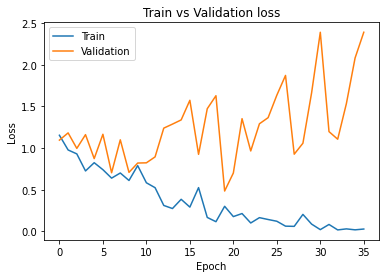

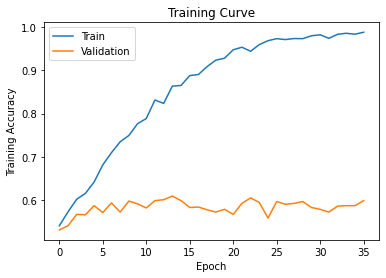

Now training weight_decay:  0.001  lr:  5e-05  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.149817; valid loss 1.072954; Train Acc 0.518548; Val Acc 0.497881
iteration 3; train loss 1.186050; valid loss 1.059236; Train Acc 0.590355; Val Acc 0.556144
iteration 5; train loss 0.923637; valid loss 0.955886; Train Acc 0.606518; Val Acc 0.578390
iteration 7; train loss 0.739753; valid loss 0.750439; Train Acc 0.667197; Val Acc 0.601695
iteration 9; train loss 0.723167; valid loss 0.821021; Train Acc 0.701643; Val Acc 0.591102
iteration 11; train loss 0.660000; valid loss 0.858234; Train Acc 0.729995; Val Acc 0.581568
iteration 13; train loss 0.441159; valid loss 1.038913; Train Acc 0.762056; Val Acc 0.584746
iteration 15; train loss 0.595424; valid loss 1.051426; Train Acc 0.796237; Val Acc 0.583686
iteration 17; train loss 0.567565; valid loss 0.894131; Train Acc 0.832273; Val Acc 0.591102
iteration 19; train loss 0.423277; valid loss 1.154706; Train Acc

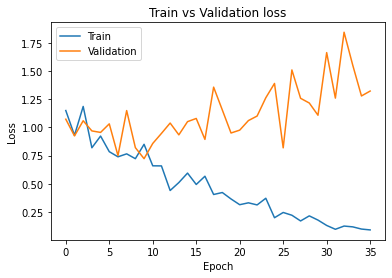

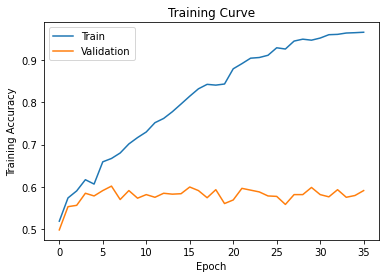

Now training weight_decay:  0.001  lr:  5e-05  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.231647; valid loss 1.207379; Train Acc 0.483572; Val Acc 0.460805
iteration 3; train loss 1.197469; valid loss 1.092521; Train Acc 0.557234; Val Acc 0.515890
iteration 5; train loss 1.000321; valid loss 0.949968; Train Acc 0.597774; Val Acc 0.576271
iteration 7; train loss 0.778886; valid loss 0.864561; Train Acc 0.629306; Val Acc 0.557203
iteration 9; train loss 0.785549; valid loss 0.830044; Train Acc 0.662162; Val Acc 0.581568
iteration 11; train loss 0.805817; valid loss 0.875441; Train Acc 0.686275; Val Acc 0.599576
iteration 13; train loss 0.581553; valid loss 0.952633; Train Acc 0.677530; Val Acc 0.565678
iteration 15; train loss 0.785618; valid loss 1.049583; Train Acc 0.730260; Val Acc 0.573093
iteration 17; train loss 0.725459; valid loss 0.997007; Train Acc 0.760201; Val Acc 0.587924
iteration 19; train loss 0.662231; valid loss 1.091776; Train Ac

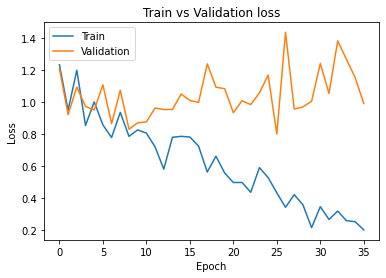

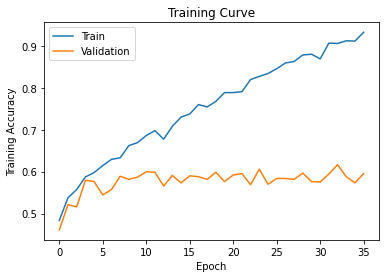

Now training weight_decay:  0.001  lr:  5e-05  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.308869; valid loss 1.302941; Train Acc 0.450450; Val Acc 0.423729
iteration 3; train loss 1.122185; valid loss 1.107251; Train Acc 0.544515; Val Acc 0.507415
iteration 5; train loss 0.967490; valid loss 1.007698; Train Acc 0.565713; Val Acc 0.561441
iteration 7; train loss 0.898984; valid loss 1.082551; Train Acc 0.612083; Val Acc 0.576271
iteration 9; train loss 0.933260; valid loss 0.877068; Train Acc 0.613937; Val Acc 0.567797
iteration 11; train loss 0.839692; valid loss 1.046592; Train Acc 0.647059; Val Acc 0.581568
iteration 13; train loss 0.784022; valid loss 0.919666; Train Acc 0.658188; Val Acc 0.587924
iteration 15; train loss 0.807437; valid loss 0.963896; Train Acc 0.675146; Val Acc 0.602754
iteration 17; train loss 0.824225; valid loss 0.974002; Train Acc 0.695019; Val Acc 0.599576
iteration 19; train loss 0.786978; valid loss 0.876575; Train Ac

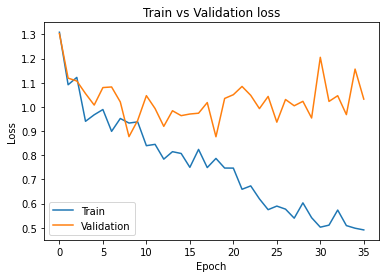

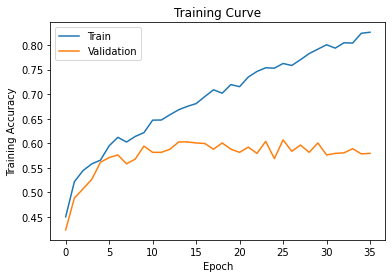

Now training weight_decay:  0.01  lr:  0.005  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.307622; valid loss 1.357593; Train Acc 0.347112; Val Acc 0.346398
iteration 3; train loss 1.101920; valid loss 1.126328; Train Acc 0.465819; Val Acc 0.424788
iteration 5; train loss 1.293216; valid loss 1.619783; Train Acc 0.487811; Val Acc 0.496822
iteration 7; train loss 2.048670; valid loss 2.094326; Train Acc 0.247483; Val Acc 0.271186
iteration 9; train loss 1.008652; valid loss 1.043004; Train Acc 0.516163; Val Acc 0.493644
iteration 11; train loss 1.235755; valid loss 0.929718; Train Acc 0.480657; Val Acc 0.436441
iteration 13; train loss 1.024648; valid loss 1.169034; Train Acc 0.494171; Val Acc 0.473517
iteration 15; train loss 0.973432; valid loss 1.210385; Train Acc 0.514573; Val Acc 0.454449
iteration 17; train loss 1.291952; valid loss 1.127822; Train Acc 0.487811; Val Acc 0.454449
iteration 19; train loss 1.113581; valid loss 1.343343; Train Acc 

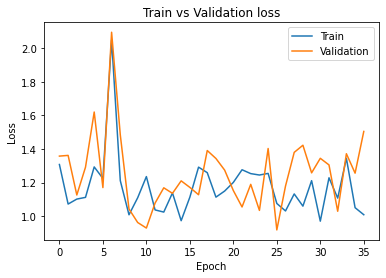

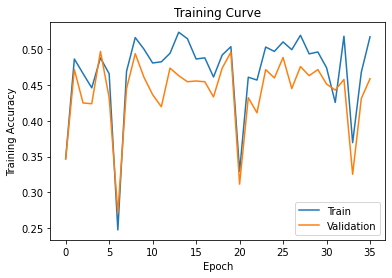

Now training weight_decay:  0.01  lr:  0.005  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.197203; valid loss 1.007764; Train Acc 0.517753; Val Acc 0.502119
iteration 3; train loss 1.144027; valid loss 1.177045; Train Acc 0.546900; Val Acc 0.526483
iteration 5; train loss 1.021714; valid loss 1.024397; Train Acc 0.549550; Val Acc 0.520127
iteration 7; train loss 1.249475; valid loss 1.236434; Train Acc 0.374404; Val Acc 0.350636
iteration 9; train loss 0.995189; valid loss 1.036897; Train Acc 0.542660; Val Acc 0.487288
iteration 11; train loss 0.981778; valid loss 0.987947; Train Acc 0.548490; Val Acc 0.497881
iteration 13; train loss 0.990587; valid loss 1.039940; Train Acc 0.553524; Val Acc 0.484110
iteration 15; train loss 1.103188; valid loss 1.089307; Train Acc 0.527292; Val Acc 0.497881
iteration 17; train loss 1.228572; valid loss 1.169236; Train Acc 0.485427; Val Acc 0.449153
iteration 19; train loss 1.110551; valid loss 1.200043; Train Acc 

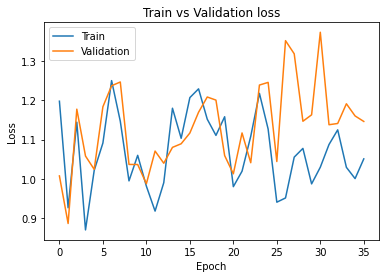

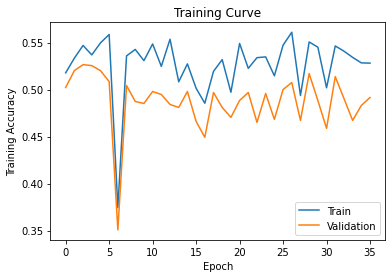

Now training weight_decay:  0.01  lr:  0.005  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.355592; valid loss 1.327153; Train Acc 0.366720; Val Acc 0.331568
iteration 3; train loss 1.138304; valid loss 1.229025; Train Acc 0.521463; Val Acc 0.504237
iteration 5; train loss 1.083148; valid loss 1.046552; Train Acc 0.542130; Val Acc 0.516949
iteration 7; train loss 0.972994; valid loss 1.013515; Train Acc 0.559618; Val Acc 0.507415
iteration 9; train loss 1.006528; valid loss 0.986310; Train Acc 0.555644; Val Acc 0.530720
iteration 11; train loss 1.077090; valid loss 1.058946; Train Acc 0.554584; Val Acc 0.512712
iteration 13; train loss 0.937386; valid loss 1.197873; Train Acc 0.516958; Val Acc 0.457627
iteration 15; train loss 1.047257; valid loss 1.005589; Train Acc 0.561473; Val Acc 0.504237
iteration 17; train loss 1.088155; valid loss 1.031638; Train Acc 0.562533; Val Acc 0.514831
iteration 19; train loss 1.077956; valid loss 1.242427; Train Acc

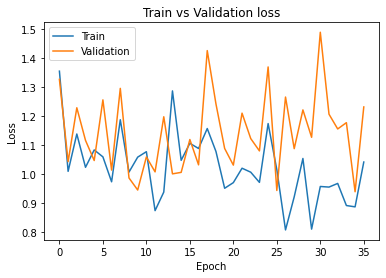

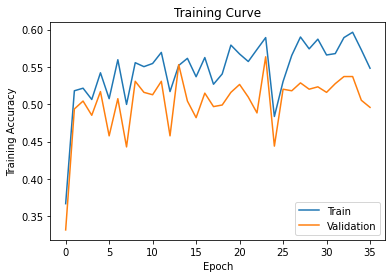

Now training weight_decay:  0.01  lr:  0.005  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.390391; valid loss 1.387451; Train Acc 0.250662; Val Acc 0.250000
iteration 3; train loss 1.278627; valid loss 1.203096; Train Acc 0.436407; Val Acc 0.415254
iteration 5; train loss 1.080459; valid loss 1.086137; Train Acc 0.525437; Val Acc 0.514831
iteration 7; train loss 0.970993; valid loss 1.190621; Train Acc 0.544515; Val Acc 0.516949
iteration 9; train loss 0.980830; valid loss 1.030398; Train Acc 0.567568; Val Acc 0.528602
iteration 11; train loss 1.035443; valid loss 1.126728; Train Acc 0.567038; Val Acc 0.508475
iteration 13; train loss 0.899604; valid loss 0.999619; Train Acc 0.605458; Val Acc 0.534958
iteration 15; train loss 1.022882; valid loss 1.161191; Train Acc 0.562003; Val Acc 0.475636
iteration 17; train loss 1.004066; valid loss 1.059466; Train Acc 0.571012; Val Acc 0.514831
iteration 19; train loss 0.978701; valid loss 0.976612; Train Acc

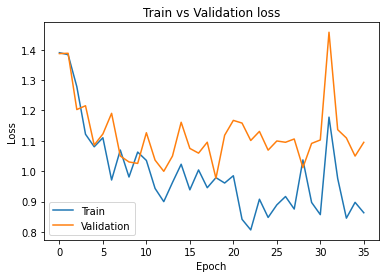

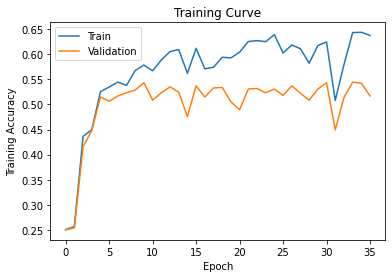

Now training weight_decay:  0.01  lr:  0.001  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.115589; valid loss 1.156554; Train Acc 0.551139; Val Acc 0.515890
iteration 3; train loss 1.050504; valid loss 1.194548; Train Acc 0.565713; Val Acc 0.521186
iteration 5; train loss 0.970751; valid loss 1.165744; Train Acc 0.541070; Val Acc 0.497881
iteration 7; train loss 0.956001; valid loss 0.831654; Train Acc 0.554319; Val Acc 0.498941
iteration 9; train loss 0.778067; valid loss 0.966450; Train Acc 0.640170; Val Acc 0.527542
iteration 11; train loss 0.725915; valid loss 0.625761; Train Acc 0.661897; Val Acc 0.538136
iteration 13; train loss 0.509279; valid loss 0.861115; Train Acc 0.683095; Val Acc 0.560381
iteration 15; train loss 0.862483; valid loss 1.066266; Train Acc 0.652358; Val Acc 0.548729
iteration 17; train loss 0.817346; valid loss 1.010107; Train Acc 0.712507; Val Acc 0.560381
iteration 19; train loss 0.838337; valid loss 1.427634; Train Acc 

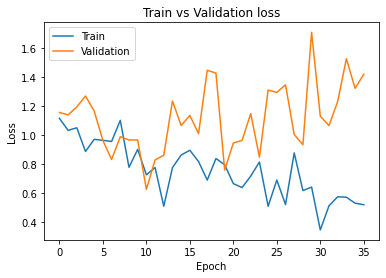

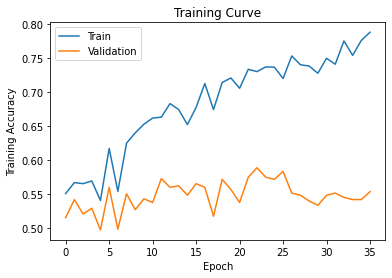

Now training weight_decay:  0.01  lr:  0.001  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.144705; valid loss 0.988724; Train Acc 0.541865; Val Acc 0.534958
iteration 3; train loss 1.166561; valid loss 1.138439; Train Acc 0.577107; Val Acc 0.529661
iteration 5; train loss 0.899675; valid loss 0.876131; Train Acc 0.607578; Val Acc 0.570975
iteration 7; train loss 0.825061; valid loss 0.897970; Train Acc 0.625331; Val Acc 0.544492
iteration 9; train loss 0.776114; valid loss 0.814977; Train Acc 0.670111; Val Acc 0.565678
iteration 11; train loss 0.619902; valid loss 0.934780; Train Acc 0.697668; Val Acc 0.566737
iteration 13; train loss 0.554559; valid loss 1.163659; Train Acc 0.720986; Val Acc 0.560381
iteration 15; train loss 0.649796; valid loss 1.071266; Train Acc 0.739534; Val Acc 0.583686
iteration 17; train loss 0.715381; valid loss 0.811162; Train Acc 0.758082; Val Acc 0.584746
iteration 19; train loss 0.686731; valid loss 1.191001; Train Acc 

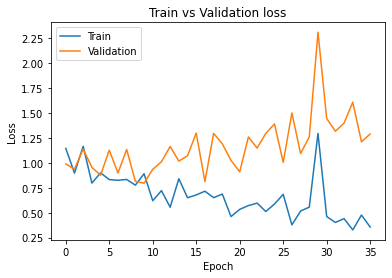

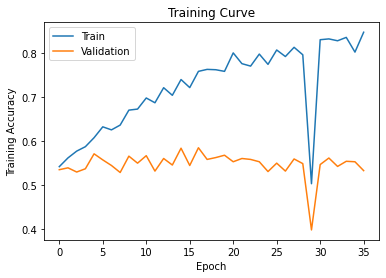

Now training weight_decay:  0.01  lr:  0.001  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.159449; valid loss 1.121447; Train Acc 0.537626; Val Acc 0.519068
iteration 3; train loss 1.083322; valid loss 1.068448; Train Acc 0.614997; Val Acc 0.565678
iteration 5; train loss 0.806774; valid loss 0.900890; Train Acc 0.611288; Val Acc 0.544492
iteration 7; train loss 0.663272; valid loss 0.890123; Train Acc 0.703763; Val Acc 0.573093
iteration 9; train loss 0.690563; valid loss 0.897205; Train Acc 0.724695; Val Acc 0.552966
iteration 11; train loss 0.606200; valid loss 1.000847; Train Acc 0.772390; Val Acc 0.576271
iteration 13; train loss 0.483300; valid loss 0.922085; Train Acc 0.775305; Val Acc 0.559322
iteration 15; train loss 0.650826; valid loss 1.191471; Train Acc 0.799682; Val Acc 0.519068
iteration 17; train loss 0.512713; valid loss 1.083465; Train Acc 0.834393; Val Acc 0.540254
iteration 19; train loss 0.438910; valid loss 1.311451; Train Acc

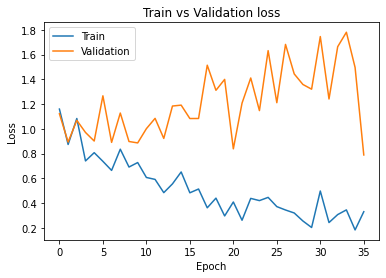

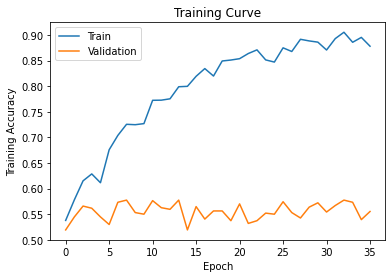

Now training weight_decay:  0.01  lr:  0.001  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.145252; valid loss 1.150179; Train Acc 0.479862; Val Acc 0.483051
iteration 3; train loss 1.135013; valid loss 1.117905; Train Acc 0.554319; Val Acc 0.532839
iteration 5; train loss 0.888350; valid loss 0.970829; Train Acc 0.611553; Val Acc 0.568856
iteration 7; train loss 0.817898; valid loss 1.085912; Train Acc 0.629306; Val Acc 0.539195
iteration 9; train loss 0.755647; valid loss 0.884456; Train Acc 0.696873; Val Acc 0.569915
iteration 11; train loss 0.734462; valid loss 1.094218; Train Acc 0.686539; Val Acc 0.559322
iteration 13; train loss 0.570279; valid loss 0.976801; Train Acc 0.747218; Val Acc 0.555085
iteration 15; train loss 0.603589; valid loss 1.002757; Train Acc 0.762851; Val Acc 0.569915
iteration 17; train loss 0.526946; valid loss 1.224136; Train Acc 0.807896; Val Acc 0.547669
iteration 19; train loss 0.508236; valid loss 0.967193; Train Acc

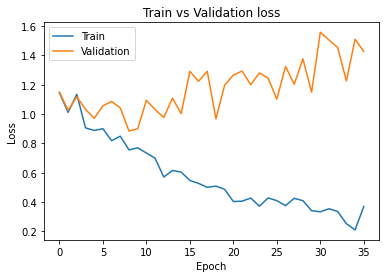

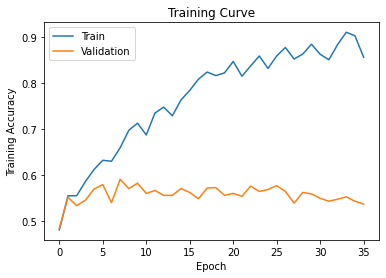

Now training weight_decay:  0.01  lr:  0.0005  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.111920; valid loss 1.056270; Train Acc 0.548225; Val Acc 0.526483
iteration 3; train loss 0.976684; valid loss 1.077706; Train Acc 0.578696; Val Acc 0.519068
iteration 5; train loss 0.881052; valid loss 1.023950; Train Acc 0.607313; Val Acc 0.554025
iteration 7; train loss 0.996191; valid loss 1.001710; Train Acc 0.627186; Val Acc 0.510593
iteration 9; train loss 0.729338; valid loss 0.657810; Train Acc 0.731320; Val Acc 0.568856
iteration 11; train loss 0.727964; valid loss 0.761614; Train Acc 0.720986; Val Acc 0.556144
iteration 13; train loss 0.399448; valid loss 1.244722; Train Acc 0.770800; Val Acc 0.549788
iteration 15; train loss 0.565775; valid loss 1.290075; Train Acc 0.787493; Val Acc 0.568856
iteration 17; train loss 0.456112; valid loss 1.177039; Train Acc 0.827239; Val Acc 0.585805
iteration 19; train loss 0.341855; valid loss 1.714299; Train Acc

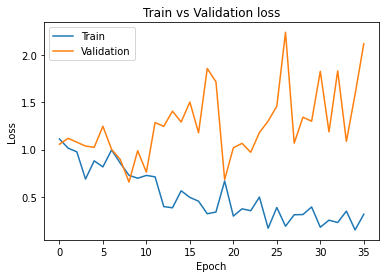

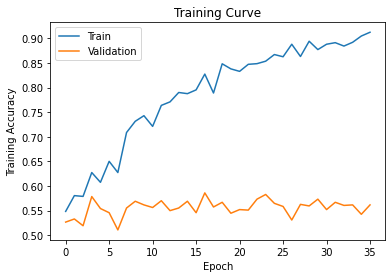

Now training weight_decay:  0.01  lr:  0.0005  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.131248; valid loss 1.015012; Train Acc 0.555909; Val Acc 0.526483
iteration 3; train loss 1.092080; valid loss 1.070323; Train Acc 0.625331; Val Acc 0.554025
iteration 5; train loss 0.824611; valid loss 0.884643; Train Acc 0.636460; Val Acc 0.561441
iteration 7; train loss 0.610651; valid loss 0.820582; Train Acc 0.697403; Val Acc 0.583686
iteration 9; train loss 0.516908; valid loss 0.932729; Train Acc 0.774245; Val Acc 0.581568
iteration 11; train loss 0.516432; valid loss 1.047354; Train Acc 0.797562; Val Acc 0.550847
iteration 13; train loss 0.343928; valid loss 1.073995; Train Acc 0.820880; Val Acc 0.588983
iteration 15; train loss 0.397481; valid loss 1.130191; Train Acc 0.858241; Val Acc 0.569915
iteration 17; train loss 0.438373; valid loss 1.327414; Train Acc 0.845257; Val Acc 0.545551
iteration 19; train loss 0.344846; valid loss 1.355102; Train Acc

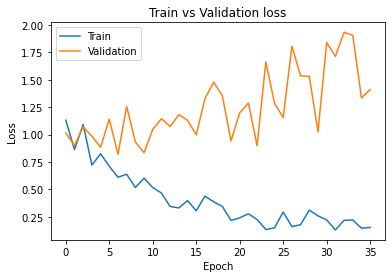

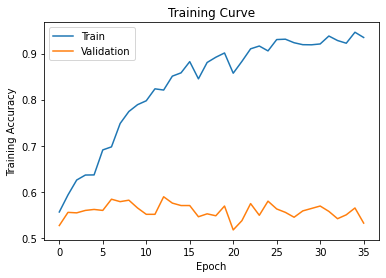

Now training weight_decay:  0.01  lr:  0.0005  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.170876; valid loss 1.120190; Train Acc 0.546370; Val Acc 0.532839
iteration 3; train loss 1.133545; valid loss 1.073435; Train Acc 0.601484; Val Acc 0.561441
iteration 5; train loss 0.834045; valid loss 0.847057; Train Acc 0.631955; Val Acc 0.566737
iteration 7; train loss 0.552312; valid loss 0.933178; Train Acc 0.730525; Val Acc 0.583686
iteration 9; train loss 0.710453; valid loss 0.904869; Train Acc 0.744038; Val Acc 0.569915
iteration 11; train loss 0.553468; valid loss 0.993610; Train Acc 0.795972; Val Acc 0.546610
iteration 13; train loss 0.308817; valid loss 1.112715; Train Acc 0.852146; Val Acc 0.594280
iteration 15; train loss 0.363021; valid loss 0.928447; Train Acc 0.881028; Val Acc 0.583686
iteration 17; train loss 0.277811; valid loss 1.058735; Train Acc 0.900371; Val Acc 0.548729
iteration 19; train loss 0.204181; valid loss 1.508799; Train Ac

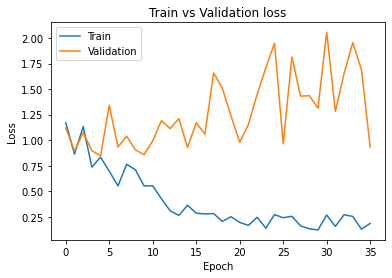

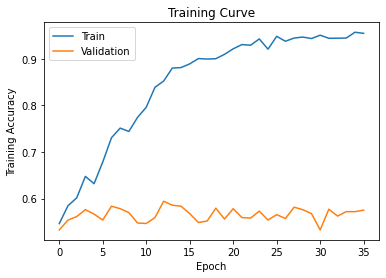

Now training weight_decay:  0.01  lr:  0.0005  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.150141; valid loss 1.141777; Train Acc 0.462374; Val Acc 0.440678
iteration 3; train loss 1.099715; valid loss 1.042943; Train Acc 0.586380; Val Acc 0.539195
iteration 5; train loss 0.887518; valid loss 0.977070; Train Acc 0.626391; Val Acc 0.563559
iteration 7; train loss 0.781989; valid loss 1.032230; Train Acc 0.680180; Val Acc 0.587924
iteration 9; train loss 0.685674; valid loss 0.805394; Train Acc 0.727610; Val Acc 0.606992
iteration 11; train loss 0.553353; valid loss 1.113510; Train Acc 0.775040; Val Acc 0.594280
iteration 13; train loss 0.394604; valid loss 0.951377; Train Acc 0.824589; Val Acc 0.578390
iteration 15; train loss 0.421915; valid loss 1.092570; Train Acc 0.874139; Val Acc 0.581568
iteration 17; train loss 0.415943; valid loss 1.186238; Train Acc 0.870164; Val Acc 0.566737
iteration 19; train loss 0.336737; valid loss 1.059977; Train Ac

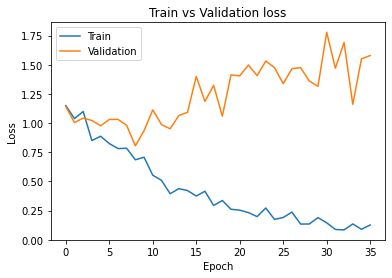

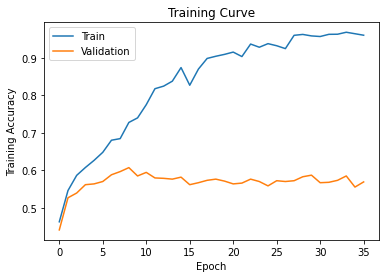

Now training weight_decay:  0.01  lr:  0.0001  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.174997; valid loss 1.109083; Train Acc 0.556174; Val Acc 0.534958
iteration 3; train loss 0.936892; valid loss 1.058752; Train Acc 0.606783; Val Acc 0.548729
iteration 5; train loss 0.752916; valid loss 0.939364; Train Acc 0.647854; Val Acc 0.561441
iteration 7; train loss 0.751562; valid loss 0.822919; Train Acc 0.718336; Val Acc 0.544492
iteration 9; train loss 0.452523; valid loss 0.579198; Train Acc 0.817435; Val Acc 0.587924
iteration 11; train loss 0.487743; valid loss 0.879955; Train Acc 0.864335; Val Acc 0.578390
iteration 13; train loss 0.191472; valid loss 1.490236; Train Acc 0.899841; Val Acc 0.600636
iteration 15; train loss 0.289546; valid loss 1.694454; Train Acc 0.908585; Val Acc 0.579449
iteration 17; train loss 0.359600; valid loss 1.107703; Train Acc 0.945151; Val Acc 0.581568
iteration 19; train loss 0.111251; valid loss 1.377132; Train Acc

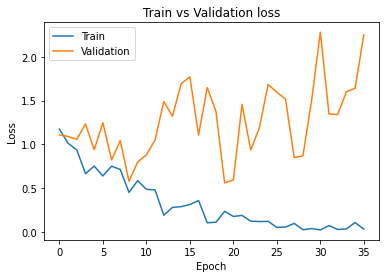

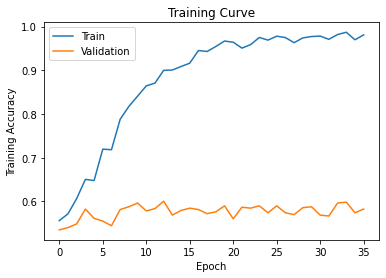

Now training weight_decay:  0.01  lr:  0.0001  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.092162; valid loss 1.002597; Train Acc 0.534711; Val Acc 0.529661
iteration 3; train loss 1.125099; valid loss 1.048227; Train Acc 0.613143; Val Acc 0.565678
iteration 5; train loss 0.869038; valid loss 0.910567; Train Acc 0.639905; Val Acc 0.576271
iteration 7; train loss 0.656905; valid loss 0.740524; Train Acc 0.727610; Val Acc 0.605932
iteration 9; train loss 0.604730; valid loss 0.806273; Train Acc 0.758347; Val Acc 0.597458
iteration 11; train loss 0.469697; valid loss 0.953066; Train Acc 0.790938; Val Acc 0.583686
iteration 13; train loss 0.306144; valid loss 1.032570; Train Acc 0.852941; Val Acc 0.611229
iteration 15; train loss 0.417060; valid loss 1.140276; Train Acc 0.884208; Val Acc 0.575212
iteration 17; train loss 0.326362; valid loss 1.024135; Train Acc 0.913090; Val Acc 0.570975
iteration 19; train loss 0.206043; valid loss 1.309817; Train Acc

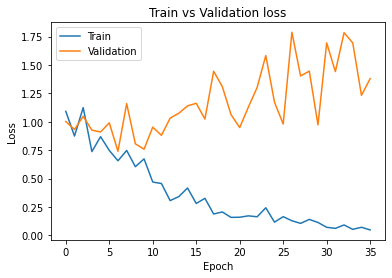

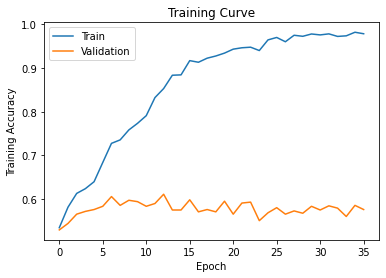

Now training weight_decay:  0.01  lr:  0.0001  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.099093; valid loss 1.065692; Train Acc 0.511394; Val Acc 0.467161
iteration 3; train loss 1.102551; valid loss 1.031260; Train Acc 0.581346; Val Acc 0.570975
iteration 5; train loss 0.932765; valid loss 0.892988; Train Acc 0.626391; Val Acc 0.587924
iteration 7; train loss 0.668804; valid loss 0.839452; Train Acc 0.683360; Val Acc 0.584746
iteration 9; train loss 0.740801; valid loss 0.780700; Train Acc 0.716746; Val Acc 0.587924
iteration 11; train loss 0.651688; valid loss 0.862384; Train Acc 0.740594; Val Acc 0.592161
iteration 13; train loss 0.397873; valid loss 0.936436; Train Acc 0.779279; Val Acc 0.604873
iteration 15; train loss 0.605125; valid loss 1.091082; Train Acc 0.804187; Val Acc 0.575212
iteration 17; train loss 0.506659; valid loss 1.001015; Train Acc 0.848172; Val Acc 0.588983
iteration 19; train loss 0.391497; valid loss 1.039033; Train Ac

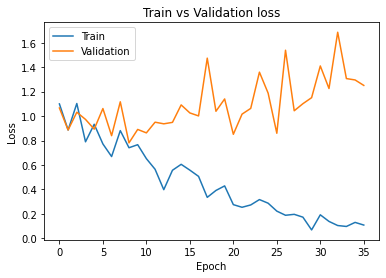

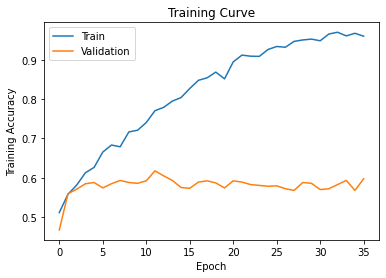

Now training weight_decay:  0.01  lr:  0.0001  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.195497; valid loss 1.196718; Train Acc 0.469793; Val Acc 0.438559
iteration 3; train loss 1.103029; valid loss 1.056665; Train Acc 0.573132; Val Acc 0.534958
iteration 5; train loss 0.946410; valid loss 1.001379; Train Acc 0.585586; Val Acc 0.561441
iteration 7; train loss 0.847089; valid loss 1.044741; Train Acc 0.632485; Val Acc 0.592161
iteration 9; train loss 0.873377; valid loss 0.825730; Train Acc 0.651563; Val Acc 0.582627
iteration 11; train loss 0.773440; valid loss 1.049005; Train Acc 0.676471; Val Acc 0.569915
iteration 13; train loss 0.661262; valid loss 0.935067; Train Acc 0.713037; Val Acc 0.584746
iteration 15; train loss 0.688194; valid loss 0.961574; Train Acc 0.736354; Val Acc 0.601695
iteration 17; train loss 0.667021; valid loss 0.983181; Train Acc 0.767356; Val Acc 0.591102
iteration 19; train loss 0.584865; valid loss 0.858597; Train Ac

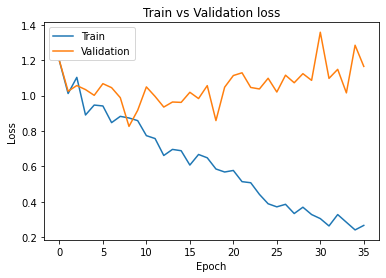

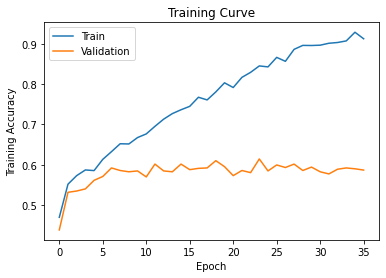

Now training weight_decay:  0.01  lr:  5e-05  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.162515; valid loss 1.089890; Train Acc 0.534181; Val Acc 0.512712
iteration 3; train loss 0.938795; valid loss 1.021861; Train Acc 0.595654; Val Acc 0.550847
iteration 5; train loss 0.857875; valid loss 0.881091; Train Acc 0.626126; Val Acc 0.583686
iteration 7; train loss 0.650894; valid loss 0.716148; Train Acc 0.693694; Val Acc 0.597458
iteration 9; train loss 0.676646; valid loss 0.720384; Train Acc 0.726020; Val Acc 0.595339
iteration 11; train loss 0.663431; valid loss 0.765516; Train Acc 0.751457; Val Acc 0.591102
iteration 13; train loss 0.337299; valid loss 1.177000; Train Acc 0.789083; Val Acc 0.592161
iteration 15; train loss 0.511200; valid loss 1.329217; Train Acc 0.823264; Val Acc 0.582627
iteration 17; train loss 0.615101; valid loss 0.881827; Train Acc 0.854266; Val Acc 0.582627
iteration 19; train loss 0.185712; valid loss 1.432424; Train Acc 

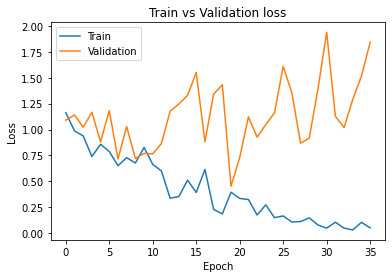

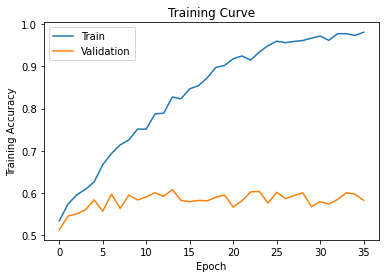

Now training weight_decay:  0.01  lr:  5e-05  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.165064; valid loss 1.073648; Train Acc 0.512189; Val Acc 0.495763
iteration 3; train loss 1.189676; valid loss 1.050780; Train Acc 0.588500; Val Acc 0.554025
iteration 5; train loss 0.936100; valid loss 0.951599; Train Acc 0.603074; Val Acc 0.573093
iteration 7; train loss 0.761409; valid loss 0.761998; Train Acc 0.657393; Val Acc 0.591102
iteration 9; train loss 0.763766; valid loss 0.830599; Train Acc 0.688924; Val Acc 0.591102
iteration 11; train loss 0.696127; valid loss 0.854056; Train Acc 0.716216; Val Acc 0.590042
iteration 13; train loss 0.499299; valid loss 1.000881; Train Acc 0.736884; Val Acc 0.586864
iteration 15; train loss 0.664566; valid loss 1.039509; Train Acc 0.765766; Val Acc 0.582627
iteration 17; train loss 0.667807; valid loss 0.858716; Train Acc 0.793853; Val Acc 0.595339
iteration 19; train loss 0.516020; valid loss 1.102030; Train Acc 

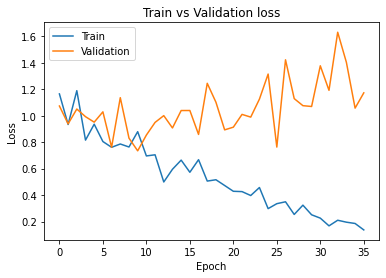

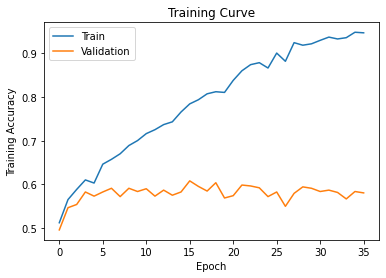

Now training weight_decay:  0.01  lr:  5e-05  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.242651; valid loss 1.219549; Train Acc 0.480922; Val Acc 0.459746
iteration 3; train loss 1.209315; valid loss 1.091852; Train Acc 0.557499; Val Acc 0.511653
iteration 5; train loss 1.009137; valid loss 0.961282; Train Acc 0.591415; Val Acc 0.565678
iteration 7; train loss 0.788308; valid loss 0.873244; Train Acc 0.624271; Val Acc 0.559322
iteration 9; train loss 0.813102; valid loss 0.844363; Train Acc 0.657393; Val Acc 0.578390
iteration 11; train loss 0.843785; valid loss 0.879892; Train Acc 0.670641; Val Acc 0.603814
iteration 13; train loss 0.621439; valid loss 0.961195; Train Acc 0.661632; Val Acc 0.562500
iteration 15; train loss 0.824608; valid loss 1.041324; Train Acc 0.712772; Val Acc 0.575212
iteration 17; train loss 0.778781; valid loss 0.977310; Train Acc 0.735559; Val Acc 0.587924
iteration 19; train loss 0.718104; valid loss 1.088671; Train Acc

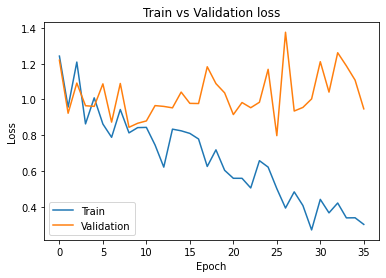

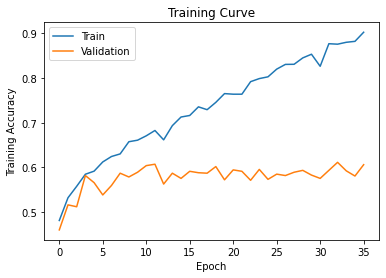

Now training weight_decay:  0.01  lr:  5e-05  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.317987; valid loss 1.312381; Train Acc 0.445416; Val Acc 0.408898
iteration 3; train loss 1.130321; valid loss 1.112406; Train Acc 0.540276; Val Acc 0.507415
iteration 5; train loss 0.978818; valid loss 1.016559; Train Acc 0.558294; Val Acc 0.548729
iteration 7; train loss 0.905521; valid loss 1.086009; Train Acc 0.605193; Val Acc 0.575212
iteration 9; train loss 0.941987; valid loss 0.887633; Train Acc 0.607048; Val Acc 0.569915
iteration 11; train loss 0.850896; valid loss 1.049697; Train Acc 0.641494; Val Acc 0.576271
iteration 13; train loss 0.811950; valid loss 0.929587; Train Acc 0.644144; Val Acc 0.587924
iteration 15; train loss 0.836844; valid loss 0.966402; Train Acc 0.663222; Val Acc 0.595339
iteration 17; train loss 0.848075; valid loss 0.968299; Train Acc 0.677795; Val Acc 0.601695
iteration 19; train loss 0.831579; valid loss 0.879248; Train Acc

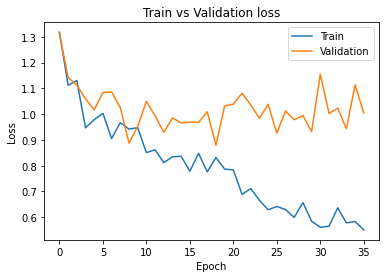

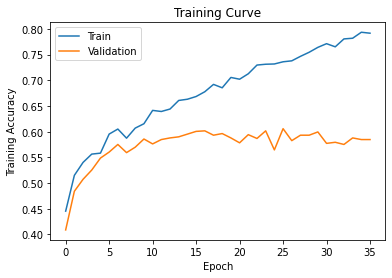

Now training weight_decay:  0.05  lr:  0.005  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.222133; valid loss 1.230204; Train Acc 0.463169; Val Acc 0.445975
iteration 3; train loss 1.317744; valid loss 1.328045; Train Acc 0.347642; Val Acc 0.360169
iteration 5; train loss 1.359447; valid loss 1.309292; Train Acc 0.318495; Val Acc 0.296610
iteration 7; train loss 1.147501; valid loss 1.227277; Train Acc 0.434552; Val Acc 0.402542
iteration 9; train loss 1.265939; valid loss 1.210116; Train Acc 0.411500; Val Acc 0.401483
iteration 11; train loss 1.371825; valid loss 1.421314; Train Acc 0.414414; Val Acc 0.377119
iteration 13; train loss 1.207533; valid loss 1.328418; Train Acc 0.428193; Val Acc 0.429025
iteration 15; train loss 1.513091; valid loss 1.602659; Train Acc 0.260996; Val Acc 0.257415
iteration 17; train loss 1.386748; valid loss 1.387904; Train Acc 0.249338; Val Acc 0.247881
iteration 19; train loss 1.387366; valid loss 1.385097; Train Acc 

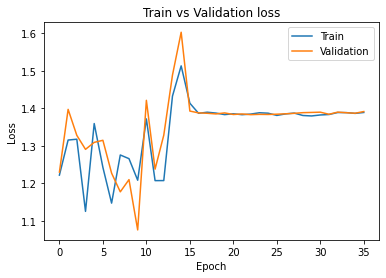

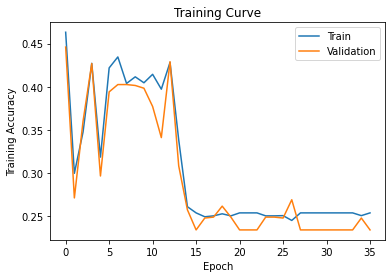

Now training weight_decay:  0.05  lr:  0.005  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.467164; valid loss 1.282951; Train Acc 0.298622; Val Acc 0.266949
iteration 3; train loss 1.290448; valid loss 1.350899; Train Acc 0.379438; Val Acc 0.346398
iteration 5; train loss 1.394734; valid loss 1.399392; Train Acc 0.253577; Val Acc 0.258475
iteration 7; train loss 1.143513; valid loss 1.180475; Train Acc 0.440647; Val Acc 0.448093
iteration 9; train loss 1.372779; valid loss 1.404222; Train Acc 0.245628; Val Acc 0.270127
iteration 11; train loss 1.392592; valid loss 1.392205; Train Acc 0.250397; Val Acc 0.248941
iteration 13; train loss 1.386817; valid loss 1.385692; Train Acc 0.250662; Val Acc 0.247881
iteration 15; train loss 1.388654; valid loss 1.384705; Train Acc 0.250662; Val Acc 0.247881
iteration 17; train loss 1.388065; valid loss 1.386931; Train Acc 0.253842; Val Acc 0.234110
iteration 19; train loss 1.385914; valid loss 1.383906; Train Acc 

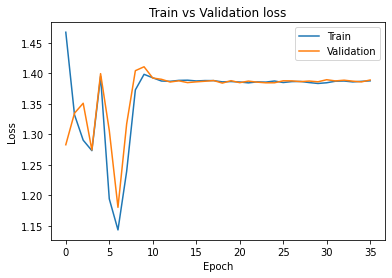

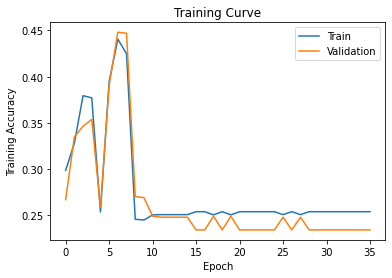

Now training weight_decay:  0.05  lr:  0.005  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.403943; valid loss 1.367526; Train Acc 0.307896; Val Acc 0.286017
iteration 3; train loss 1.252615; valid loss 1.269754; Train Acc 0.393482; Val Acc 0.385593
iteration 5; train loss 1.403612; valid loss 1.286567; Train Acc 0.362215; Val Acc 0.382415
iteration 7; train loss 1.022545; valid loss 1.048007; Train Acc 0.507949; Val Acc 0.495763
iteration 9; train loss 1.087605; valid loss 1.101241; Train Acc 0.526497; Val Acc 0.491525
iteration 11; train loss 1.146056; valid loss 1.159365; Train Acc 0.517488; Val Acc 0.539195
iteration 13; train loss 0.951123; valid loss 1.152532; Train Acc 0.488076; Val Acc 0.487288
iteration 15; train loss 1.029989; valid loss 1.053671; Train Acc 0.542925; Val Acc 0.524364
iteration 17; train loss 1.380352; valid loss 1.386349; Train Acc 0.257287; Val Acc 0.254237
iteration 19; train loss 1.359118; valid loss 1.376473; Train Acc

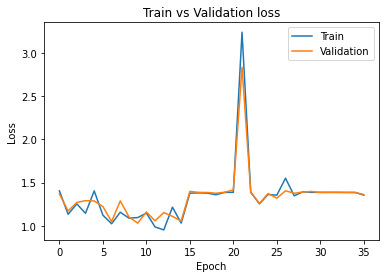

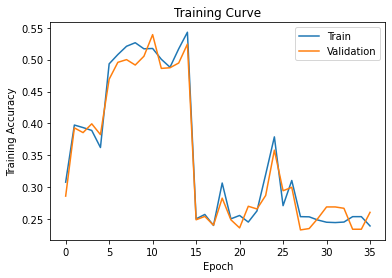

Now training weight_decay:  0.05  lr:  0.005  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.454705; valid loss 1.426676; Train Acc 0.246688; Val Acc 0.245763
iteration 3; train loss 1.349196; valid loss 1.352490; Train Acc 0.380763; Val Acc 0.369703
iteration 5; train loss 1.108709; valid loss 1.150542; Train Acc 0.475358; Val Acc 0.470339
iteration 7; train loss 1.018778; valid loss 1.169479; Train Acc 0.501060; Val Acc 0.507415
iteration 9; train loss 1.139719; valid loss 1.124671; Train Acc 0.485957; Val Acc 0.478814
iteration 11; train loss 1.146565; valid loss 1.211304; Train Acc 0.498675; Val Acc 0.469280
iteration 13; train loss 1.079405; valid loss 1.117902; Train Acc 0.528882; Val Acc 0.514831
iteration 15; train loss 1.087331; valid loss 1.127364; Train Acc 0.528087; Val Acc 0.504237
iteration 17; train loss 1.469845; valid loss 1.560906; Train Acc 0.281399; Val Acc 0.307203
iteration 19; train loss 1.172006; valid loss 1.113132; Train Acc

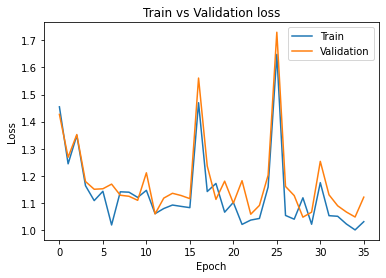

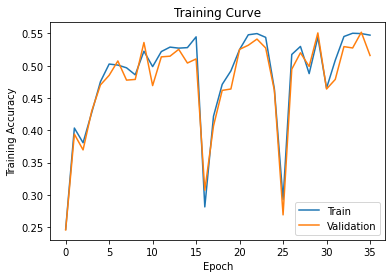

Now training weight_decay:  0.05  lr:  0.001  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.222802; valid loss 1.101363; Train Acc 0.530737; Val Acc 0.495763
iteration 3; train loss 1.101514; valid loss 1.142110; Train Acc 0.524907; Val Acc 0.491525
iteration 5; train loss 1.041551; valid loss 1.091246; Train Acc 0.515633; Val Acc 0.510593
iteration 7; train loss 1.014426; valid loss 0.998263; Train Acc 0.499470; Val Acc 0.492585
iteration 9; train loss 0.889867; valid loss 1.187160; Train Acc 0.551404; Val Acc 0.508475
iteration 11; train loss 1.046747; valid loss 0.950859; Train Acc 0.550079; Val Acc 0.511653
iteration 13; train loss 0.946442; valid loss 1.081445; Train Acc 0.567568; Val Acc 0.518008
iteration 15; train loss 0.880304; valid loss 1.109168; Train Acc 0.566243; Val Acc 0.539195
iteration 17; train loss 1.031458; valid loss 1.038377; Train Acc 0.573662; Val Acc 0.564619
iteration 19; train loss 1.045403; valid loss 1.337769; Train Acc 

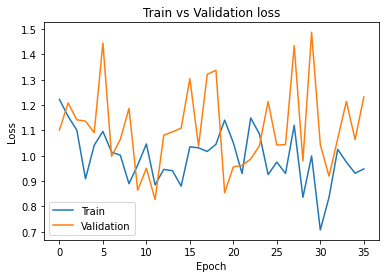

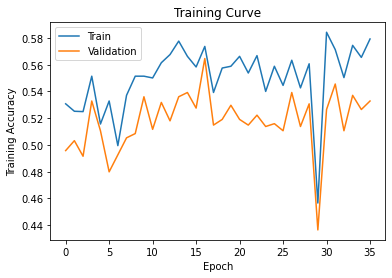

Now training weight_decay:  0.05  lr:  0.001  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.180275; valid loss 1.002103; Train Acc 0.531267; Val Acc 0.524364
iteration 3; train loss 1.226802; valid loss 1.113410; Train Acc 0.557234; Val Acc 0.512712
iteration 5; train loss 1.116519; valid loss 1.091899; Train Acc 0.505299; Val Acc 0.481992
iteration 7; train loss 0.900450; valid loss 0.907255; Train Acc 0.576577; Val Acc 0.538136
iteration 9; train loss 0.966290; valid loss 0.930780; Train Acc 0.563593; Val Acc 0.559322
iteration 11; train loss 1.051283; valid loss 1.132245; Train Acc 0.521728; Val Acc 0.490466
iteration 13; train loss 0.873719; valid loss 1.090476; Train Acc 0.572337; Val Acc 0.518008
iteration 15; train loss 0.888824; valid loss 1.054074; Train Acc 0.583731; Val Acc 0.557203
iteration 17; train loss 1.034974; valid loss 0.969008; Train Acc 0.593005; Val Acc 0.566737
iteration 19; train loss 1.054678; valid loss 1.149157; Train Acc 

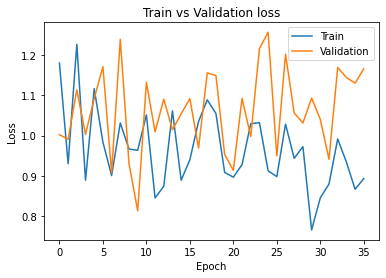

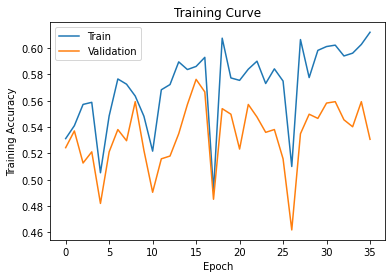

Now training weight_decay:  0.05  lr:  0.001  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.297596; valid loss 1.190785; Train Acc 0.496025; Val Acc 0.465042
iteration 3; train loss 1.215019; valid loss 1.162816; Train Acc 0.522523; Val Acc 0.512712
iteration 5; train loss 1.027464; valid loss 0.972957; Train Acc 0.554584; Val Acc 0.524364
iteration 7; train loss 0.864105; valid loss 0.962710; Train Acc 0.587705; Val Acc 0.543432
iteration 9; train loss 0.979215; valid loss 1.078238; Train Acc 0.545045; Val Acc 0.505297
iteration 11; train loss 1.012938; valid loss 0.955714; Train Acc 0.590620; Val Acc 0.572034
iteration 13; train loss 0.826538; valid loss 1.079741; Train Acc 0.585586; Val Acc 0.532839
iteration 15; train loss 0.970881; valid loss 1.046696; Train Acc 0.597774; Val Acc 0.534958
iteration 17; train loss 1.013022; valid loss 1.031962; Train Acc 0.610228; Val Acc 0.556144
iteration 19; train loss 0.980464; valid loss 1.139910; Train Acc

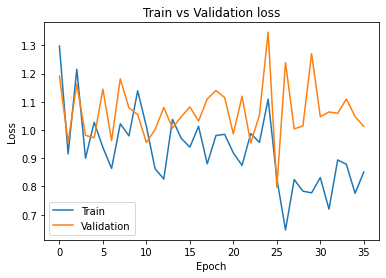

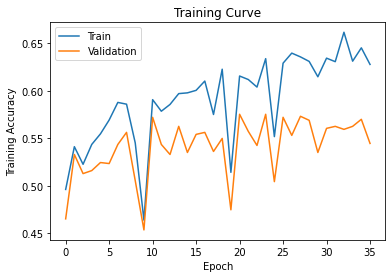

Now training weight_decay:  0.05  lr:  0.001  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.207195; valid loss 1.215612; Train Acc 0.441441; Val Acc 0.405720
iteration 3; train loss 1.133712; valid loss 1.058681; Train Acc 0.547960; Val Acc 0.519068
iteration 5; train loss 0.994269; valid loss 1.031750; Train Acc 0.565448; Val Acc 0.537076
iteration 7; train loss 0.937442; valid loss 1.108310; Train Acc 0.586645; Val Acc 0.560381
iteration 9; train loss 0.926747; valid loss 0.959585; Train Acc 0.580551; Val Acc 0.544492
iteration 11; train loss 0.901574; valid loss 1.074803; Train Acc 0.605988; Val Acc 0.548729
iteration 13; train loss 0.999282; valid loss 1.038580; Train Acc 0.522787; Val Acc 0.496822
iteration 15; train loss 0.905177; valid loss 1.039199; Train Acc 0.612878; Val Acc 0.564619
iteration 17; train loss 0.904075; valid loss 0.984620; Train Acc 0.609698; Val Acc 0.549788
iteration 19; train loss 0.971580; valid loss 0.948974; Train Acc

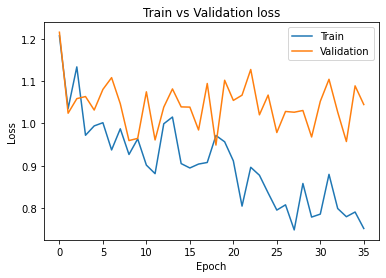

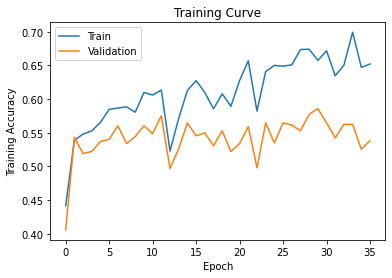

Now training weight_decay:  0.05  lr:  0.0005  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.200446; valid loss 1.100700; Train Acc 0.539746; Val Acc 0.516949
iteration 3; train loss 1.026788; valid loss 1.067224; Train Acc 0.550609; Val Acc 0.507415
iteration 5; train loss 1.025057; valid loss 1.117226; Train Acc 0.506094; Val Acc 0.496822
iteration 7; train loss 1.054588; valid loss 0.961218; Train Acc 0.508214; Val Acc 0.472458
iteration 9; train loss 0.830834; valid loss 1.064834; Train Acc 0.586645; Val Acc 0.544492
iteration 11; train loss 0.972176; valid loss 0.901651; Train Acc 0.583201; Val Acc 0.549788
iteration 13; train loss 0.801176; valid loss 1.031324; Train Acc 0.575252; Val Acc 0.538136
iteration 15; train loss 0.854631; valid loss 1.077504; Train Acc 0.596714; Val Acc 0.534958
iteration 17; train loss 0.953944; valid loss 0.985124; Train Acc 0.607578; Val Acc 0.595339
iteration 19; train loss 0.932371; valid loss 1.239368; Train Acc

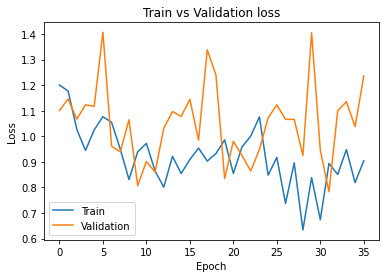

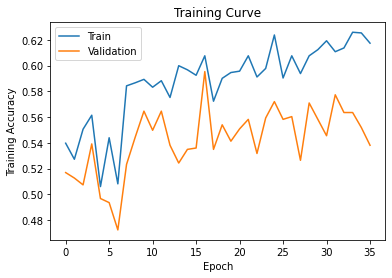

Now training weight_decay:  0.05  lr:  0.0005  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.132881; valid loss 0.999095; Train Acc 0.538951; Val Acc 0.522246
iteration 3; train loss 1.205910; valid loss 1.062708; Train Acc 0.556174; Val Acc 0.513771
iteration 5; train loss 0.980727; valid loss 0.987023; Train Acc 0.563593; Val Acc 0.531780
iteration 7; train loss 0.835188; valid loss 0.873439; Train Acc 0.581081; Val Acc 0.564619
iteration 9; train loss 0.875437; valid loss 0.929781; Train Acc 0.598039; Val Acc 0.528602
iteration 11; train loss 0.888464; valid loss 1.018857; Train Acc 0.589825; Val Acc 0.538136
iteration 13; train loss 0.765983; valid loss 0.980934; Train Acc 0.619237; Val Acc 0.550847
iteration 15; train loss 0.891015; valid loss 1.046239; Train Acc 0.645999; Val Acc 0.587924
iteration 17; train loss 0.915713; valid loss 0.896089; Train Acc 0.644674; Val Acc 0.603814
iteration 19; train loss 0.906001; valid loss 1.005174; Train Acc

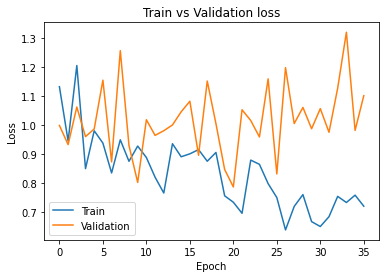

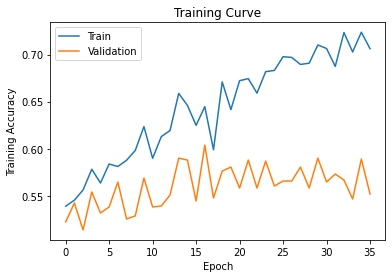

Now training weight_decay:  0.05  lr:  0.0005  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.174914; valid loss 1.150440; Train Acc 0.527292; Val Acc 0.516949
iteration 3; train loss 1.271620; valid loss 1.118542; Train Acc 0.537626; Val Acc 0.507415
iteration 5; train loss 0.963503; valid loss 0.929878; Train Acc 0.581346; Val Acc 0.564619
iteration 7; train loss 0.813204; valid loss 0.881698; Train Acc 0.610758; Val Acc 0.567797
iteration 9; train loss 0.910655; valid loss 0.890251; Train Acc 0.618972; Val Acc 0.560381
iteration 11; train loss 0.916716; valid loss 0.972218; Train Acc 0.633280; Val Acc 0.575212
iteration 13; train loss 0.685502; valid loss 1.048006; Train Acc 0.643614; Val Acc 0.570975
iteration 15; train loss 0.878542; valid loss 1.054733; Train Acc 0.651828; Val Acc 0.552966
iteration 17; train loss 0.900707; valid loss 0.976876; Train Acc 0.667197; Val Acc 0.561441
iteration 19; train loss 0.829781; valid loss 1.049934; Train Ac

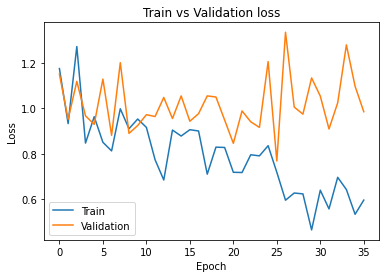

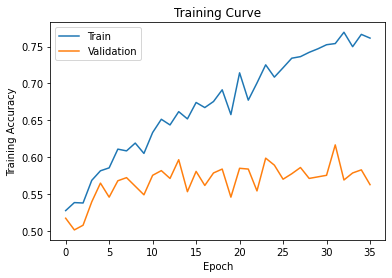

Now training weight_decay:  0.05  lr:  0.0005  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.202539; valid loss 1.208284; Train Acc 0.454690; Val Acc 0.427966
iteration 3; train loss 1.100704; valid loss 1.059834; Train Acc 0.568362; Val Acc 0.524364
iteration 5; train loss 0.958499; valid loss 0.999844; Train Acc 0.571277; Val Acc 0.548729
iteration 7; train loss 0.903210; valid loss 1.082835; Train Acc 0.604663; Val Acc 0.568856
iteration 9; train loss 0.873337; valid loss 0.896697; Train Acc 0.623476; Val Acc 0.559322
iteration 11; train loss 0.868069; valid loss 1.023511; Train Acc 0.627451; Val Acc 0.568856
iteration 13; train loss 0.848278; valid loss 0.941685; Train Acc 0.627186; Val Acc 0.564619
iteration 15; train loss 0.887830; valid loss 1.080159; Train Acc 0.644674; Val Acc 0.569915
iteration 17; train loss 0.829625; valid loss 0.962100; Train Acc 0.691044; Val Acc 0.568856
iteration 19; train loss 0.869480; valid loss 0.895583; Train Ac

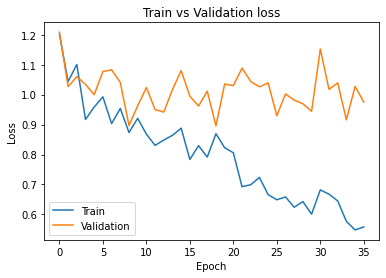

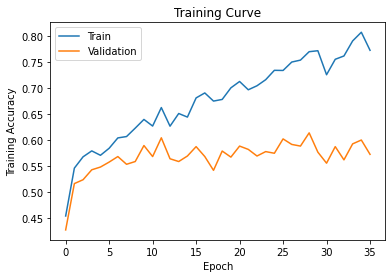

Now training weight_decay:  0.05  lr:  0.0001  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.162194; valid loss 1.091612; Train Acc 0.545310; Val Acc 0.529661
iteration 3; train loss 1.031088; valid loss 1.121463; Train Acc 0.568892; Val Acc 0.521186
iteration 5; train loss 0.941026; valid loss 0.977262; Train Acc 0.557499; Val Acc 0.534958
iteration 7; train loss 0.842835; valid loss 0.797729; Train Acc 0.611023; Val Acc 0.565678
iteration 9; train loss 0.783524; valid loss 0.875554; Train Acc 0.645469; Val Acc 0.582627
iteration 11; train loss 0.883892; valid loss 0.720170; Train Acc 0.644144; Val Acc 0.560381
iteration 13; train loss 0.606638; valid loss 0.912024; Train Acc 0.670906; Val Acc 0.577331
iteration 15; train loss 0.780848; valid loss 1.147903; Train Acc 0.690249; Val Acc 0.569915
iteration 17; train loss 0.862719; valid loss 0.877458; Train Acc 0.723370; Val Acc 0.611229
iteration 19; train loss 0.622323; valid loss 1.131545; Train Acc

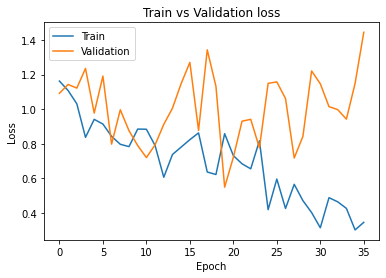

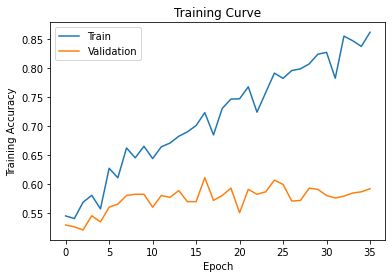

Now training weight_decay:  0.05  lr:  0.0001  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.130413; valid loss 1.034558; Train Acc 0.520138; Val Acc 0.519068
iteration 3; train loss 1.189030; valid loss 1.050414; Train Acc 0.567303; Val Acc 0.548729
iteration 5; train loss 0.979591; valid loss 0.958501; Train Acc 0.577901; Val Acc 0.561441
iteration 7; train loss 0.799764; valid loss 0.812298; Train Acc 0.624006; Val Acc 0.592161
iteration 9; train loss 0.848681; valid loss 0.834713; Train Acc 0.657923; Val Acc 0.568856
iteration 11; train loss 0.826510; valid loss 0.949158; Train Acc 0.639110; Val Acc 0.573093
iteration 13; train loss 0.659333; valid loss 0.923254; Train Acc 0.671966; Val Acc 0.605932
iteration 15; train loss 0.796391; valid loss 1.039162; Train Acc 0.692899; Val Acc 0.582627
iteration 17; train loss 0.884964; valid loss 0.884600; Train Acc 0.704822; Val Acc 0.596398
iteration 19; train loss 0.800401; valid loss 0.972922; Train Acc

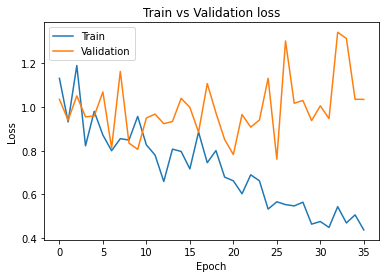

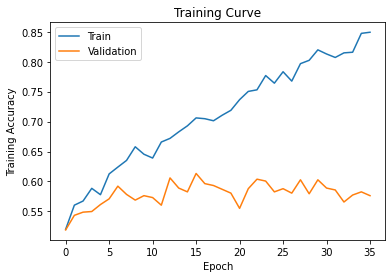

Now training weight_decay:  0.05  lr:  0.0001  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.190662; valid loss 1.139223; Train Acc 0.491521; Val Acc 0.460805
iteration 3; train loss 1.151442; valid loss 1.056762; Train Acc 0.558824; Val Acc 0.557203
iteration 5; train loss 1.013343; valid loss 0.931651; Train Acc 0.591680; Val Acc 0.566737
iteration 7; train loss 0.760553; valid loss 0.863912; Train Acc 0.632750; Val Acc 0.575212
iteration 9; train loss 0.883795; valid loss 0.848578; Train Acc 0.641229; Val Acc 0.576271
iteration 11; train loss 0.907495; valid loss 0.881693; Train Acc 0.636990; Val Acc 0.592161
iteration 13; train loss 0.624234; valid loss 0.966408; Train Acc 0.662427; Val Acc 0.582627
iteration 15; train loss 0.856372; valid loss 1.048481; Train Acc 0.673026; Val Acc 0.572034
iteration 17; train loss 0.887363; valid loss 0.912905; Train Acc 0.697668; Val Acc 0.596398
iteration 19; train loss 0.798173; valid loss 1.027009; Train Ac

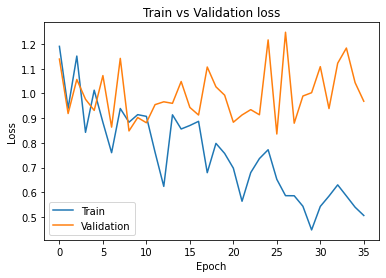

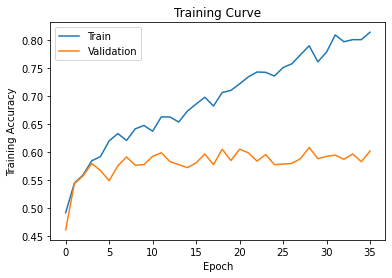

Now training weight_decay:  0.05  lr:  0.0001  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.292625; valid loss 1.286154; Train Acc 0.447271; Val Acc 0.412076
iteration 3; train loss 1.141512; valid loss 1.063541; Train Acc 0.542130; Val Acc 0.536017
iteration 5; train loss 0.991656; valid loss 1.010268; Train Acc 0.563328; Val Acc 0.541314
iteration 7; train loss 0.907101; valid loss 1.073145; Train Acc 0.594065; Val Acc 0.572034
iteration 9; train loss 0.965882; valid loss 0.881648; Train Acc 0.598834; Val Acc 0.570975
iteration 11; train loss 0.891580; valid loss 1.058214; Train Acc 0.624801; Val Acc 0.567797
iteration 13; train loss 0.834535; valid loss 0.944525; Train Acc 0.644674; Val Acc 0.575212
iteration 15; train loss 0.858342; valid loss 0.976230; Train Acc 0.647059; Val Acc 0.606992
iteration 17; train loss 0.893578; valid loss 0.993020; Train Acc 0.641494; Val Acc 0.577331
iteration 19; train loss 0.843002; valid loss 0.853646; Train Ac

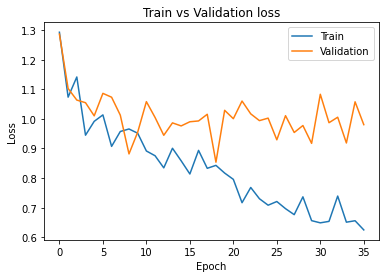

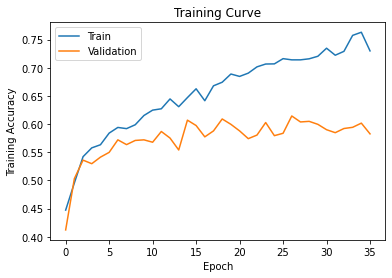

Now training weight_decay:  0.05  lr:  5e-05  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.196856; valid loss 1.103575; Train Acc 0.517223; Val Acc 0.503178
iteration 3; train loss 0.992234; valid loss 1.045925; Train Acc 0.574987; Val Acc 0.538136
iteration 5; train loss 0.940527; valid loss 0.938407; Train Acc 0.578166; Val Acc 0.552966
iteration 7; train loss 0.780321; valid loss 0.741401; Train Acc 0.635400; Val Acc 0.579449
iteration 9; train loss 0.806245; valid loss 0.873874; Train Acc 0.653153; Val Acc 0.569915
iteration 11; train loss 0.872641; valid loss 0.744736; Train Acc 0.640435; Val Acc 0.561441
iteration 13; train loss 0.631023; valid loss 1.041922; Train Acc 0.671436; Val Acc 0.597458
iteration 15; train loss 0.795686; valid loss 1.148079; Train Acc 0.685745; Val Acc 0.574153
iteration 17; train loss 0.893178; valid loss 0.883012; Train Acc 0.708267; Val Acc 0.596398
iteration 19; train loss 0.594803; valid loss 1.068943; Train Acc 

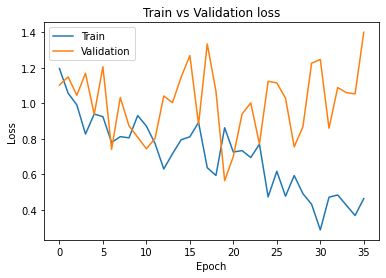

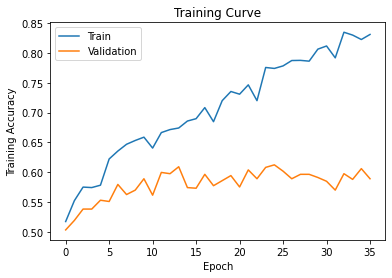

Now training weight_decay:  0.05  lr:  5e-05  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.215620; valid loss 1.141190; Train Acc 0.484632; Val Acc 0.462924
iteration 3; train loss 1.192533; valid loss 1.048827; Train Acc 0.568098; Val Acc 0.537076
iteration 5; train loss 1.004694; valid loss 0.979009; Train Acc 0.582671; Val Acc 0.561441
iteration 7; train loss 0.828579; valid loss 0.811268; Train Acc 0.607843; Val Acc 0.584746
iteration 9; train loss 0.868166; valid loss 0.854677; Train Acc 0.644144; Val Acc 0.570975
iteration 11; train loss 0.841458; valid loss 0.881393; Train Acc 0.647324; Val Acc 0.581568
iteration 13; train loss 0.698668; valid loss 0.946155; Train Acc 0.660042; Val Acc 0.585805
iteration 15; train loss 0.840223; valid loss 1.056487; Train Acc 0.659512; Val Acc 0.576271
iteration 17; train loss 0.927908; valid loss 0.880202; Train Acc 0.679650; Val Acc 0.599576
iteration 19; train loss 0.864300; valid loss 1.019043; Train Acc 

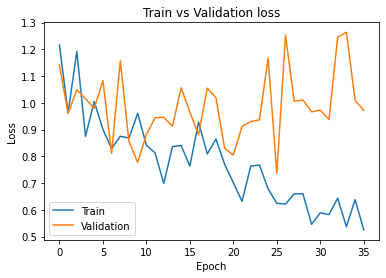

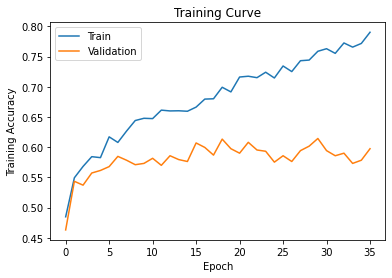

Now training weight_decay:  0.05  lr:  5e-05  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.313837; valid loss 1.287991; Train Acc 0.467144; Val Acc 0.443856
iteration 3; train loss 1.201281; valid loss 1.105288; Train Acc 0.548225; Val Acc 0.502119
iteration 5; train loss 1.048079; valid loss 0.996536; Train Acc 0.563063; Val Acc 0.547669
iteration 7; train loss 0.828178; valid loss 0.903646; Train Acc 0.602544; Val Acc 0.559322
iteration 9; train loss 0.905797; valid loss 0.882448; Train Acc 0.619237; Val Acc 0.561441
iteration 11; train loss 0.990478; valid loss 0.911334; Train Acc 0.631161; Val Acc 0.587924
iteration 13; train loss 0.763921; valid loss 0.968634; Train Acc 0.615262; Val Acc 0.556144
iteration 15; train loss 0.928129; valid loss 1.029796; Train Acc 0.640170; Val Acc 0.574153
iteration 17; train loss 0.946661; valid loss 0.959902; Train Acc 0.657393; Val Acc 0.596398
iteration 19; train loss 0.955131; valid loss 1.085159; Train Acc

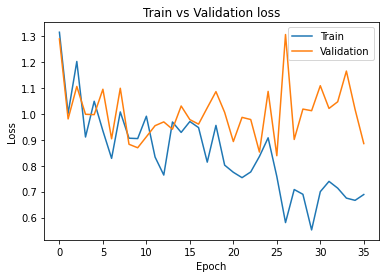

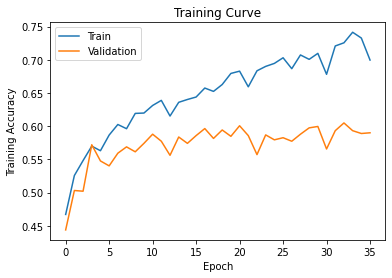

Now training weight_decay:  0.05  lr:  5e-05  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.353521; valid loss 1.348712; Train Acc 0.416004; Val Acc 0.388771
iteration 3; train loss 1.164862; valid loss 1.144785; Train Acc 0.515633; Val Acc 0.486229
iteration 5; train loss 1.023510; valid loss 1.033861; Train Acc 0.547165; Val Acc 0.529661
iteration 7; train loss 0.947810; valid loss 1.103153; Train Acc 0.576047; Val Acc 0.551907
iteration 9; train loss 0.990689; valid loss 0.936113; Train Acc 0.577107; Val Acc 0.550847
iteration 11; train loss 0.928309; valid loss 1.069178; Train Acc 0.598304; Val Acc 0.554025
iteration 13; train loss 0.911643; valid loss 0.953754; Train Acc 0.612613; Val Acc 0.574153
iteration 15; train loss 0.928047; valid loss 1.000712; Train Acc 0.619502; Val Acc 0.587924
iteration 17; train loss 0.937434; valid loss 0.985919; Train Acc 0.634605; Val Acc 0.574153
iteration 19; train loss 0.949048; valid loss 0.897317; Train Acc

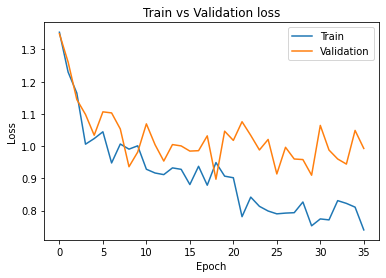

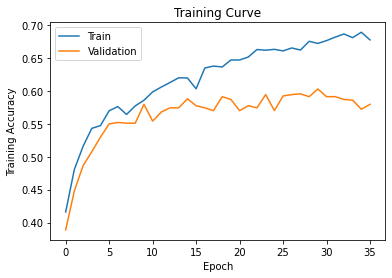

{'lr0.005bs32wd0.001': 0.274364406779661, 'lr0.005bs64wd0.001': 0.503177966101695, 'lr0.005bs128wd0.001': 0.5413135593220338, 'lr0.005bs256wd0.001': 0.5370762711864406, 'lr0.001bs32wd0.001': 0.5720338983050848, 'lr0.001bs64wd0.001': 0.5995762711864406, 'lr0.001bs128wd0.001': 0.5953389830508474, 'lr0.001bs256wd0.001': 0.5847457627118644, 'lr0.0005bs32wd0.001': 0.6059322033898306, 'lr0.0005bs64wd0.001': 0.5985169491525424, 'lr0.0005bs128wd0.001': 0.5985169491525424, 'lr0.0005bs256wd0.001': 0.6186440677966102, 'lr0.0001bs32wd0.001': 0.6027542372881356, 'lr0.0001bs64wd0.001': 0.6091101694915254, 'lr0.0001bs128wd0.001': 0.6080508474576272, 'lr0.0001bs256wd0.001': 0.6059322033898306, 'lr5e-05bs32wd0.001': 0.6091101694915254, 'lr5e-05bs64wd0.001': 0.6016949152542372, 'lr5e-05bs128wd0.001': 0.6165254237288136, 'lr5e-05bs256wd0.001': 0.6069915254237288, 'lr0.005bs32wd0.01': 0.4968220338983051, 'lr0.005bs64wd0.01': 0.5264830508474576, 'lr0.005bs128wd0.01': 0.5635593220338984, 'lr0.005bs256wd0.01

In [ ]:
weight_decay_list = [0.001, 0.01, 0.05]
lr_list = [0.005, 0.001,0.0005, 0.0001, 0.00005]
batch_size_list = [32, 64, 128, 256]
record = {}
for weight_decay in weight_decay_list:
  for lr in lr_list:
    for batch_size in batch_size_list:
      print("Now training weight_decay: ", weight_decay, " lr: ", lr, " batch size: ", batch_size)
      use_cuda = True
      alex_net = CNNClassifier_alex_withdropout1()
      if use_cuda and torch.cuda.is_available():
        alex_net.cuda()          
        print('CUDA is available!  Training on GPU ...')
      else:
        print('CUDA is not available.  Training on CPU ...') 
      val_acc = train(alex_net, train_alex_path, valid_alex_path,  batch_size = batch_size , learning_rate= lr ,num_epochs = 36, weight_decay= weight_decay)
      best_val = max(val_acc)
      name = "lr"+str(lr)+"bs"+str(batch_size)+"wd"+str(weight_decay)
      record[name] = best_val
print(record)

Now training weight_decay:  0.005  lr:  0.005  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.382481; valid loss 1.316121; Train Acc 0.288818; Val Acc 0.273305
iteration 3; train loss 1.566335; valid loss 1.125717; Train Acc 0.324589; Val Acc 0.302966
iteration 5; train loss 1.430022; valid loss 1.249163; Train Acc 0.396396; Val Acc 0.411017
iteration 7; train loss 1.350181; valid loss 1.208086; Train Acc 0.373079; Val Acc 0.362288
iteration 9; train loss 1.107585; valid loss 1.159179; Train Acc 0.384473; Val Acc 0.341102
iteration 11; train loss 1.421496; valid loss 1.478695; Train Acc 0.250662; Val Acc 0.248941
iteration 13; train loss 1.404637; valid loss 1.049587; Train Acc 0.303657; Val Acc 0.290254
iteration 15; train loss 1.173952; valid loss 1.298101; Train Acc 0.392687; Val Acc 0.376059
iteration 17; train loss 1.330453; valid loss 2.205482; Train Acc 0.308956; Val Acc 0.309322
iteration 19; train loss 1.329517; valid loss 1.425424; Train Acc

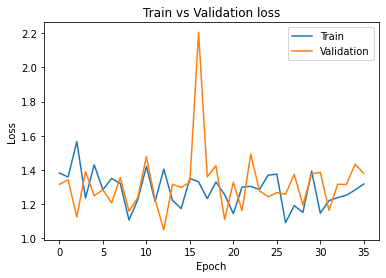

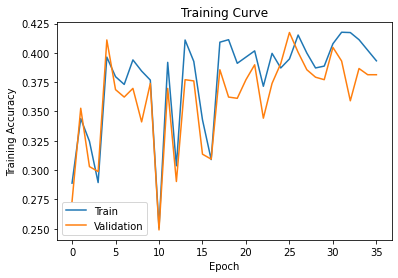

Now training weight_decay:  0.005  lr:  0.005  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.327353; valid loss 1.452154; Train Acc 0.412825; Val Acc 0.414195
iteration 3; train loss 1.312000; valid loss 1.294054; Train Acc 0.427928; Val Acc 0.397246
iteration 5; train loss 1.129989; valid loss 1.244442; Train Acc 0.427133; Val Acc 0.411017
iteration 7; train loss 1.180569; valid loss 1.246508; Train Acc 0.420244; Val Acc 0.420551
iteration 9; train loss 1.171405; valid loss 1.265386; Train Acc 0.427928; Val Acc 0.417373
iteration 11; train loss 1.407238; valid loss 1.328782; Train Acc 0.390037; Val Acc 0.356992
iteration 13; train loss 1.092646; valid loss 1.194094; Train Acc 0.455220; Val Acc 0.430085
iteration 15; train loss 1.162889; valid loss 1.283662; Train Acc 0.431902; Val Acc 0.416314
iteration 17; train loss 1.297101; valid loss 1.211503; Train Acc 0.439057; Val Acc 0.439619
iteration 19; train loss 1.266498; valid loss 1.355040; Train Acc

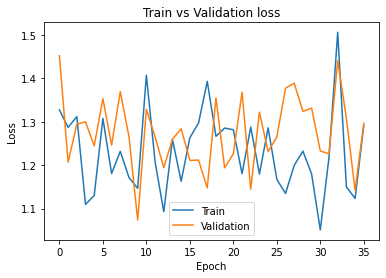

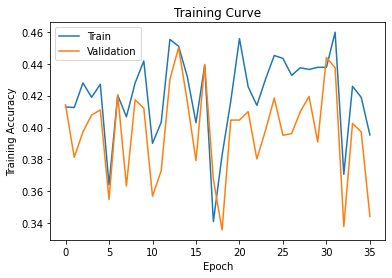

Now training weight_decay:  0.005  lr:  0.005  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.251231; valid loss 1.248233; Train Acc 0.339428; Val Acc 0.354873
iteration 3; train loss 1.429637; valid loss 1.276021; Train Acc 0.380763; Val Acc 0.379237
iteration 5; train loss 1.171346; valid loss 1.114141; Train Acc 0.484367; Val Acc 0.454449
iteration 7; train loss 1.103884; valid loss 1.060586; Train Acc 0.494966; Val Acc 0.470339
iteration 9; train loss 1.090233; valid loss 1.057649; Train Acc 0.511924; Val Acc 0.491525
iteration 11; train loss 1.218043; valid loss 1.116554; Train Acc 0.510334; Val Acc 0.468220
iteration 13; train loss 1.089623; valid loss 1.152065; Train Acc 0.465289; Val Acc 0.417373
iteration 15; train loss 1.100443; valid loss 1.157997; Train Acc 0.502915; Val Acc 0.438559
iteration 17; train loss 1.155193; valid loss 1.099899; Train Acc 0.509009; Val Acc 0.475636
iteration 19; train loss 1.136217; valid loss 1.226386; Train Ac

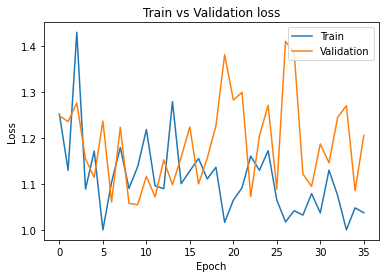

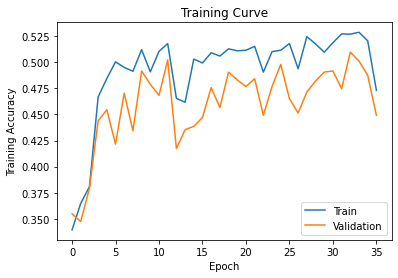

Now training weight_decay:  0.005  lr:  0.005  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.308611; valid loss 1.336958; Train Acc 0.328034; Val Acc 0.338983
iteration 3; train loss 1.250339; valid loss 1.232435; Train Acc 0.434022; Val Acc 0.401483
iteration 5; train loss 1.228988; valid loss 1.228495; Train Acc 0.436937; Val Acc 0.421610
iteration 7; train loss 1.095631; valid loss 1.246971; Train Acc 0.480657; Val Acc 0.423729
iteration 9; train loss 1.082158; valid loss 1.084546; Train Acc 0.496025; Val Acc 0.489407
iteration 11; train loss 1.188440; valid loss 1.208161; Train Acc 0.506889; Val Acc 0.475636
iteration 13; train loss 1.115669; valid loss 1.109426; Train Acc 0.522523; Val Acc 0.460805
iteration 15; train loss 1.096822; valid loss 1.116657; Train Acc 0.518813; Val Acc 0.508475
iteration 17; train loss 1.041044; valid loss 1.167477; Train Acc 0.531002; Val Acc 0.490466
iteration 19; train loss 1.190710; valid loss 1.228977; Train Ac

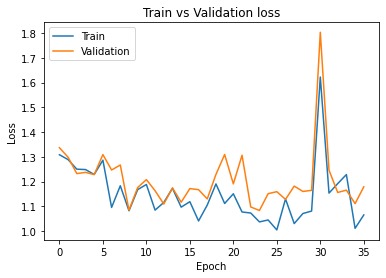

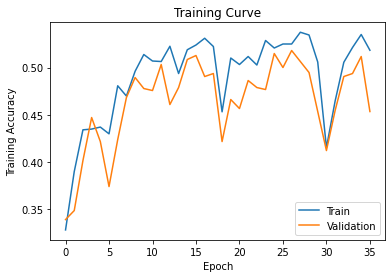

Now training weight_decay:  0.005  lr:  0.001  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.160282; valid loss 1.136153; Train Acc 0.505299; Val Acc 0.461864
iteration 3; train loss 1.138512; valid loss 1.174611; Train Acc 0.520403; Val Acc 0.463983
iteration 5; train loss 1.174005; valid loss 1.105830; Train Acc 0.534711; Val Acc 0.503178
iteration 7; train loss 1.022455; valid loss 0.916972; Train Acc 0.563328; Val Acc 0.503178
iteration 9; train loss 0.896688; valid loss 1.101262; Train Acc 0.577636; Val Acc 0.509534
iteration 11; train loss 0.796857; valid loss 0.872401; Train Acc 0.555644; Val Acc 0.493644
iteration 13; train loss 0.929772; valid loss 0.951254; Train Acc 0.593800; Val Acc 0.520127
iteration 15; train loss 0.928309; valid loss 1.066624; Train Acc 0.588235; Val Acc 0.510593
iteration 17; train loss 0.943259; valid loss 0.880361; Train Acc 0.574987; Val Acc 0.538136
iteration 19; train loss 1.191901; valid loss 1.721407; Train Acc

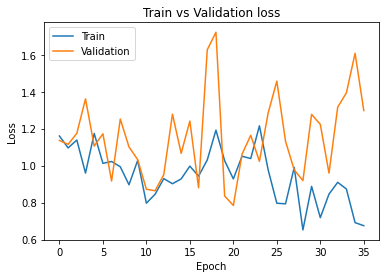

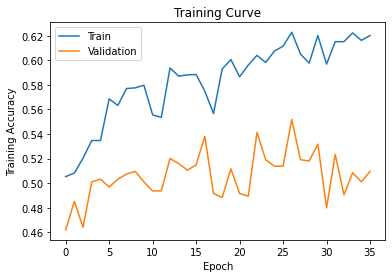

Now training weight_decay:  0.005  lr:  0.001  batch size:  64
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.181782; valid loss 1.142185; Train Acc 0.500265; Val Acc 0.477754
iteration 3; train loss 1.104978; valid loss 0.997811; Train Acc 0.546370; Val Acc 0.485169
iteration 5; train loss 1.000333; valid loss 1.117497; Train Acc 0.563593; Val Acc 0.505297
iteration 7; train loss 0.912365; valid loss 0.980479; Train Acc 0.572867; Val Acc 0.497881
iteration 9; train loss 0.916503; valid loss 1.003491; Train Acc 0.580286; Val Acc 0.524364
iteration 11; train loss 0.945362; valid loss 1.168980; Train Acc 0.609168; Val Acc 0.532839
iteration 13; train loss 0.725382; valid loss 1.106596; Train Acc 0.612878; Val Acc 0.522246
iteration 15; train loss 0.986880; valid loss 1.191940; Train Acc 0.595654; Val Acc 0.512712
iteration 17; train loss 0.948067; valid loss 1.019412; Train Acc 0.609433; Val Acc 0.538136
iteration 19; train loss 1.004080; valid loss 1.138201; Train Acc

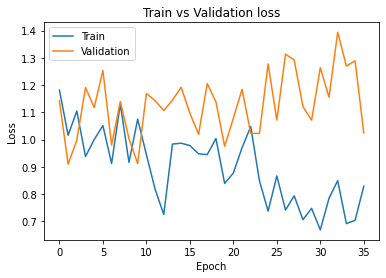

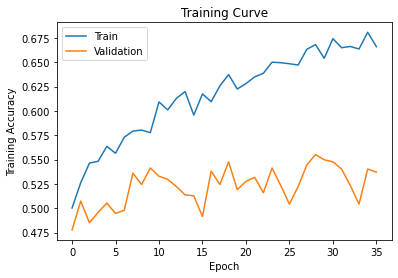

Now training weight_decay:  0.005  lr:  0.001  batch size:  128
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.203382; valid loss 1.118825; Train Acc 0.501855; Val Acc 0.465042
iteration 3; train loss 1.360231; valid loss 1.275349; Train Acc 0.529677; Val Acc 0.480932
iteration 5; train loss 0.993166; valid loss 0.943672; Train Acc 0.577636; Val Acc 0.527542
iteration 7; train loss 0.866349; valid loss 0.925390; Train Acc 0.611818; Val Acc 0.540254
iteration 9; train loss 0.898031; valid loss 0.903934; Train Acc 0.620032; Val Acc 0.522246
iteration 11; train loss 0.854324; valid loss 0.965979; Train Acc 0.633280; Val Acc 0.541314
iteration 13; train loss 0.809332; valid loss 1.021209; Train Acc 0.622417; Val Acc 0.528602
iteration 15; train loss 0.990526; valid loss 1.070822; Train Acc 0.631955; Val Acc 0.520127
iteration 17; train loss 0.981912; valid loss 1.101876; Train Acc 0.665342; Val Acc 0.510593
iteration 19; train loss 0.953215; valid loss 1.270078; Train Ac

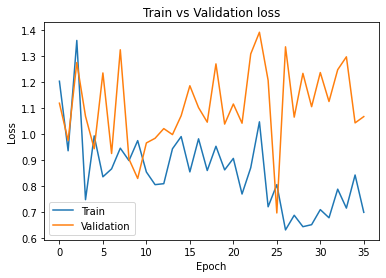

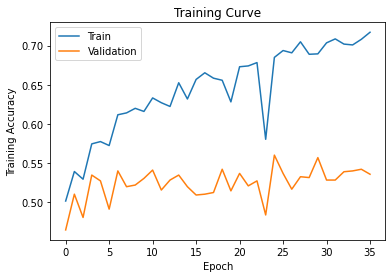

Now training weight_decay:  0.005  lr:  0.001  batch size:  256
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.242143; valid loss 1.263535; Train Acc 0.423423; Val Acc 0.414195
iteration 3; train loss 1.185829; valid loss 1.156948; Train Acc 0.521993; Val Acc 0.488347
iteration 5; train loss 1.046272; valid loss 1.075528; Train Acc 0.562268; Val Acc 0.524364
iteration 7; train loss 0.931237; valid loss 1.190328; Train Acc 0.580816; Val Acc 0.555085
iteration 9; train loss 0.881216; valid loss 0.982762; Train Acc 0.602014; Val Acc 0.534958
iteration 11; train loss 0.899900; valid loss 1.174796; Train Acc 0.626656; Val Acc 0.525424
iteration 13; train loss 0.818302; valid loss 0.994112; Train Acc 0.633545; Val Acc 0.544492
iteration 15; train loss 0.889631; valid loss 1.043310; Train Acc 0.647059; Val Acc 0.544492
iteration 17; train loss 0.888175; valid loss 1.113651; Train Acc 0.642024; Val Acc 0.543432
iteration 19; train loss 0.834702; valid loss 1.000638; Train Ac

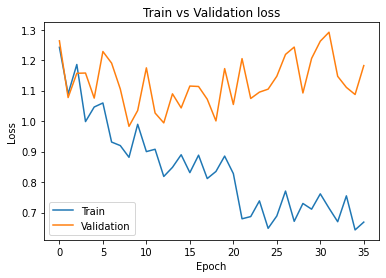

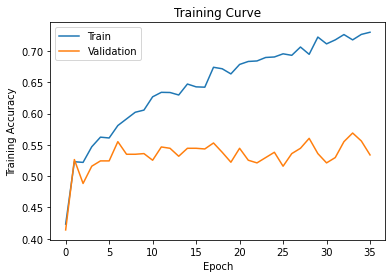

Now training weight_decay:  0.005  lr:  0.0005  batch size:  32
CUDA is available!  Training on GPU ...
iteration 1; train loss 1.132264; valid loss 1.205128; Train Acc 0.502915; Val Acc 0.478814
iteration 3; train loss 1.079100; valid loss 1.362135; Train Acc 0.510334; Val Acc 0.454449
iteration 5; train loss 1.095535; valid loss 0.939115; Train Acc 0.570217; Val Acc 0.525424
iteration 7; train loss 0.961168; valid loss 0.929145; Train Acc 0.591680; Val Acc 0.523305
iteration 9; train loss 0.959275; valid loss 0.954258; Train Acc 0.613672; Val Acc 0.525424
iteration 11; train loss 0.873055; valid loss 0.820893; Train Acc 0.618707; Val Acc 0.533898
iteration 13; train loss 0.808280; valid loss 1.056635; Train Acc 0.636990; Val Acc 0.561441
iteration 15; train loss 0.932009; valid loss 0.982463; Train Acc 0.650238; Val Acc 0.559322
iteration 17; train loss 0.965446; valid loss 0.896719; Train Acc 0.656333; Val Acc 0.554025
iteration 19; train loss 0.877697; valid loss 1.548782; Train Ac

KeyboardInterrupt: ignored

In [ ]:
weight_decay_list = [0.005, 0.01, 0.05 , 0.1]
lr_list = [0.005, 0.001,0.0005, 0.0001, 0.00005]
batch_size_list = [32, 64, 128, 256]
record = {}
for weight_decay in weight_decay_list:
  for lr in lr_list:
    for batch_size in batch_size_list:
      print("Now training weight_decay: ", weight_decay, " lr: ", lr, " batch size: ", batch_size)
      use_cuda = True
      alex_net = CNNClassifier_alex_withdropout()
      if use_cuda and torch.cuda.is_available():
        alex_net.cuda()          
        print('CUDA is available!  Training on GPU ...')
      else:
        print('CUDA is not available.  Training on CPU ...') 
      val_acc = train(alex_net, train_alex_path, valid_alex_path,  batch_size = batch_size , learning_rate= lr ,num_epochs = 36, weight_decay= weight_decay)
      best_val = max(val_acc)
      name = "lr"+str(lr)+"bs"+str(batch_size)+"wd"+str(weight_decay)
      record[name] = best_val
print(record)

##Evaluation


In [ ]:
test_alex = "/content/drive/My Drive/APS360_Project/ModelTuning/Test_alex"

In [ ]:
drive_path_primary_model = '/content/drive/My Drive/APS360_Project/ModelTuning/PrimarymodelCheckpoint/'
# model loading 
final_model_alex = alex1 = CNNClassifier_alex()
model_path = drive_path_primary_model + "model_CNNAlex12_bs32_lr0.0001_epoch3"
state = torch.load(model_path)
final_model_alex.load_state_dict(state)
print("finished loading final_model_alex")


finished loading final_model_alex


In [ ]:
# lr5e-05bs64wd0.05'
drive_path_primary_model = '/content/drive/My Drive/APS360_Project/ModelTuning/PrimarymodelCheckpoint/'
# model loading 
final_model_alexdropout = alex1 = CNNClassifier_alex_withdropout1()
model_path = drive_path_primary_model + "model_Alex_dropout0.2_bs256_lr0.0001_epoch180.01"
state = torch.load(model_path)
final_model_alexdropout.load_state_dict(state)
print("finished loading final_model_alexdropout")

finished loading final_model_alexdropout


evaluating the model by looking into how many 

In [ ]:
print(np.zeros((4,4)))
g = np.zeros((4,4))

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [ ]:
g[3][1] = 1
print(g)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [ ]:
import itertools
def evaluate(model, path , batch_size):
    correct = 0
    total = 0
    classes = [0,1,2,3]
    original, prediction = {0:0, 1:0, 2:0, 3:0} , {0:0, 1:0, 2:0, 3:0}  
    confuction_matrix = np.zeros((4,4))
    dataset = torchvision.datasets.DatasetFolder(path, loader=torch.load, extensions=('.tensor'))
    for imgs, labels in iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)):
      #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        output = model(imgs) 
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred_list = list(itertools.chain.from_iterable(pred))
        for i in range(len(pred_list)):
          actual_value = int(list(labels)[i])
          pred_value = int(pred_list[i])
          confuction_matrix[actual_value][pred_value] += 1
        for style in classes:
          original[style] += list(labels).count(style)
          prediction[style] += list(pred).count(style)
        
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    acc = correct / total
    return acc, original, prediction, confuction_matrix

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
  final_model_alex.cuda()
  print('CUDA is available! ')
else:
  print('CUDA is not available. ')
acc_test_alex, original_test_alex, prediction_test_alex, confuction_matrix_test_alex = evaluate(final_model_alex, test_alex, 32)

CUDA is available! 


In [ ]:
print(acc_test_alex)
print(confuction_matrix_test_alex)
print(original_test_alex)
print(prediction_test_alex)
acc_of_each_style = []
for i in range(confuction_matrix_test_alex.shape[0]):
  acc_style = confuction_matrix_test_alex[i][i] / np.sum( confuction_matrix_test_alex[i])
  acc_of_each_style.append(acc_style)
print(acc_of_each_style)

0.605
[[248.  76.  11.  15.]
 [ 25. 254.  27.  44.]
 [ 27. 102. 127.  94.]
 [ 12.  68.  52. 218.]]
{0: 350, 1: 350, 2: 350, 3: 350}
{0: 312, 1: 500, 2: 217, 3: 371}
[0.7085714285714285, 0.7257142857142858, 0.3628571428571429, 0.6228571428571429]


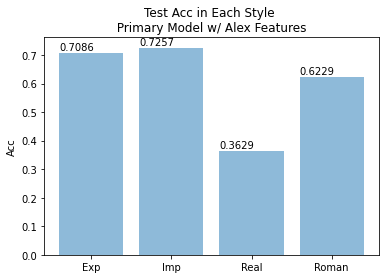

In [ ]:
objects = ["Exp", "Imp", "Real", "Roman"]
y_pos = np.arange(len(objects))
performance = [0.7086, 0.7257, 0.3629, 0.6229]

bars = plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Acc')
plt.title('Test Acc in Each Style \n Primary Model w/ Alex Features ')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .01, yval)
plt.show()

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
  final_model_alexdropout.cuda()
  print('CUDA is available! ')
else:
  print('CUDA is not available. ')
acc_test_alexdropout, original_test_alexdropout, prediction_test_alexdropout, confuction_matrix_test_alexdropout= evaluate(final_model_alexdropout, test_alex, 256)

CUDA is available! 


In [ ]:
print(acc_test_alexdropout)
print(confuction_matrix_test_alexdropout)
print(original_test_alexdropout)
print(prediction_test_alexdropout)
acc_of_each_style = []
for i in range(confuction_matrix_test_alexdropout.shape[0]):
  acc_style = confuction_matrix_test_alexdropout[i][i] / np.sum( confuction_matrix_test_alexdropout[i])
  acc_of_each_style.append(acc_style)
print(acc_of_each_style)

0.5835714285714285
[[259.  51.  32.   8.]
 [ 49. 192.  60.  49.]
 [ 37.  76. 158.  79.]
 [ 18.  40.  84. 208.]]
{0: 350, 1: 350, 2: 350, 3: 350}
{0: 363, 1: 359, 2: 334, 3: 344}
[0.74, 0.5485714285714286, 0.4514285714285714, 0.5942857142857143]


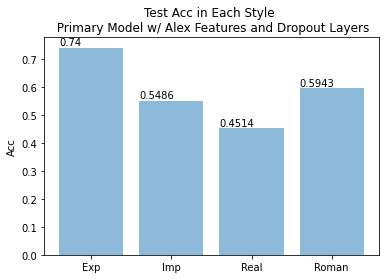

In [ ]:
objects = ["Exp", "Imp", "Real", "Roman"]
y_pos = np.arange(len(objects))
performance = [0.74, 0.5486, 0.4514, 0.5943]

bars = plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Acc')
plt.title('Test Acc in Each Style \n Primary Model w/ Alex Features and Dropout Layers')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .01, yval)
plt.show()

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
  final_model_alex.cuda()
  print('CUDA is available! ')
else:
  print('CUDA is not available. ')
train_acc, train_original, train_prediction, train_confuction_matrix = evaluate(final_model_alex, train_alex_path, 32)
print(train_acc)
print(train_confuction_matrix)
print(train_original)
print(train_prediction)
acc_of_each_style = []
for i in range(train_confuction_matrix.shape[0]):
  acc_style = train_confuction_matrix[i][i] / np.sum( train_confuction_matrix[i])
  acc_of_each_style.append(acc_style)
print(acc_of_each_style)

CUDA is available! 
0.7723900370959195
[[781. 142.  25.  10.]
 [ 17. 832.  43.  53.]
 [ 34. 210. 557. 145.]
 [  7. 131.  42. 745.]]
{0: 958, 1: 945, 2: 946, 3: 925}
{0: 839, 1: 1315, 2: 667, 3: 953}
[0.8152400835073069, 0.8804232804232804, 0.5887949260042283, 0.8054054054054054]


In [ ]:

use_cuda = True
if use_cuda and torch.cuda.is_available():
  final_model_alex.cuda()
  print('CUDA is available! ')
else:
  print('CUDA is not available. ')
acc, original, prediction, confuction_matrix = evaluate(final_model_alex, valid_alex_path, 32)

CUDA is available! 


In [ ]:
print(acc)
print(confuction_matrix)
print(original)
print(prediction)
acc_of_each_style = []
for i in range(confuction_matrix.shape[0]):
  acc_style = confuction_matrix[i][i] / np.sum( confuction_matrix[i])
  acc_of_each_style.append(acc_style)
print(acc_of_each_style)

0.6260593220338984
[[165.  39.  10.   7.]
 [ 15. 174.  28.  18.]
 [ 19.  69.  85.  61.]
 [  7.  44.  36. 167.]]
{0: 221, 1: 235, 2: 234, 3: 254}
{0: 206, 1: 326, 2: 159, 3: 253}
[0.746606334841629, 0.7404255319148936, 0.36324786324786323, 0.65748031496063]


In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
  final_model_alexdropout.cuda()
  print('CUDA is available! ')
else:
  print('CUDA is not available. ')
acc_dropout, original_dropout, prediction_dropout, confuction_matrix_dropout = evaluate(final_model_alexdropout, valid_alex_path, 256)

CUDA is available! 


In [ ]:
print(acc_dropout)
print(confuction_matrix_dropout)
print(original_dropout)
print(prediction_dropout)
acc_of_each_style = []
for i in range(confuction_matrix_dropout.shape[0]):
  acc_style = confuction_matrix_dropout[i][i] / np.sum( confuction_matrix_dropout[i])
  acc_of_each_style.append(acc_style)
print(acc_of_each_style)

0.5879237288135594
[[167.  23.  21.  10.]
 [ 30. 123.  55.  27.]
 [ 24.  40. 112.  58.]
 [  8.  26.  67. 153.]]
{0: 221, 1: 235, 2: 234, 3: 254}
{0: 229, 1: 212, 2: 255, 3: 248}
[0.755656108597285, 0.5234042553191489, 0.47863247863247865, 0.6023622047244095]


In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
  final_model_alexdropout.cuda()
  print('CUDA is available! ')
else:
  print('CUDA is not available. ')
train_acc_dropout, train_original_dropout, train_prediction_dropout, train_confuction_matrix_dropout = evaluate(final_model_alexdropout, train_alex_path, 256)


CUDA is available! 


NameError: ignored

In [ ]:
print(train_acc_dropout)
print(train_confuction_matrix_dropout)
print(train_original_dropout)
print(train_prediction_dropout)
acc_of_each_style = []
for i in range(train_confuction_matrix_dropout.shape[0]):
  acc_style = train_confuction_matrix_dropout[i][i] / np.sum( train_confuction_matrix_dropout[i])
  acc_of_each_style.append(acc_style)
print(acc_of_each_style)

0.7965023847376789
[[848.  59.  43.   8.]
 [ 60. 716. 126.  43.]
 [ 59.  98. 676. 113.]
 [ 16.  45.  98. 766.]]
{0: 958, 1: 945, 2: 946, 3: 925}
{0: 983, 1: 918, 2: 943, 3: 930}
[0.8851774530271399, 0.7576719576719577, 0.7145877378435518, 0.8281081081081081]


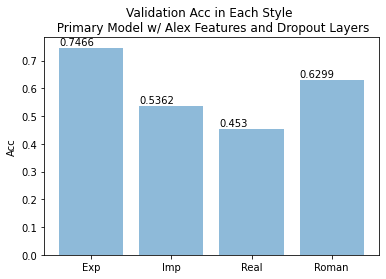

In [ ]:
objects = ["Exp", "Imp", "Real", "Roman"]
y_pos = np.arange(len(objects))
performance = [0.7466, 0.5362, 0.4530, 0.6299]

bars = plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Acc')
plt.title('Validation Acc in Each Style \n Primary Model w/ Alex Features and Dropout Layers')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .01, yval)
plt.show()

In [ ]:
confuction_matrix

array([[165.,  39.,  10.,   7.],
       [ 15., 174.,  28.,  18.],
       [ 19.,  69.,  85.,  61.],
       [  7.,  44.,  36., 167.]])

In [ ]:
original

{0: 221, 1: 235, 2: 234, 3: 254}

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
  final_model.cuda()
  print('CUDA is available! ')
else:
  print('CUDA is not available. ')
acc_val, original_val,prediction_val,confuction_matrix_val = evaluate(final_model, valid_alex_path, 32)

CUDA is available! 


In [ ]:
confuction_matrix_val

array([[165.,  39.,  10.,   7.],
       [ 15., 174.,  28.,  18.],
       [ 19.,  69.,  85.,  61.],
       [  7.,  44.,  36., 167.]])

In [ ]:
acc_of_each_style = []
for i in range(confuction_matrix_val.shape[0]):
  acc_style = confuction_matrix_val[i][i] / np.sum( confuction_matrix_val[i])
  acc_of_each_style.append(acc_style)

In [ ]:
acc_of_each_style

[0.746606334841629, 0.7404255319148936, 0.36324786324786323, 0.65748031496063]

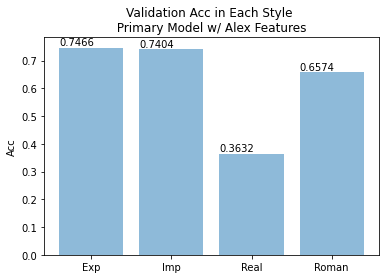

In [ ]:
objects = ["Exp", "Imp", "Real", "Roman"]
y_pos = np.arange(len(objects))
performance = [0.7466, 0.7404, 0.3632, 0.6574]

bars = plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Acc')
plt.title('Validation Acc in Each Style \n Primary Model w/ Alex Features ')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .01, yval)
plt.show()

In [ ]:
data_set = torchvision.datasets.DatasetFolder(valid_alex_path, loader=torch.load, extensions=('.tensor'))
data_set.class_to_idx

{'Protrait_Expressionism': 0,
 'Protrait_Impressionism': 1,
 'Protrait_Realism': 2,
 'Protrait_Romanticism': 3}

In [ ]:
acc_val

0.6260593220338984

In [ ]:
original_val

{0: 221, 1: 235, 2: 234, 3: 254}

In [ ]:
prediction_val

{0: 206, 1: 326, 2: 159, 3: 253}

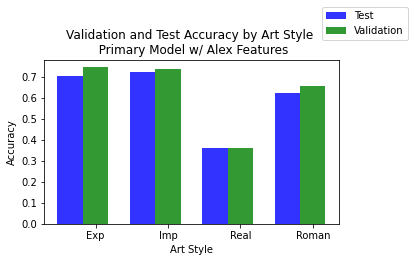

In [ ]:
# data to plot
n_groups = 4
Test = [0.7056, 0.7257, 0.3629, 0.6229]
Validation = [0.7466, 0.7404, 0.3632, 0.6574]
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, Test, bar_width,
alpha=opacity,
color='b',
label='Test')

rects2 = plt.bar(index + bar_width, Validation, bar_width,
alpha=opacity,
color='g',
label='Validation')

plt.xlabel('Art Style')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracy by Art Style \n  Primary Model w/ Alex Features ')
plt.xticks(index + bar_width,  ["Exp", "Imp", "Real", "Roman"])
plt.legend(loc='best', bbox_to_anchor=(1.25, 1.35))
plt.tight_layout()
plt.show()

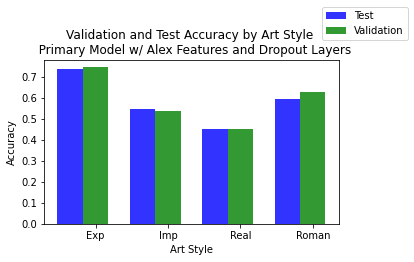

In [ ]:
# data to plot
n_groups = 4
Test = [0.74, 0.5486, 0.4514, 0.5943]
Validation = [0.7466, 0.5362, 0.4530, 0.6299]
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, Test, bar_width,
alpha=opacity,
color='b',
label='Test')

rects2 = plt.bar(index + bar_width, Validation, bar_width,
alpha=opacity,
color='g',
label='Validation')

plt.xlabel('Art Style')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracy by Art Style \n  Primary Model w/ Alex Features and Dropout Layers')
plt.xticks(index + bar_width,  ["Exp", "Imp", "Real", "Roman"])
plt.legend(loc='best', bbox_to_anchor=(1.25, 1.35))
plt.tight_layout()
plt.show()

## Read example image

In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.models
def model_prediction( image, pre_train_model, primary_model ):
  x = TF.to_tensor(image)
  adaptive_pooling_layer = nn.AdaptiveAvgPool2d((224,224))
  resized_data = adaptive_pooling_layer(x)
  resized_tensor = torch.from_numpy(resized_data.detach().numpy())
  pretrain_feature = pre_train_model.features(resized_tensor.unsqueeze(0))
  if use_cuda and torch.cuda.is_available():
    pretrain_feature = pretrain_feature.cuda()
  output_from_model = primary_model(pretrain_feature)
  pred = output_from_model.max(1, keepdim=True)[1]
  return pred, output_from_model


In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)
image = Image.open("/content/drive/My Drive/APS360_Project/SelectedImage/Protrait_Realism/102637.jpg")
model_pred, model_out = model_prediction(image, alexnet, final_model)
print(model_pred)
print(model_out)

tensor([[2]], device='cuda:0')
tensor([[-1.8002, -0.3260,  1.2984,  1.1487]], device='cuda:0',
       grad_fn=<AddmmBackward>)


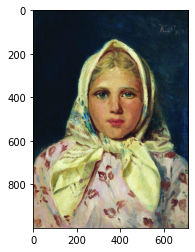

In [ ]:
plt.imshow(image)
plt.show()

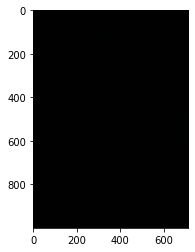

In [ ]:
img_add = np.clip(image,0,1) 
plt.imshow(img_add)
plt.show()